In [1]:
# coding=utf-8
"""
This module contains profiling reports for the fastlane_bot
"""
from fastlane_bot import Bot
from fastlane_bot.tools.cpc import ConstantProductCurve as CPC
from fastlane_bot.events.exchanges import UniswapV2, UniswapV3, SushiswapV2, CarbonV1, BancorV3
import subprocess, os, sys
import pytest
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(Bot))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(UniswapV2))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(UniswapV3))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(SushiswapV2))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonV1))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(BancorV3))
from fastlane_bot.testing import *
plt.rcParams['figure.figsize'] = [12,6]
from fastlane_bot import __VERSION__
require("3.0", __VERSION__)

/Users/mikewcasale/miniconda3/envs/fastlane-bot-38/lib/python3.8/site-packages/line_profiler/line_profiler.py:75: UserWarning: Adding a function with a __wrapped__ attribute. You may want to profile the wrapped function by adding y_min.__wrapped__ instead.
  self.add_function(func)


ConstantProductCurve v3.3 (21/Sep/2023)
CarbonBot v3-b2.2 (20/June/2023)
UniswapV2 v0.0.2 (2023-08-27)
UniswapV3 v0.0.2 (2023-08-27)
SushiswapV2 v0.0.2 (2023-08-27)
CarbonV1 v0.0.2 (2023-08-27)
BancorV3 v0.0.2 (2023-08-27)
imported m, np, pd, plt, os, sys, decimal; defined iseq, raises, require
Version = 3-b2.2 [requirements >= 3.0 is met]


# Setup

In [2]:
def find_main_py():
    # Start at the directory of the current script
    cwd = os.path.abspath(os.path.join(os.getcwd()))
    
    with open("log.txt", "w") as f:
        f.write(f"Searching for main.py in {cwd}")
                
    print(f"Searching for main.py in {cwd}")
    while True:
        # Check if main.py exists in the current directory
        if "main.py" in os.listdir(cwd):
            return cwd  # Found the directory containing main.py
        else:
            # If not, go up one directory
            new_cwd = os.path.dirname(cwd)

            # If we're already at the root directory, stop searching
            if new_cwd == cwd:
                raise FileNotFoundError("Could not find main.py in any parent directory")

            cwd = new_cwd
       
       
def run_command(mode, timeout=300):
    
    # Find the correct path to main.py
    main_script_path = find_main_py()
    print(f"Found main.py in {main_script_path}")
    main_script_path = main_script_path + "/main.py"

    # Run the command
    cmd = [
        "python",
        main_script_path,
        f"--arb_mode={mode}",
        f"--timeout={timeout}",
    ]
    subprocess.Popen(cmd)
    subprocess.run(cmd, text=True, capture_output=True, check=True, timeout=timeout*60)


## Test w/ 'multi' arb_mode

In [3]:
arb_modes = [
    "single",
    "multi",
    "triangle",
    "multi_triangle",
    "b3_two_hop",
    "multi_pairwise_pol",
]
mode = 'multi'

print(f"Running test for {mode}")

# uncomment the following line to run the test against the specified mode
# run_command(mode, 
#             timeout=300 # run for this many seconds before breaking the meain loop to generate the profiling report 
# )

Running test for multi


## Setup the profiling data

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mode = 'multi'

if not os.path.exists('csvs'):
    os.mkdir('csvs')

if not os.path.exists('img'):
    os.mkdir('img')

# List all files in the current directory
all_files = os.listdir('.')

# Filter out CSV files
cproc_files = [file for file in all_files if file.endswith('.csv') and 'cprofile_stats' in file]
linestatus_files = [file for file in all_files if file.endswith('.csv') and 'line_profiler' in file]

# combine all cproc_files of the same arb_mode into a single csv file
cprofile_data = pd.concat([pd.read_csv(file) for file in cproc_files])

# combine all linestatus_files of the same arb_mode into a single csv file
linestatus_data = pd.concat([pd.read_csv(file) for file in linestatus_files])

# Data cleaning cprofile
cprofile_data = cprofile_data[cprofile_data['func_name'].astype(str).fillna('None').str.contains('fastlane_bot')]
cprofile_data['func_name'] = cprofile_data['func_name'].apply(lambda x: x.split('fastlane_bot/')[-1])

# Data cleaning linestatus
linestatus_data = linestatus_data[linestatus_data['func_name'].astype(str).fillna('None').str.contains('fastlane_bot')]
linestatus_data['func_name'] = linestatus_data['func_name'].apply(lambda x: x.split('fastlane_bot/')[-1])

print(f"Found {len(cproc_files)} cprofile files and {len(linestatus_files)} linestatus files")
print(f"Found {len(cprofile_data)} cprofile rows and {len(linestatus_data)} linestatus rows")

# splitup the reporting by modules [config, events, helpers, modes, tools, bot]
reports = {}
reporting_data = ['cprofile_data', 'linestatus_data']

for reporting in reporting_data:
    modules = ['config', 'events', 'helpers', 'modes', 'tools', 'bot']
    data = eval(reporting)
    reports[reporting] = {}
    for module in modules:
        reports[reporting][module] = data[data['func_name'].str.contains(module)]
        print(f"Found {len(reports[reporting][module])} rows for {module} in {reporting}")

def generate_plots(reports, module, reporting, timetype='cumtime'):
    data = reports[reporting][module].copy()
    if timetype not in data.columns:
        timetype = 'time'

    # expand the func_name into [file, line_num, func_name]
    data[['file', 'line_no', 'func_name']] = data['func_name'].str.split(',', expand=True)
    data['filefunc'] = data['file'].str.replace(module,'') + ':' + data['func_name']

    # sort by cumtime
    data.sort_values(by=[timetype], inplace=True, ascending=False)

    # ignore SettingsWithCopyWarning
    pd.options.mode.chained_assignment = None

    # Number of rows and iteration step in the sample
    num_rows_sample = data.shape[0]
    step_sample = 10
    
    # Iterate through the DataFrame in steps of 10 for the sample and generate plots
    plot_paths = []
    for i in range(0, num_rows_sample, step_sample):
        subset_sample = data.iloc[i:i+step_sample]

        # Plotting current subset by total time
        plt.figure(figsize=(12, 6))
        sns.barplot(x=timetype, y='filefunc', data=subset_sample, hue='line_no', dodge=False)
        plt.title(f'{reporting} Top {i+1} to {i+step_sample} Slowest Lines by {timetype} ({module}/* module) ({mode} arb_mode)')
        plt.xlabel(f'{timetype} (µs)')
        plt.ylabel('File/Function Name')
        plt.legend(title='Line Number')
        plot_path_sample = f'img/{module}_{reporting}_top_{i+1}_to_{i+step_sample}_slowest_by_{timetype}.png'
        plot_paths.append(plot_path_sample)
        plt.savefig(plot_path_sample)
        plt.show()

Found 1 cprofile files and 1 linestatus files
Found 462 cprofile rows and 947 linestatus rows
Found 37 rows for config in cprofile_data
Found 182 rows for events in cprofile_data
Found 69 rows for helpers in cprofile_data
Found 19 rows for modes in cprofile_data
Found 110 rows for tools in cprofile_data
Found 38 rows for bot in cprofile_data
Found 13 rows for config in linestatus_data
Found 453 rows for events in linestatus_data
Found 75 rows for helpers in linestatus_data
Found 58 rows for modes in linestatus_data
Found 304 rows for tools in linestatus_data
Found 48 rows for bot in linestatus_data


### Analyze events/ module profiling data

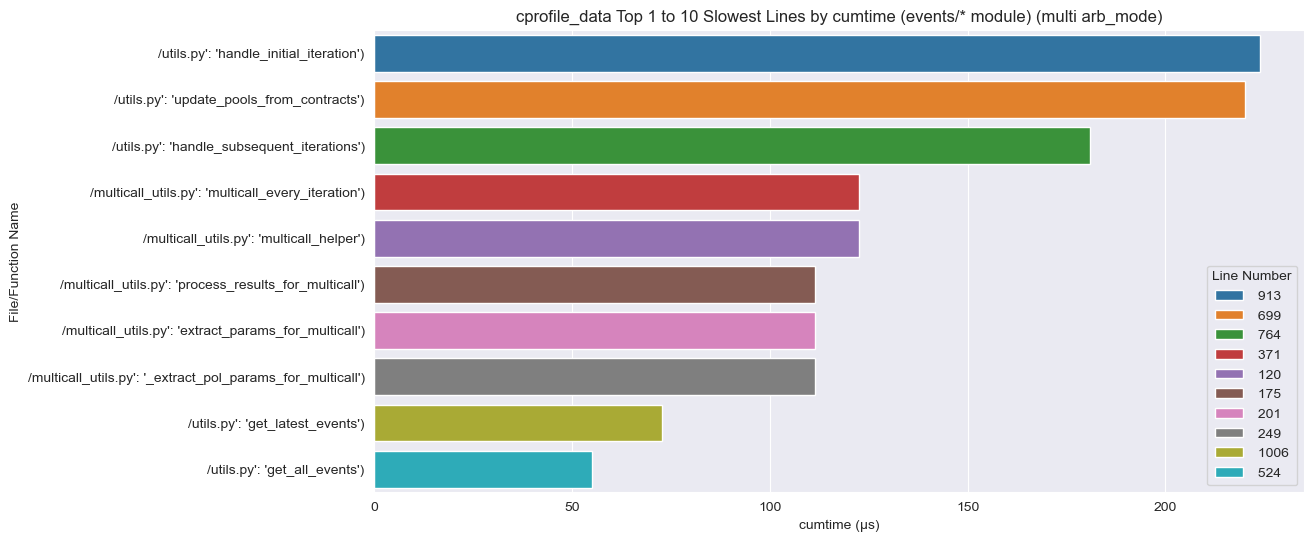

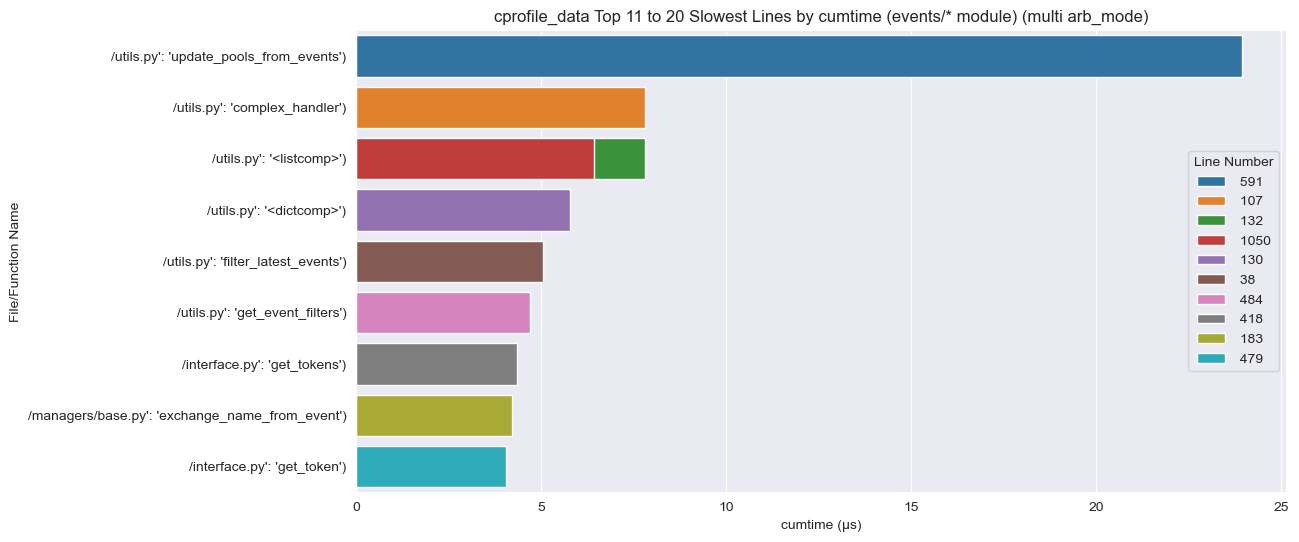

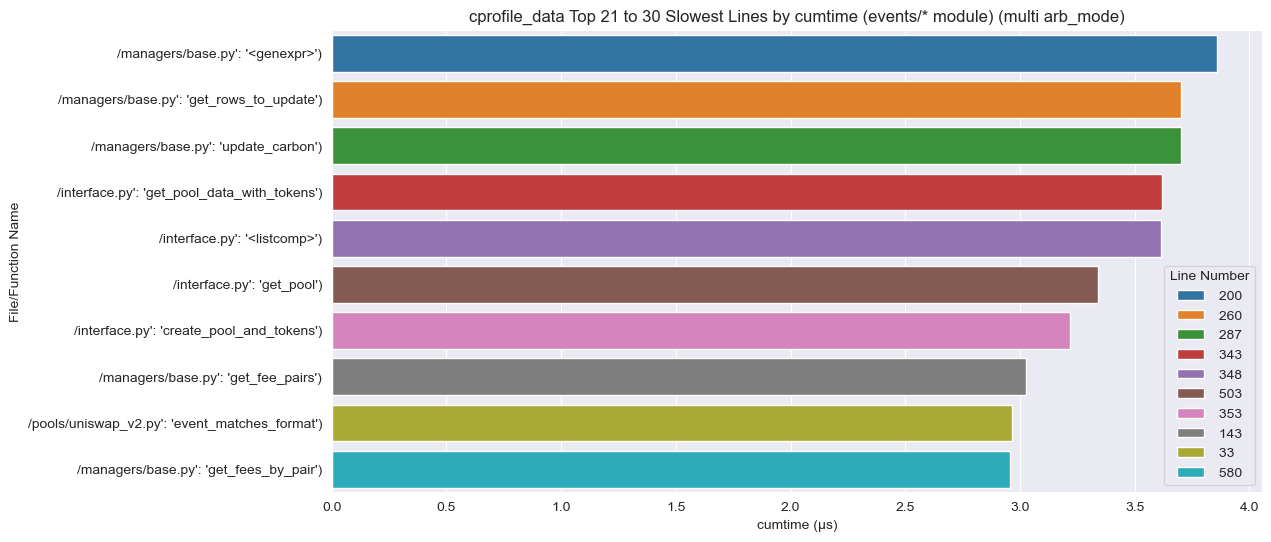

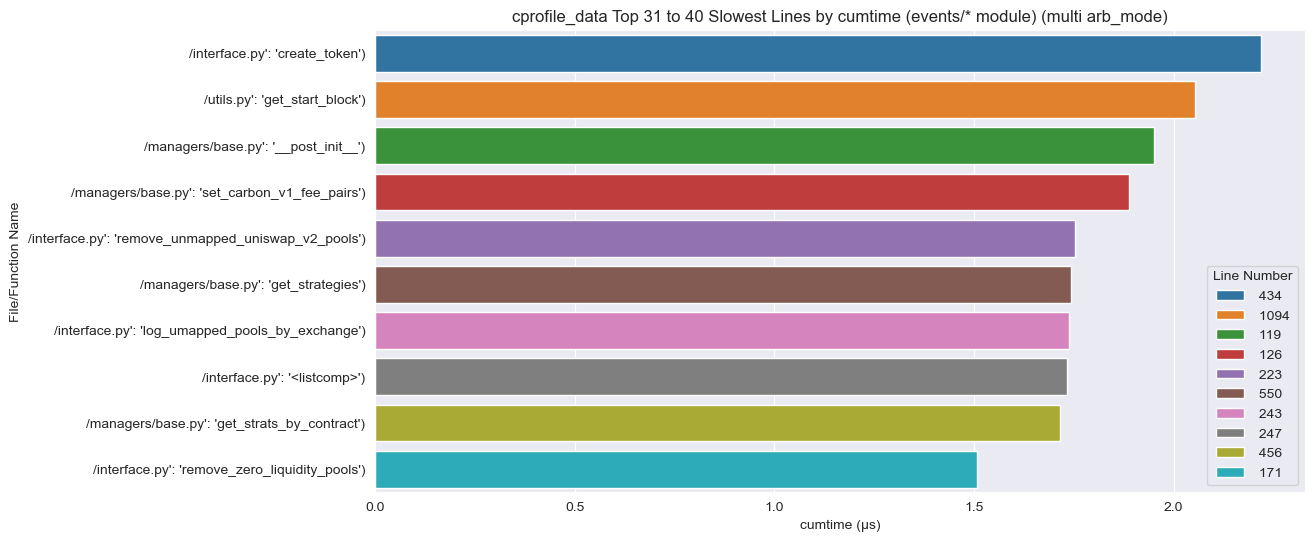

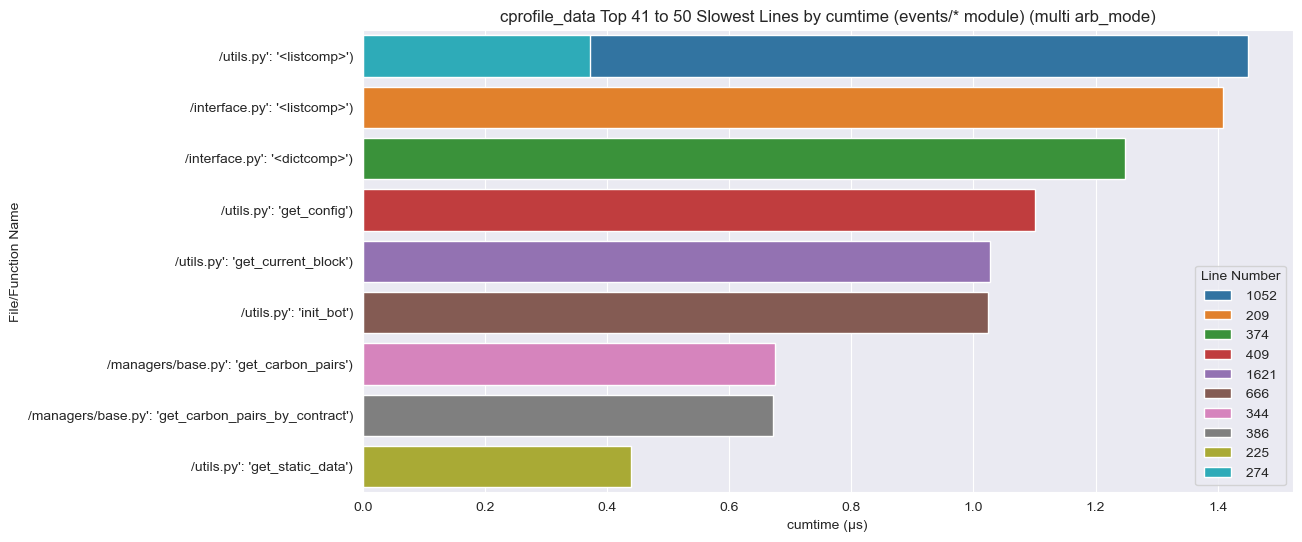

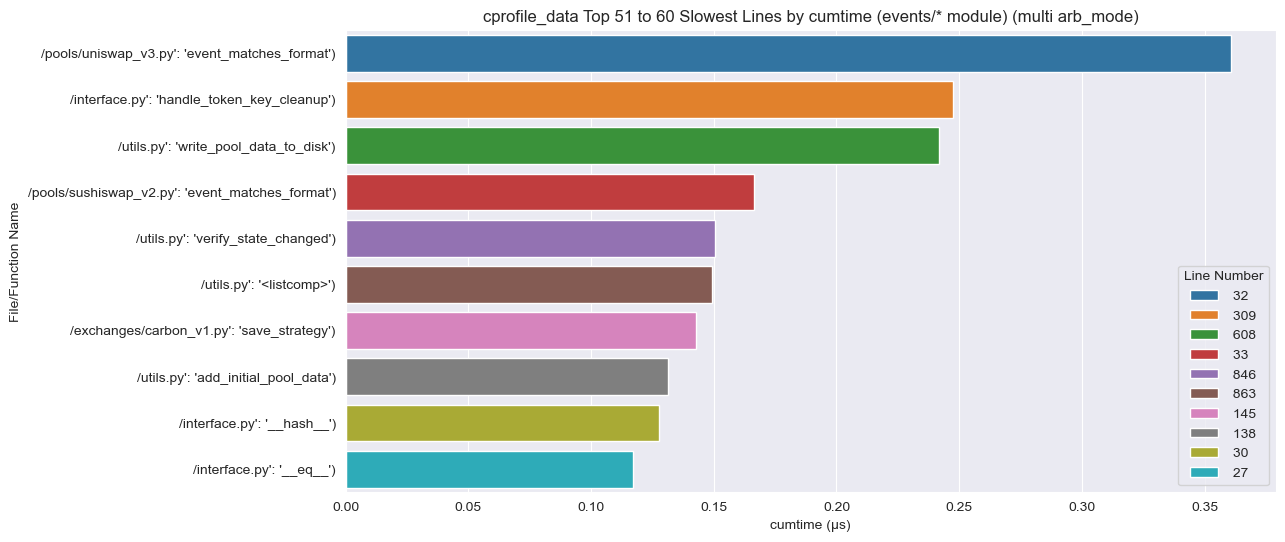

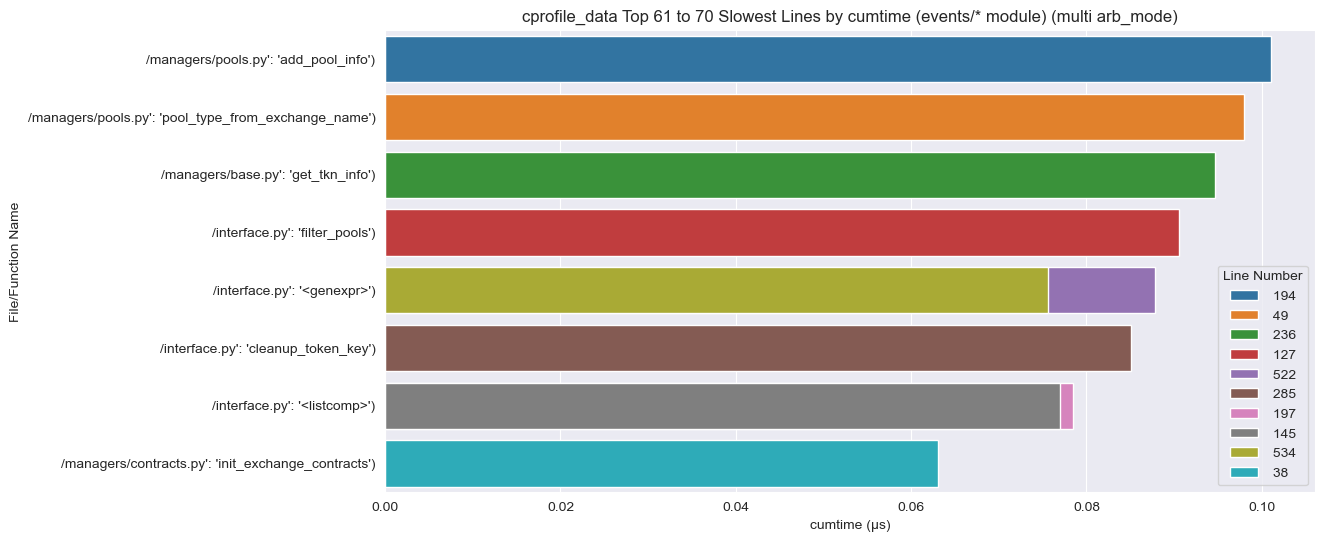

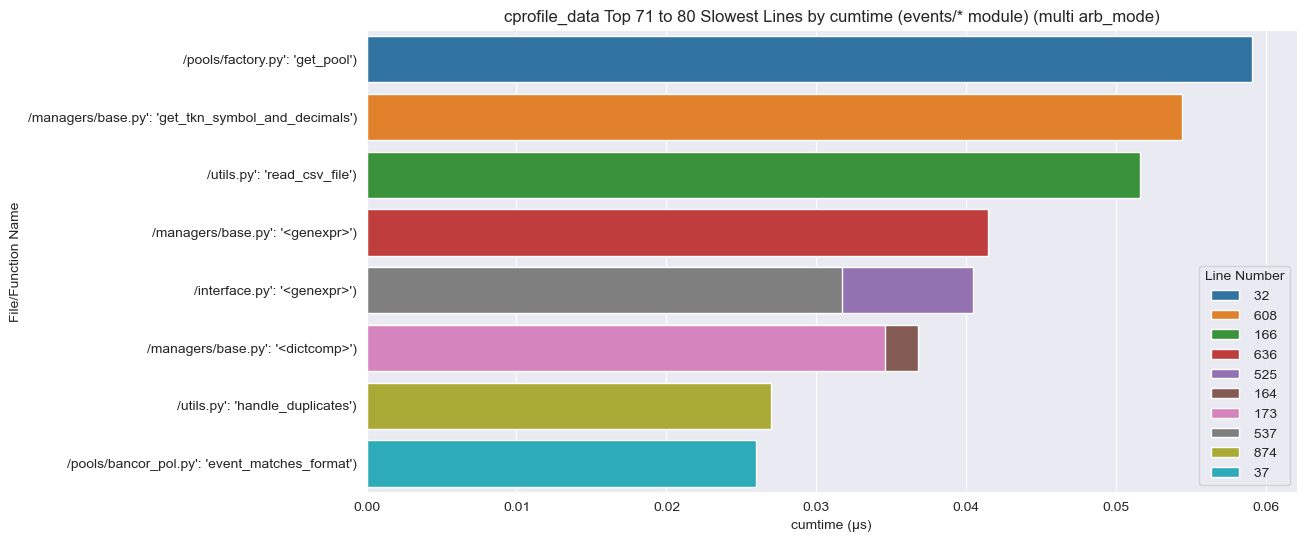

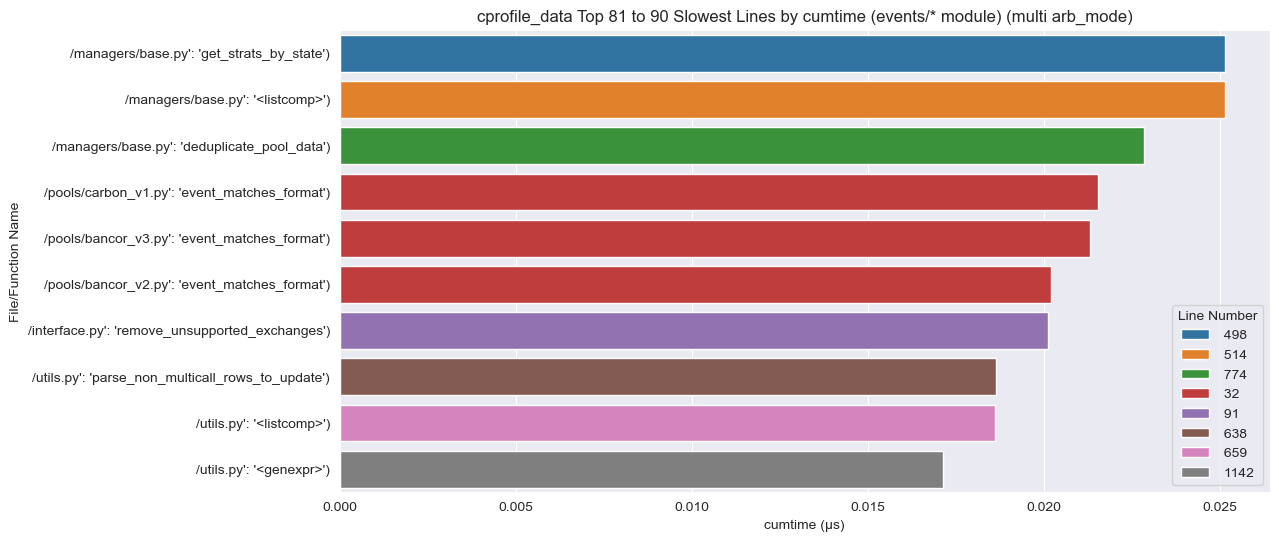

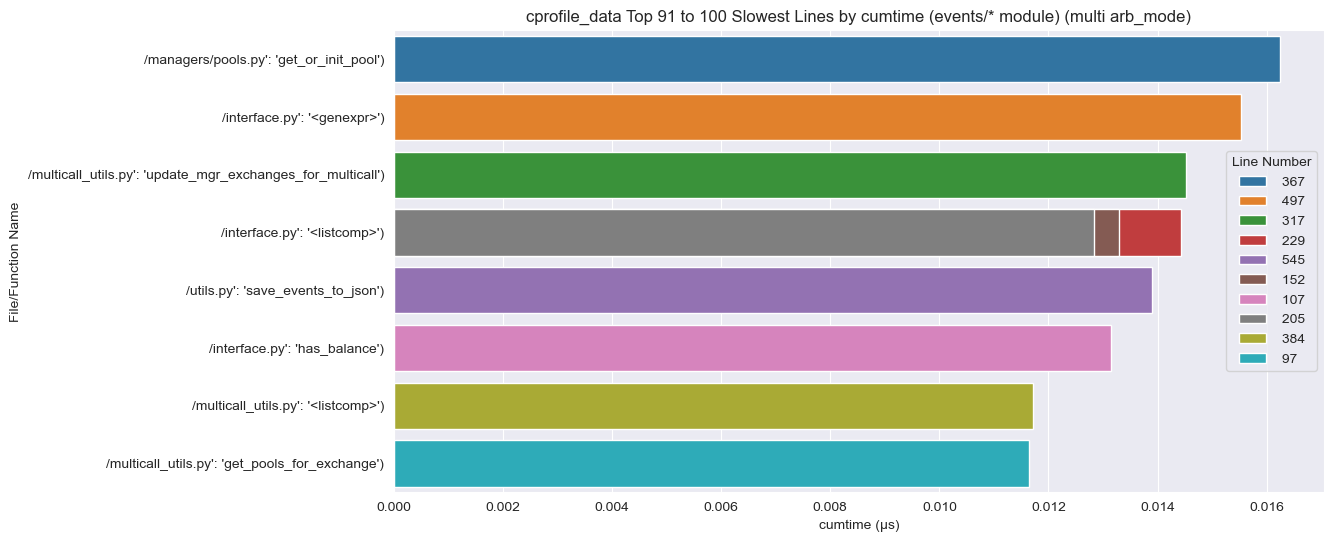

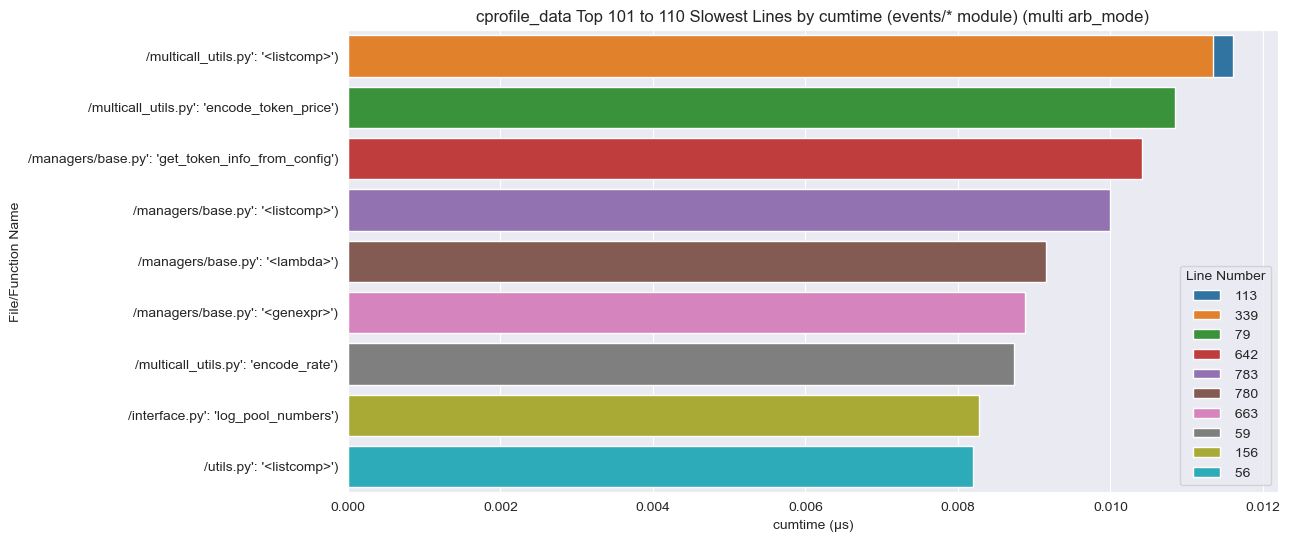

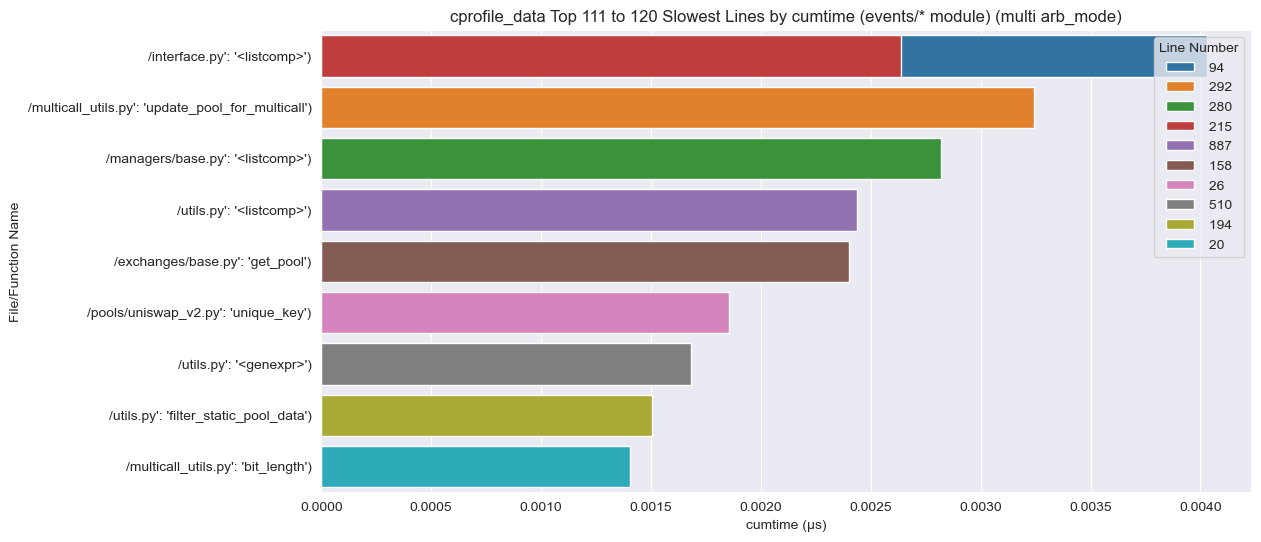

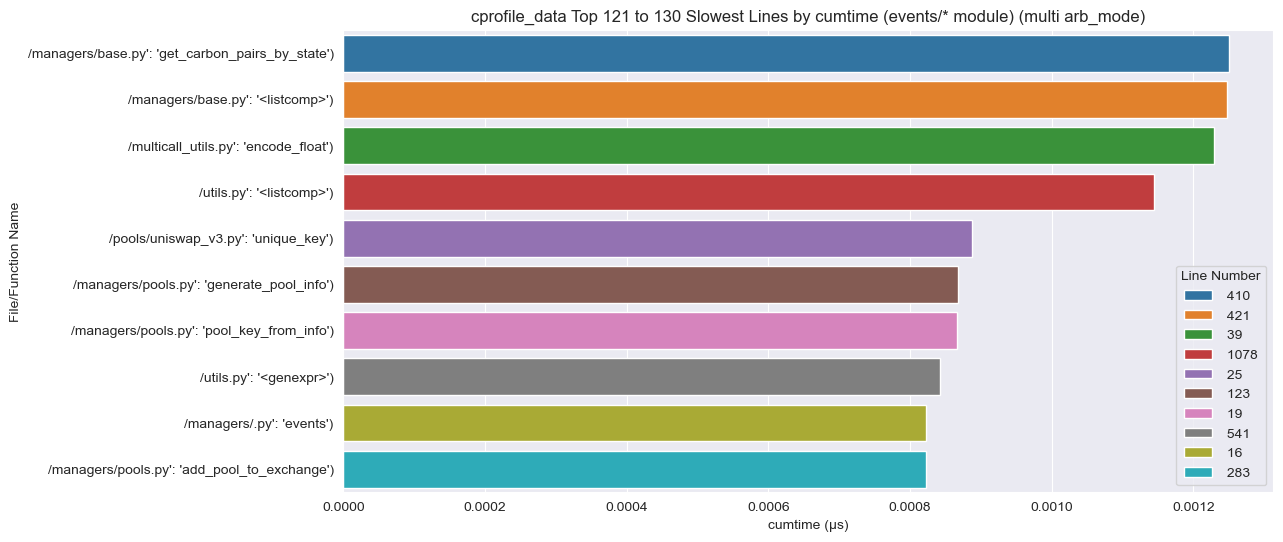

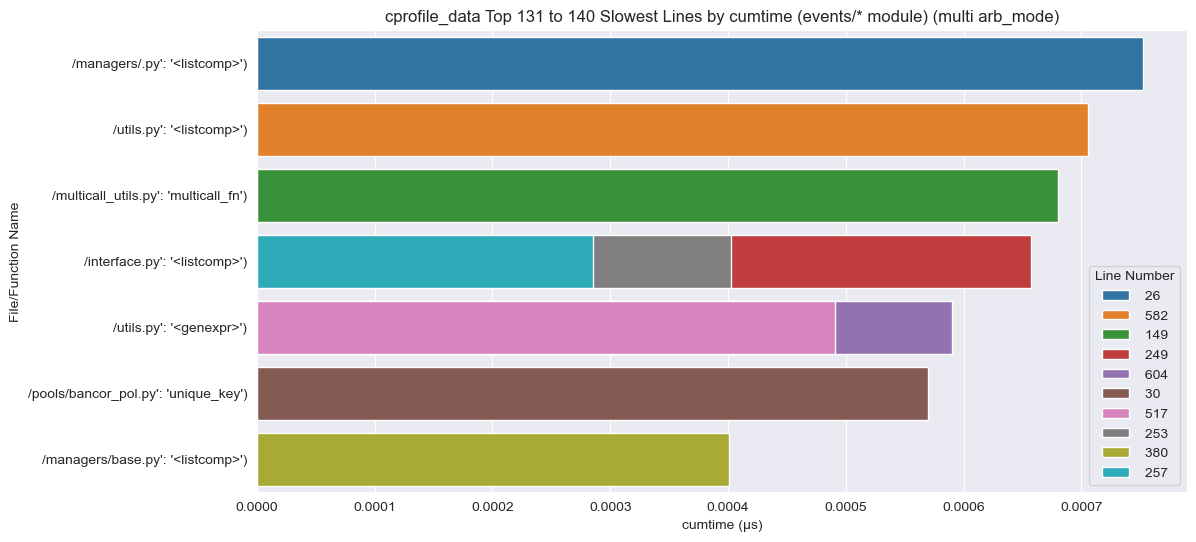

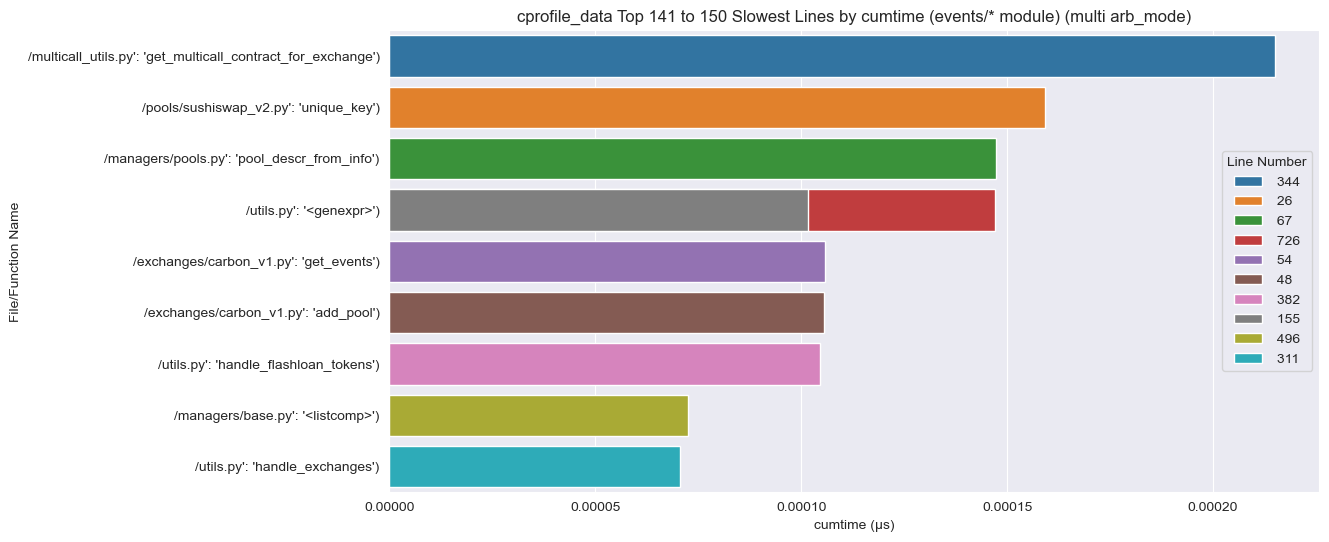

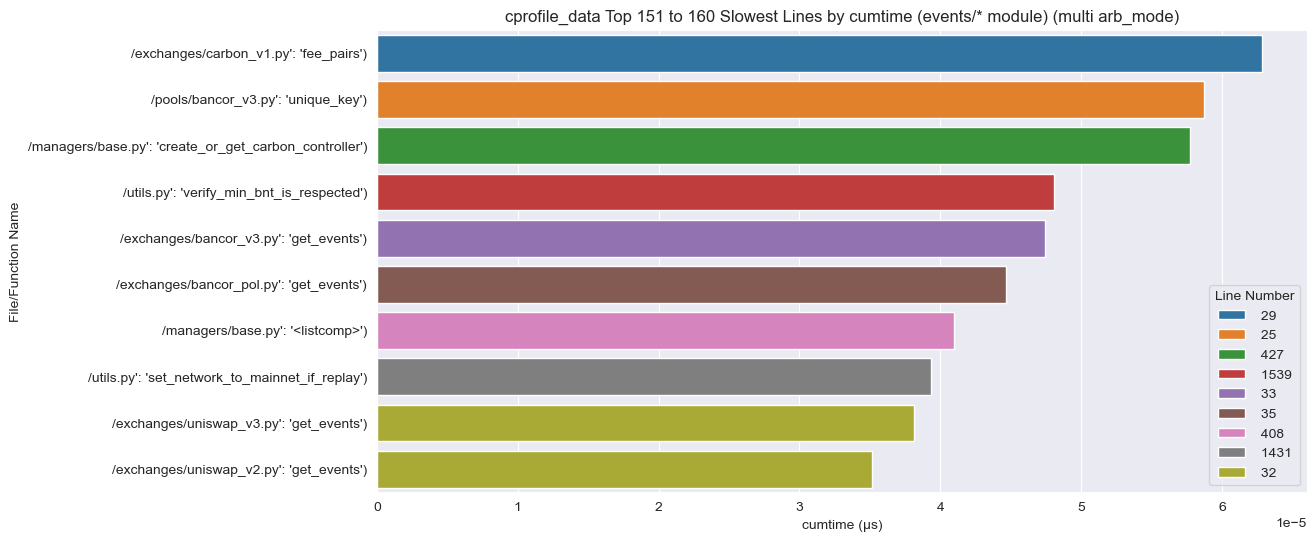

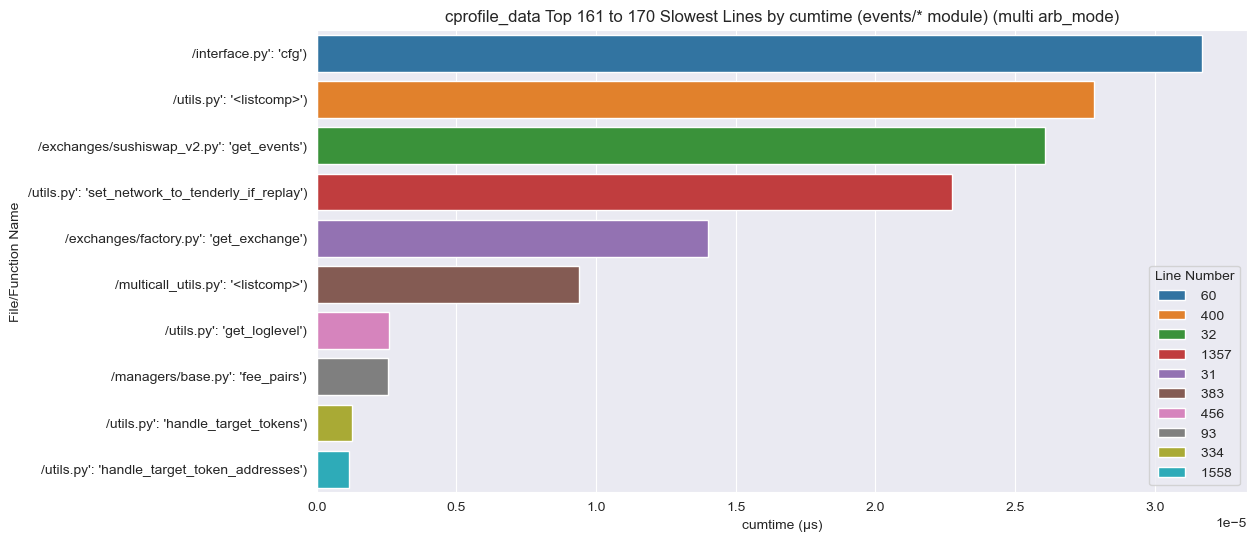

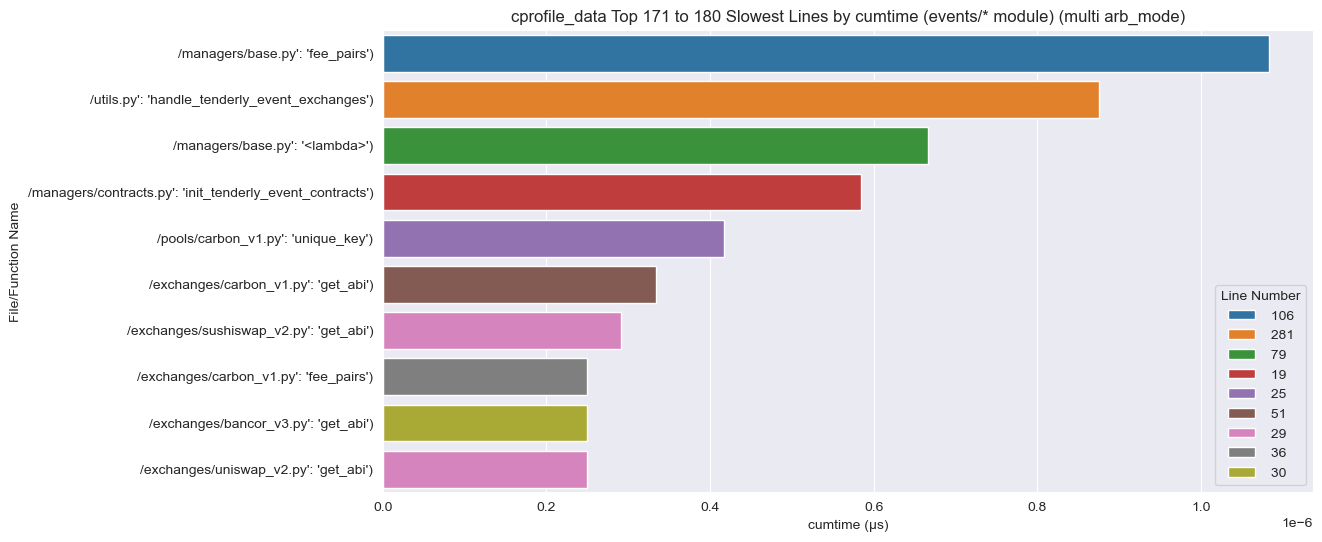

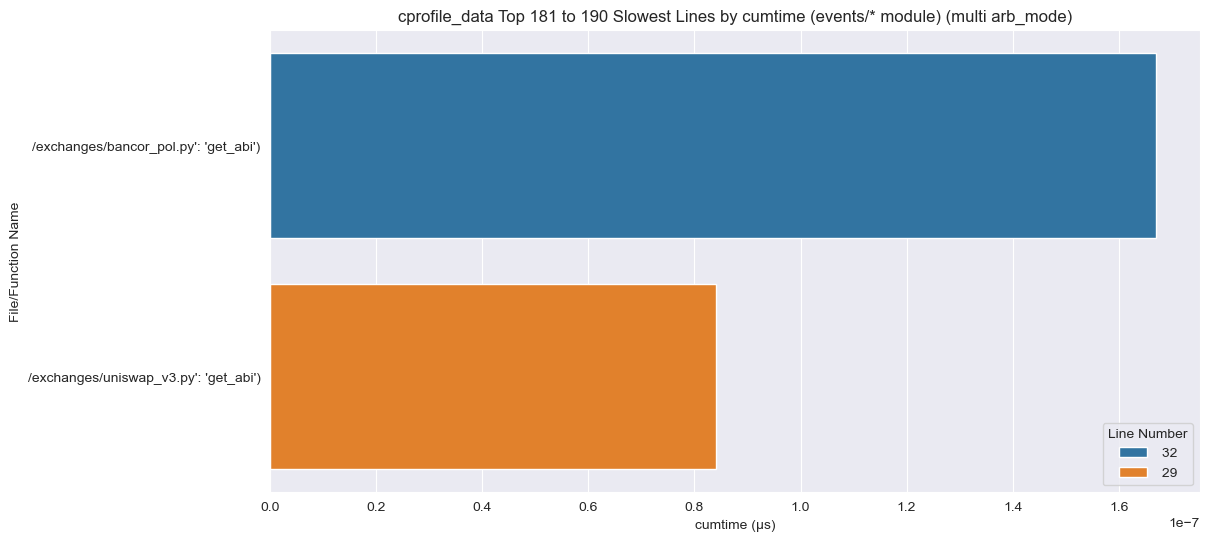

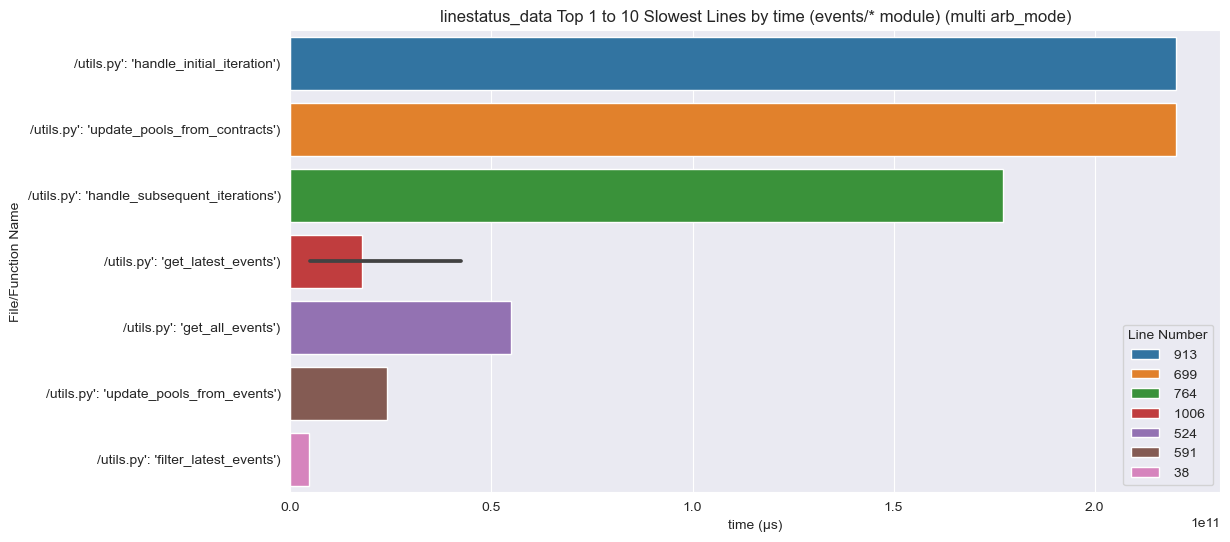

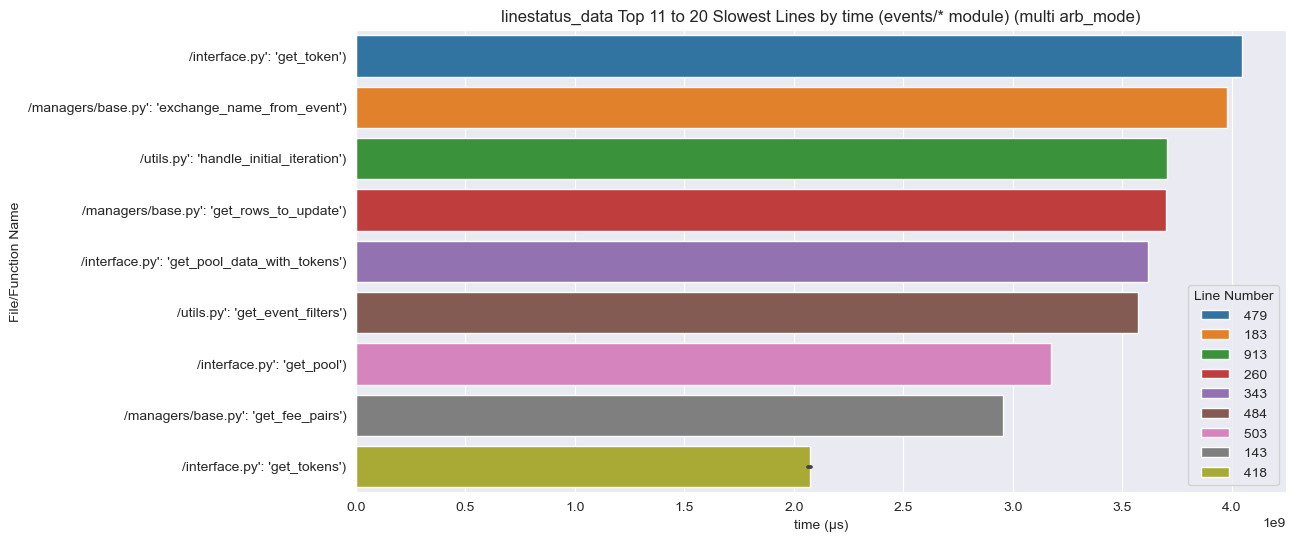

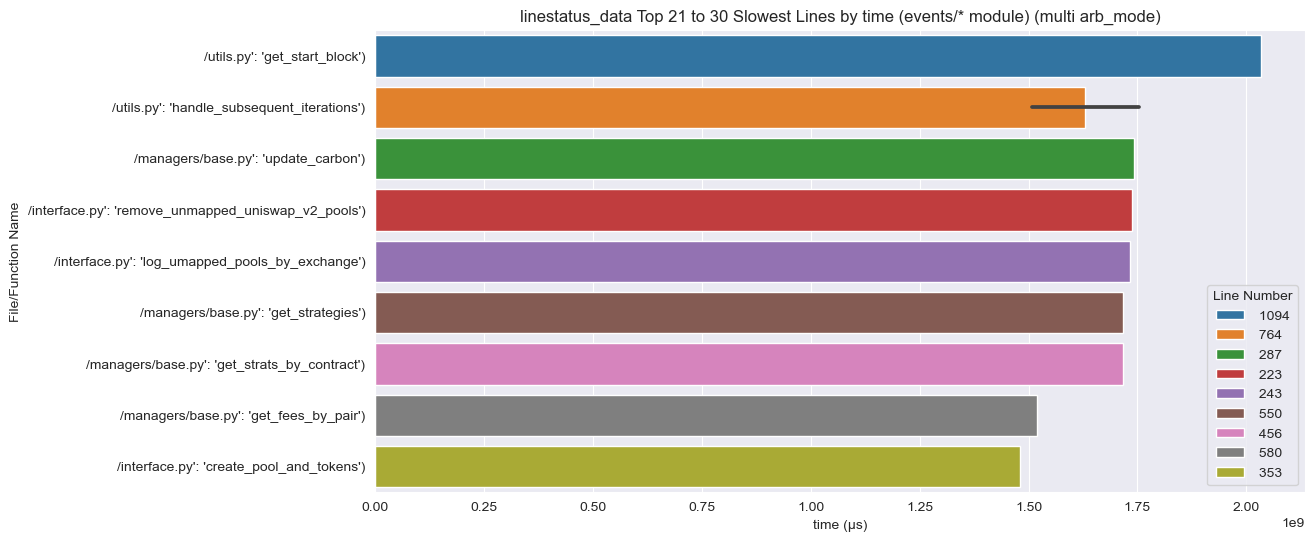

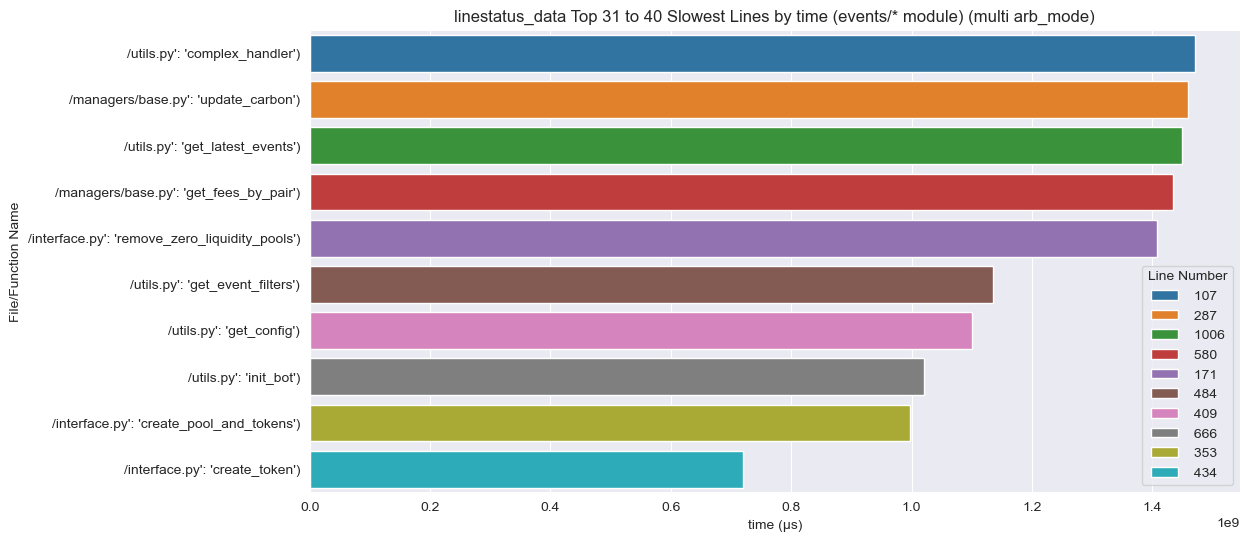

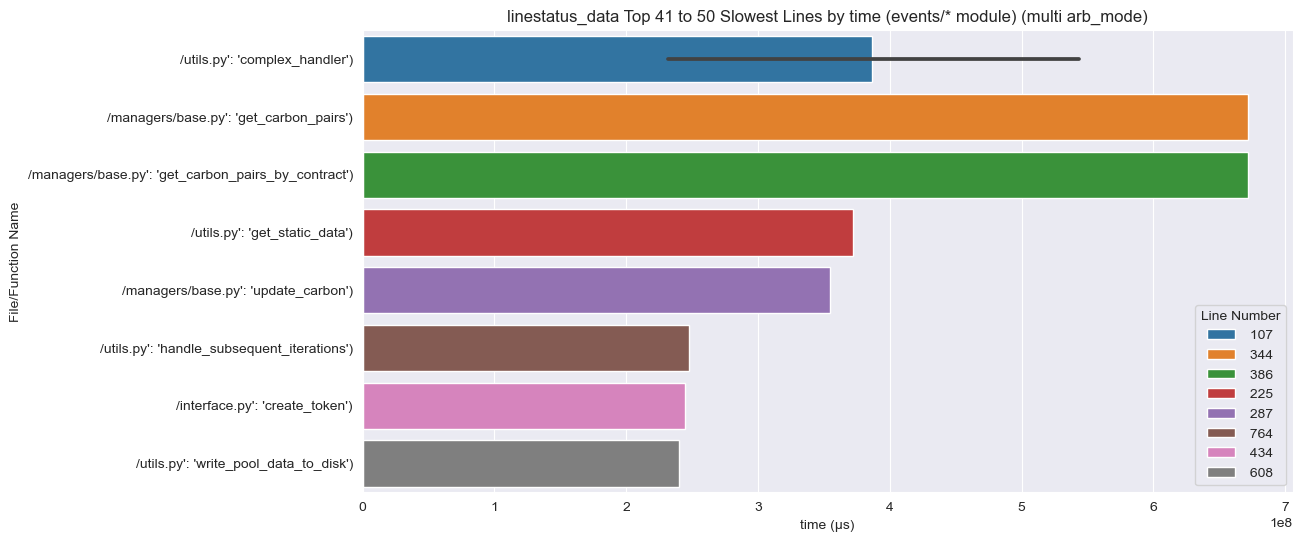

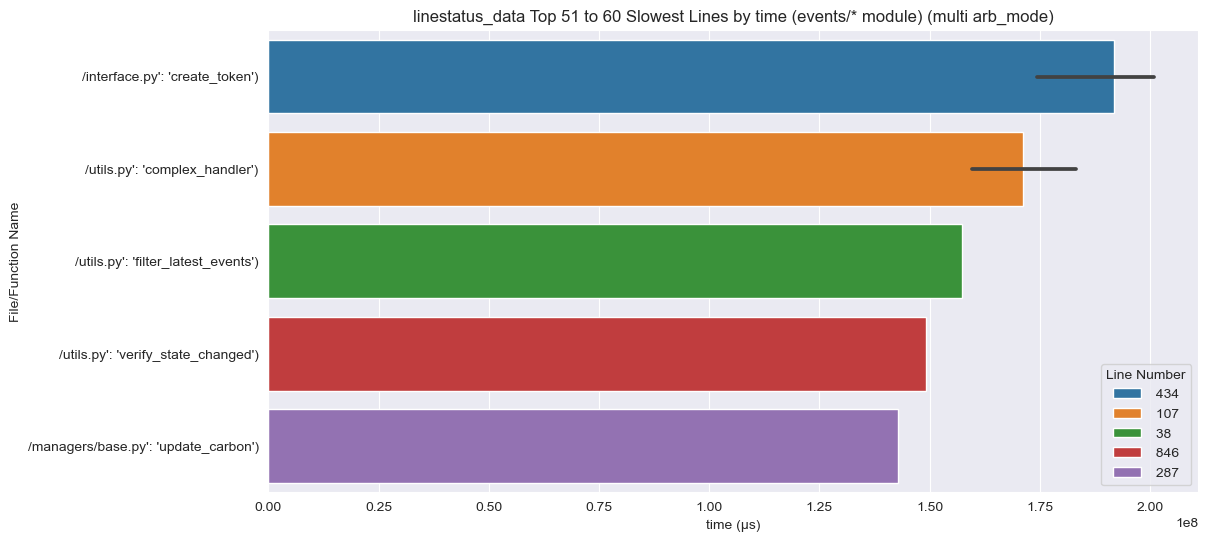

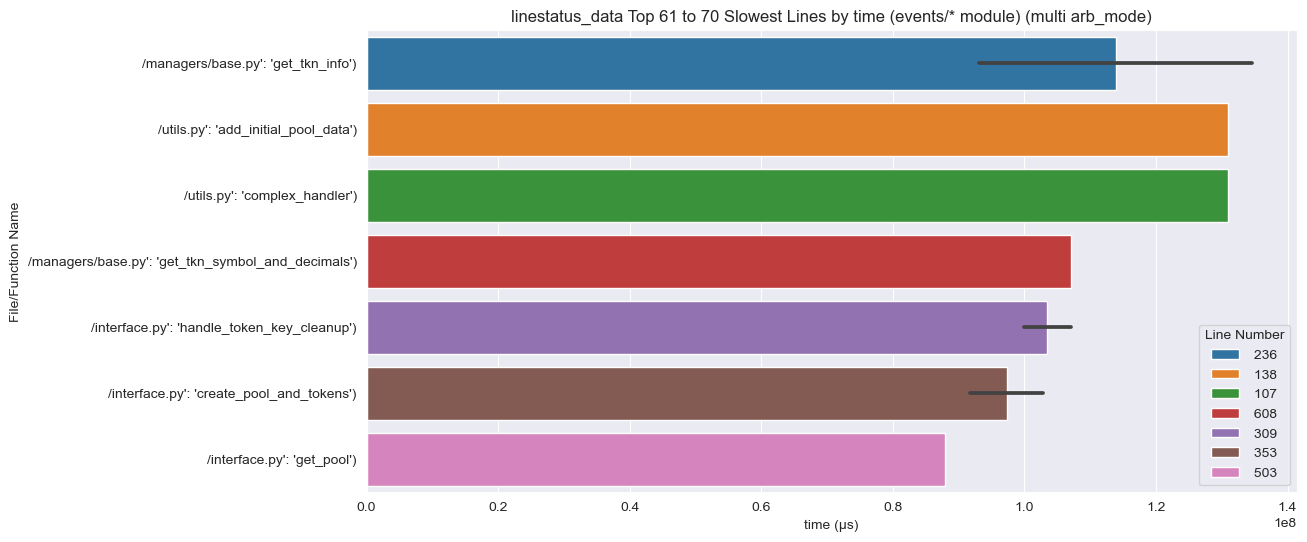

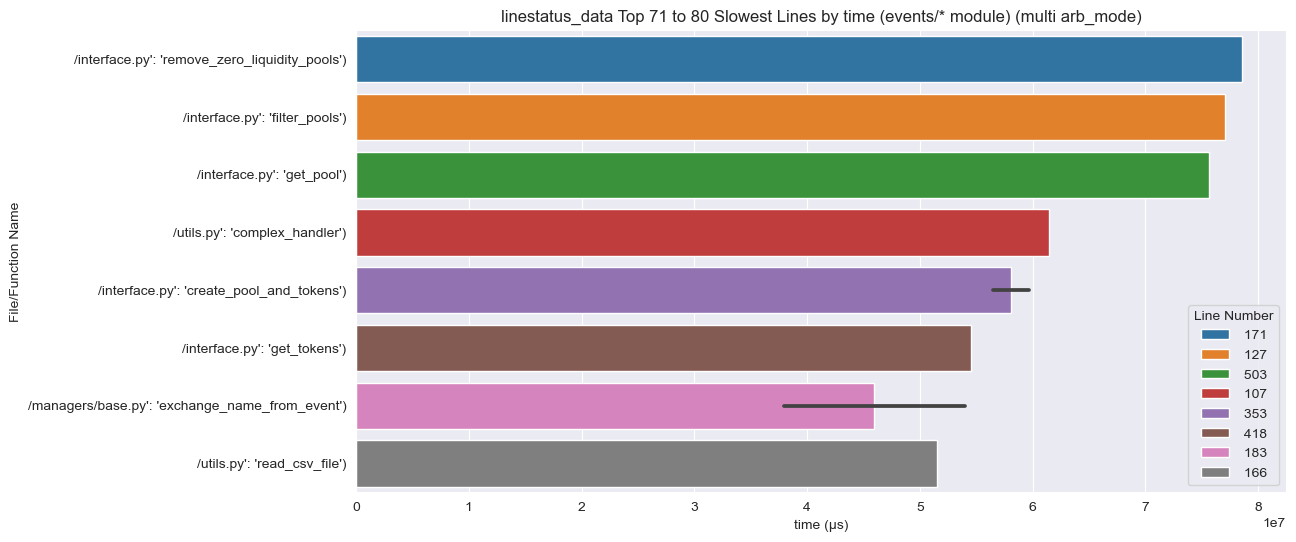

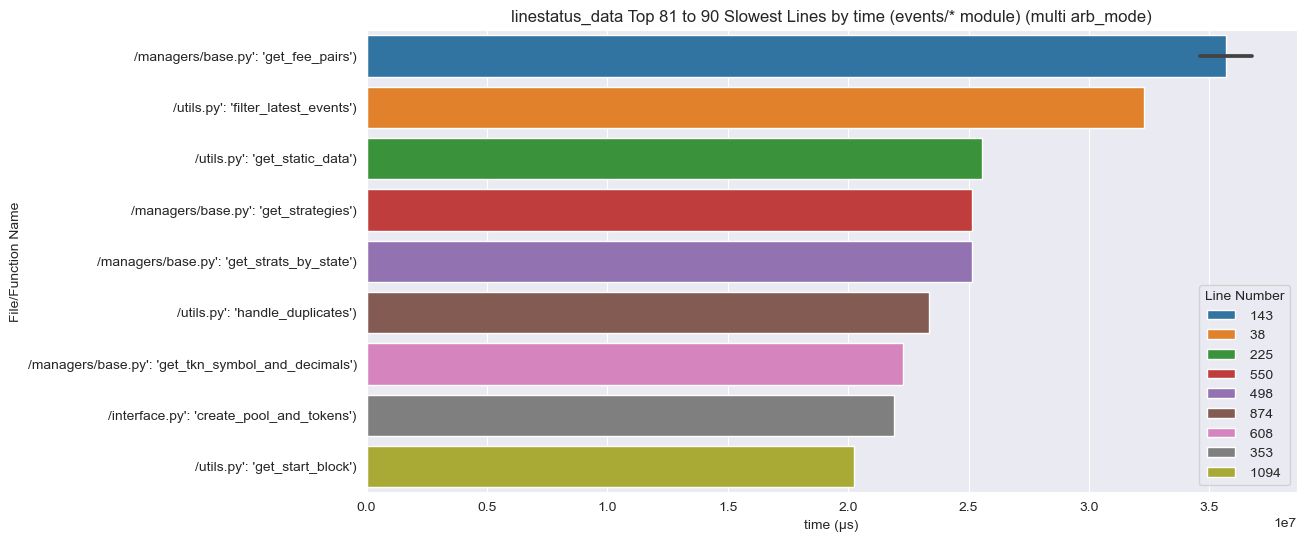

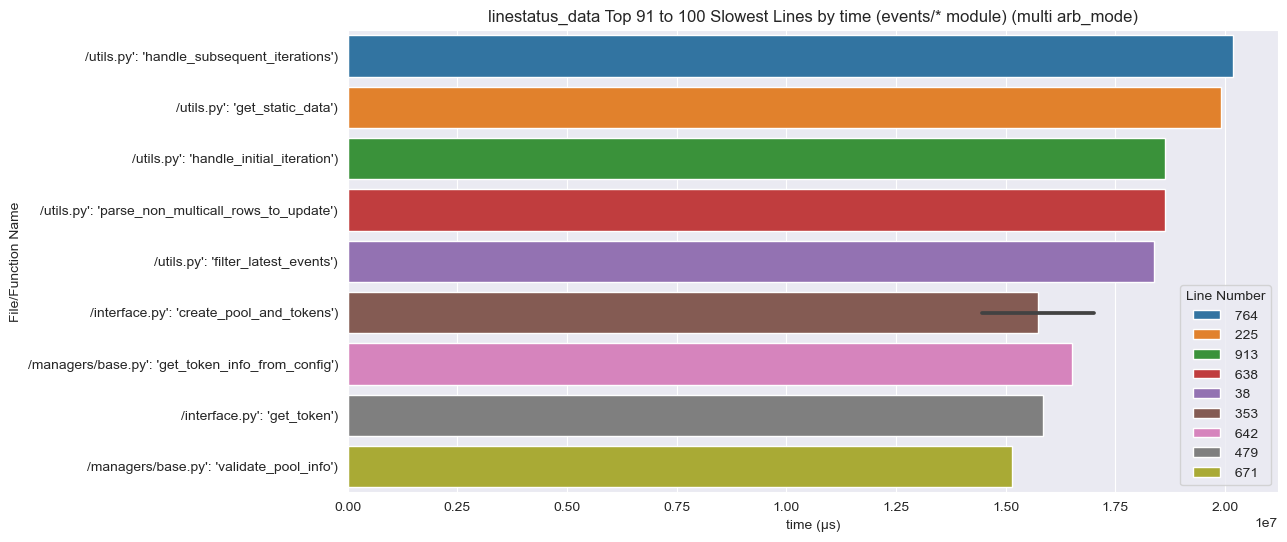

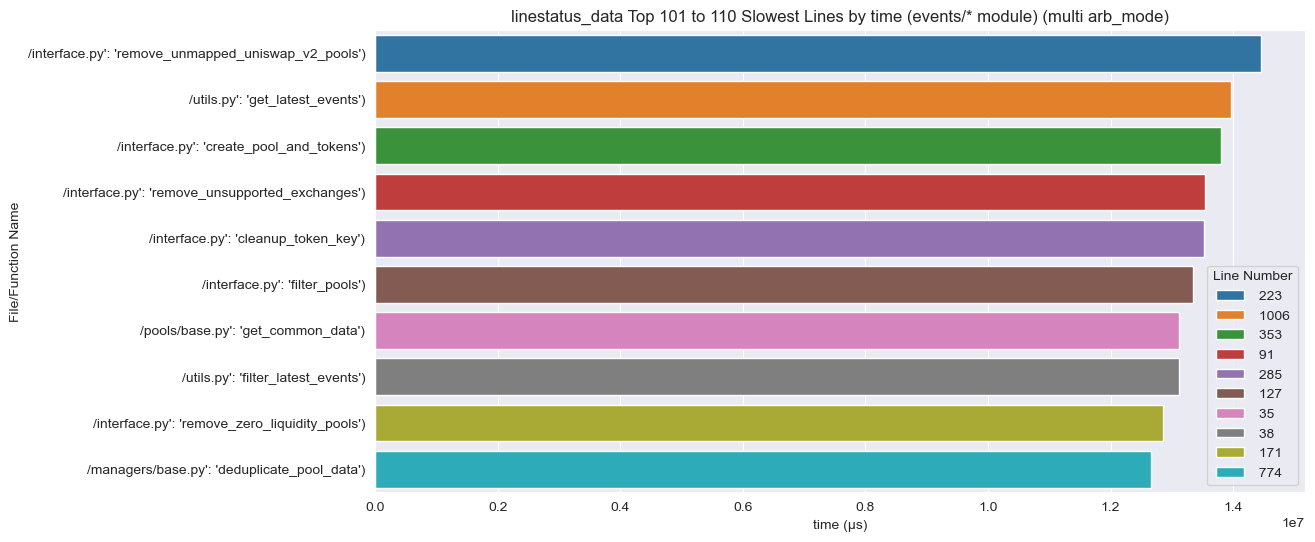

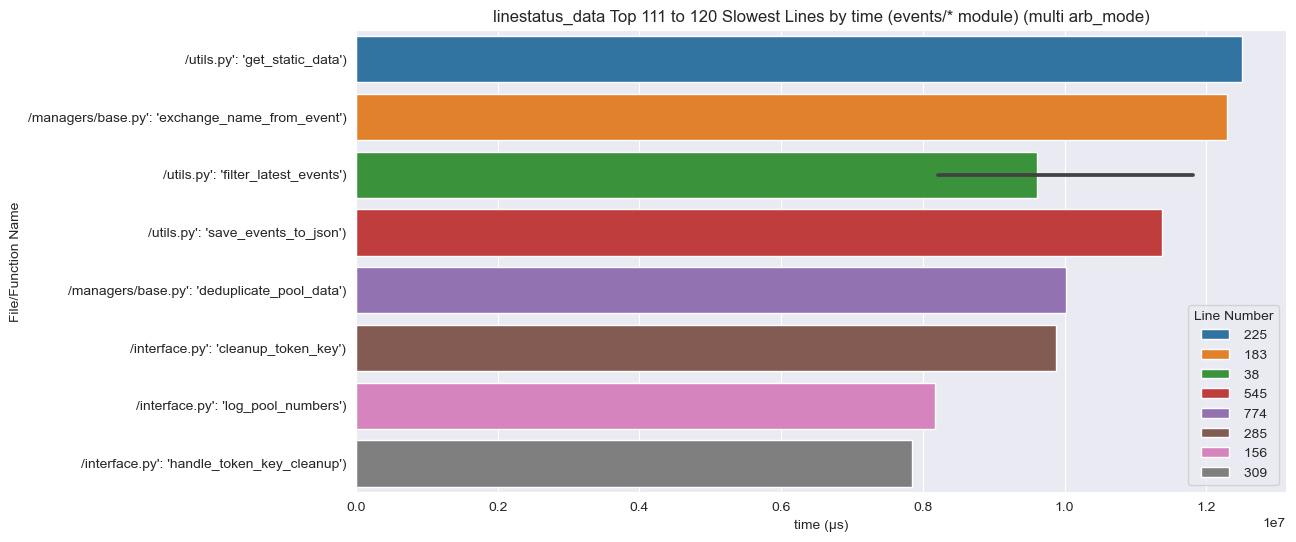

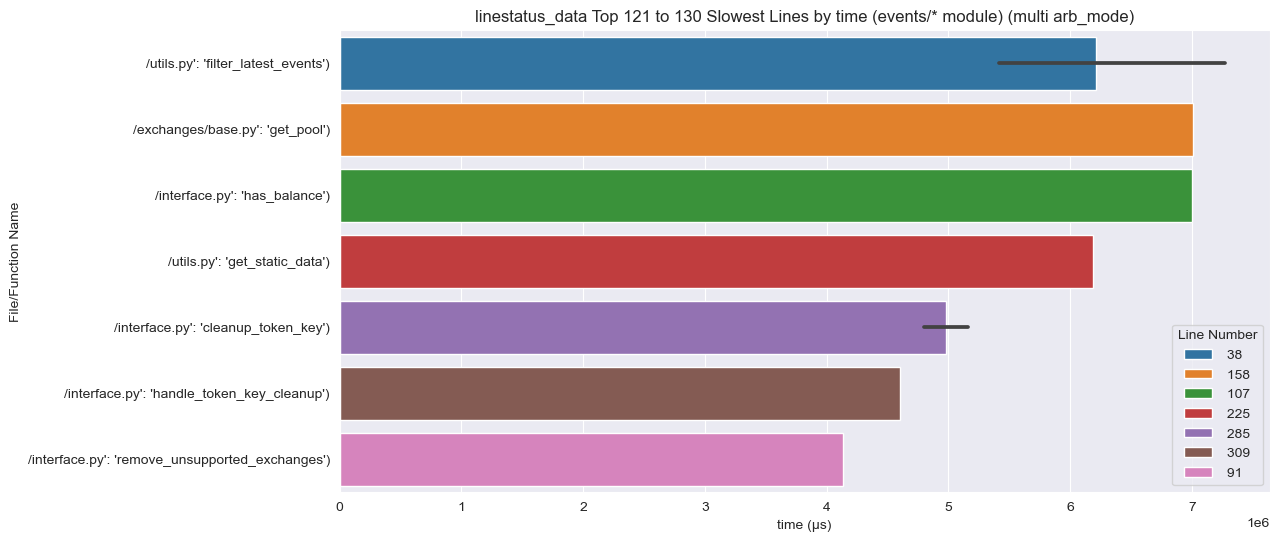

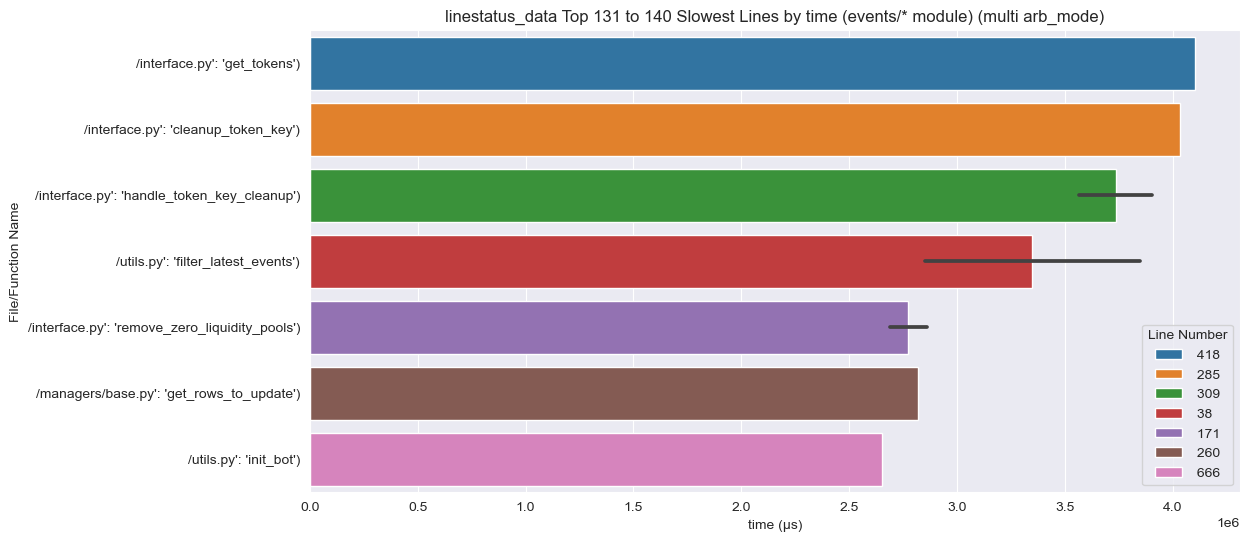

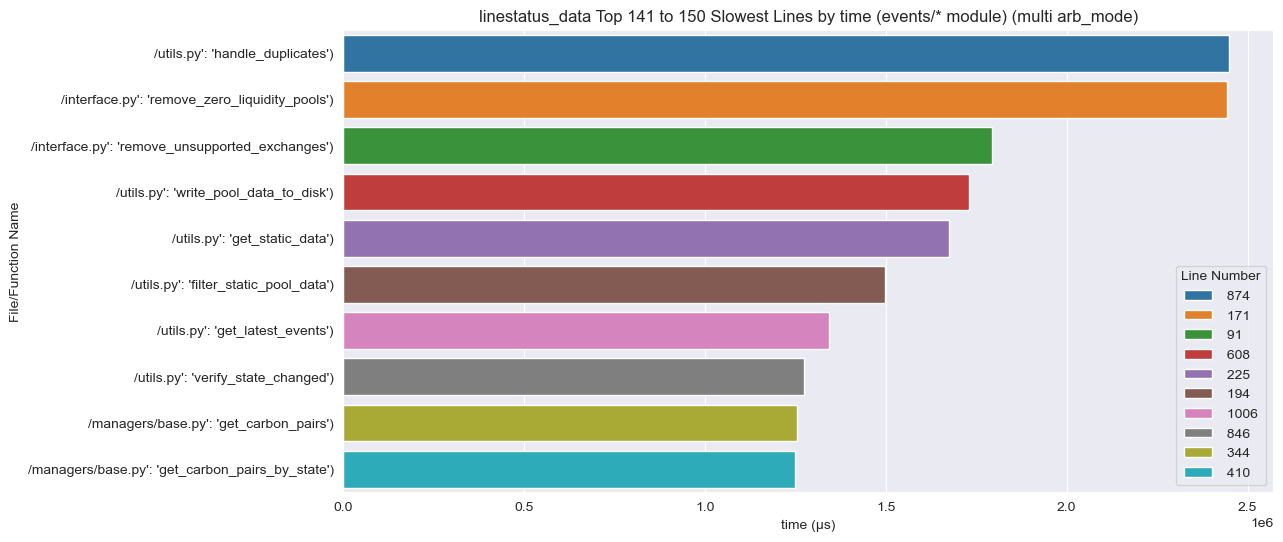

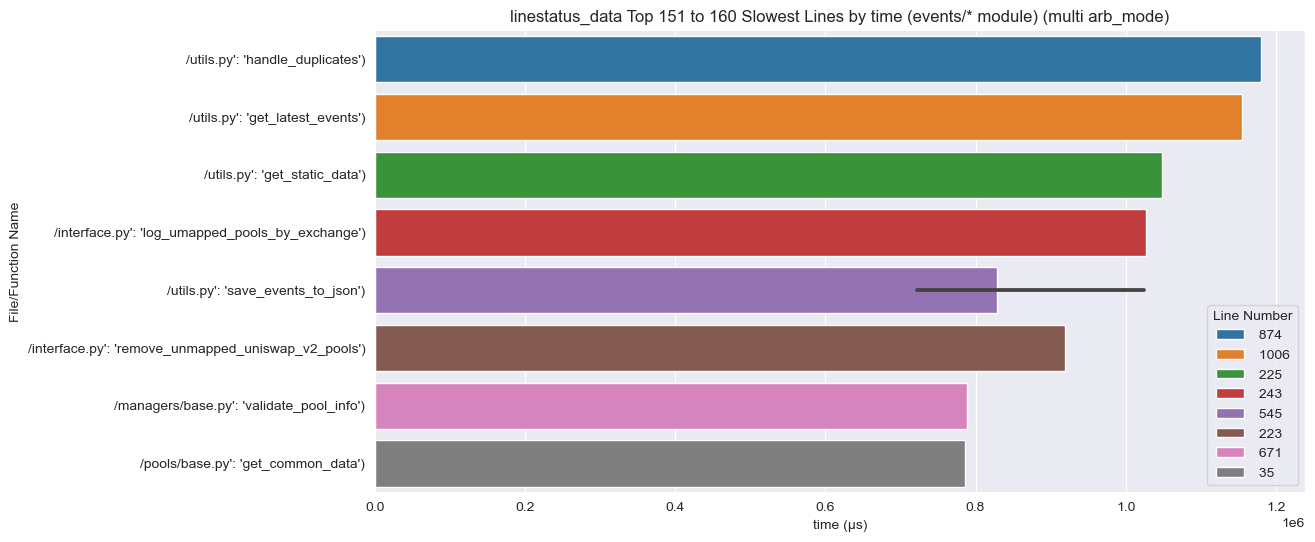

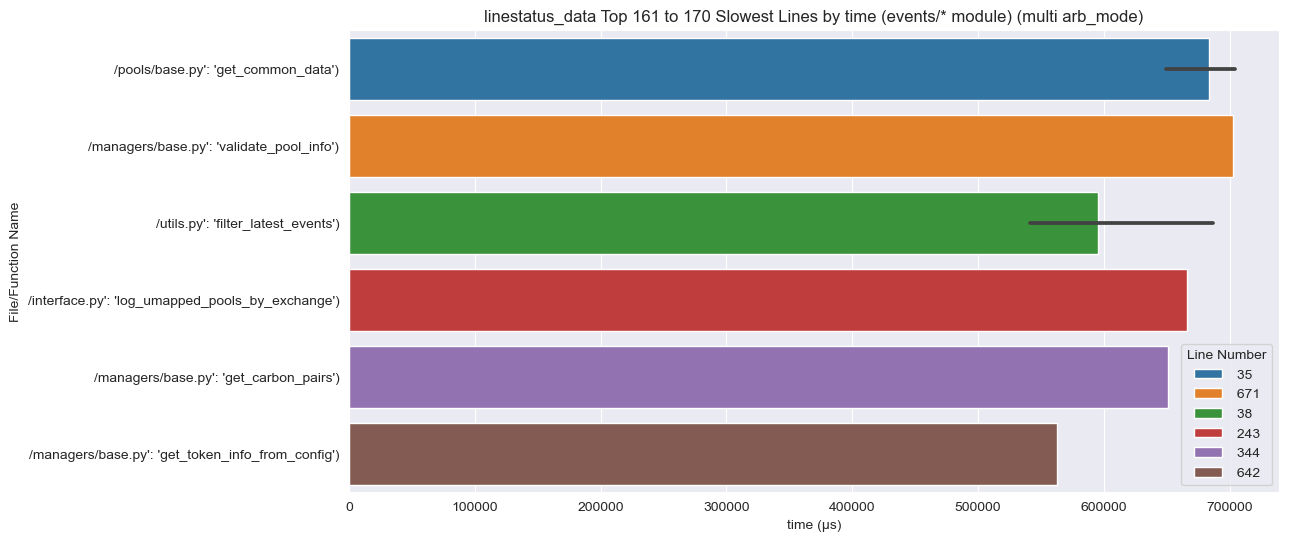

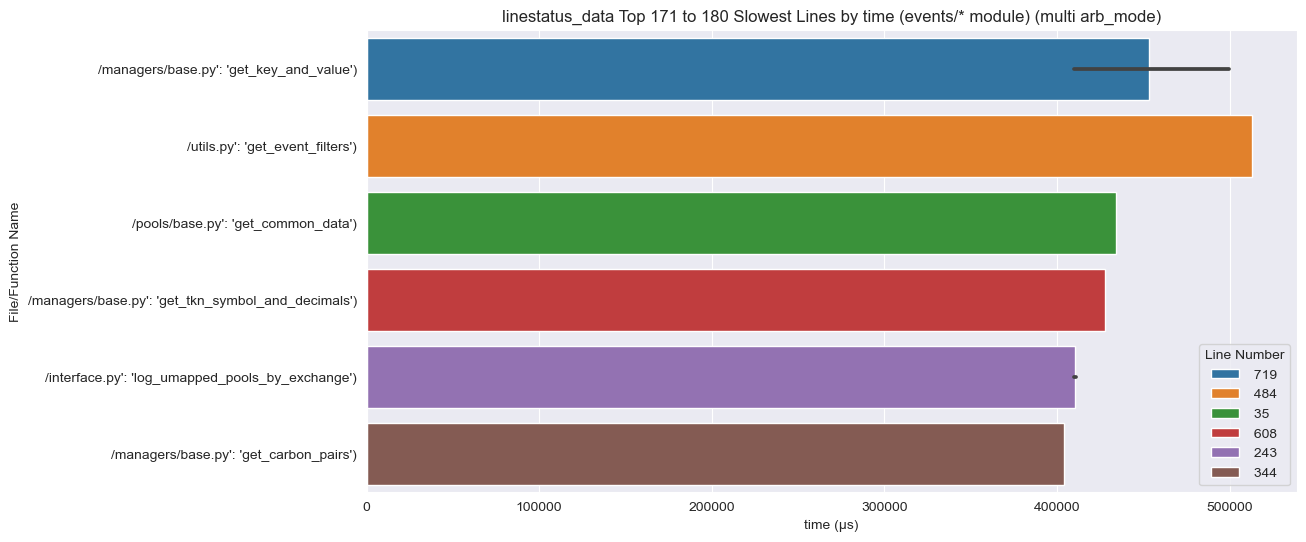

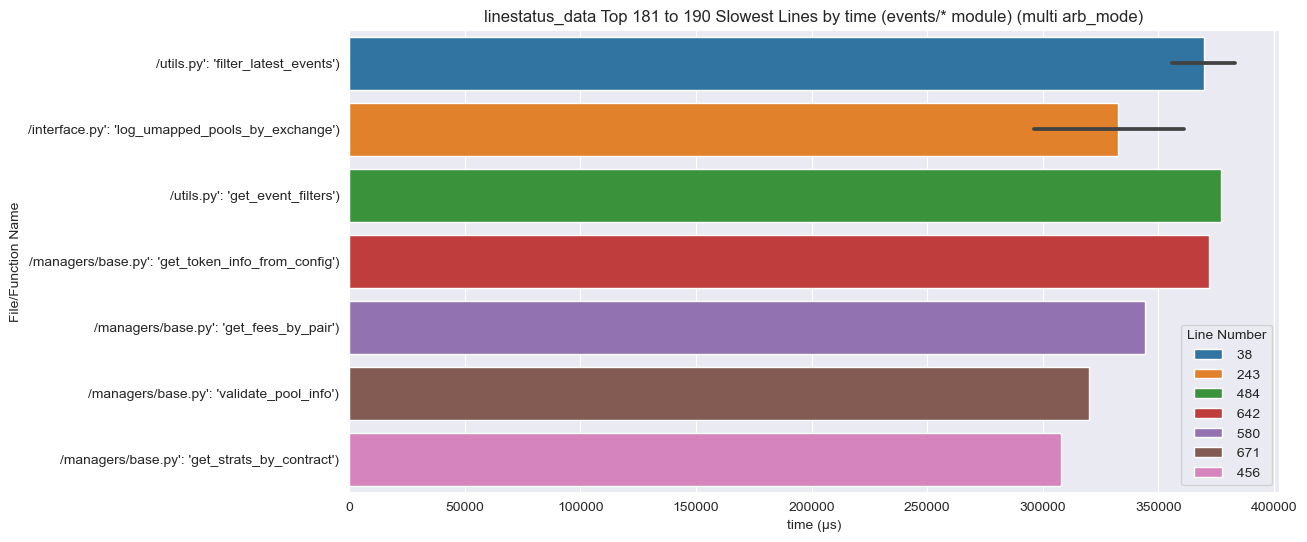

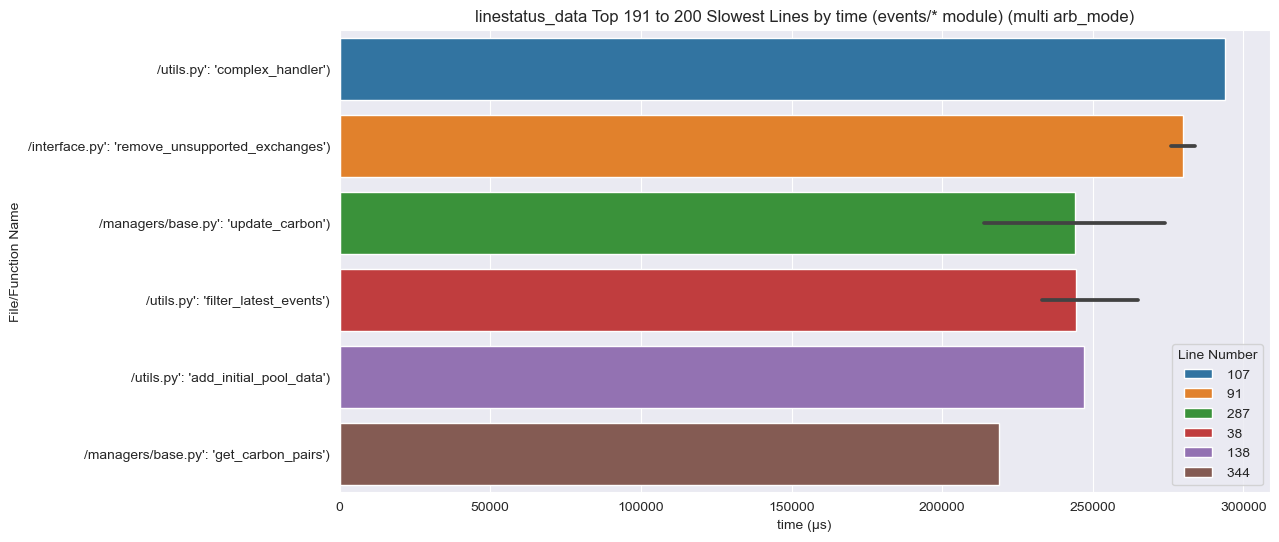

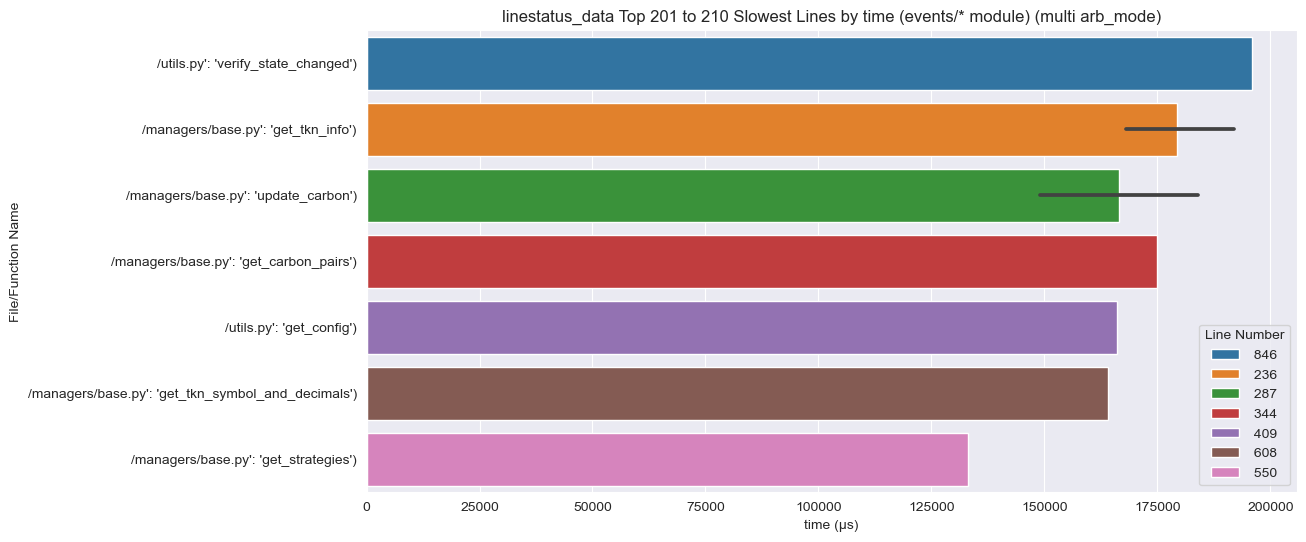

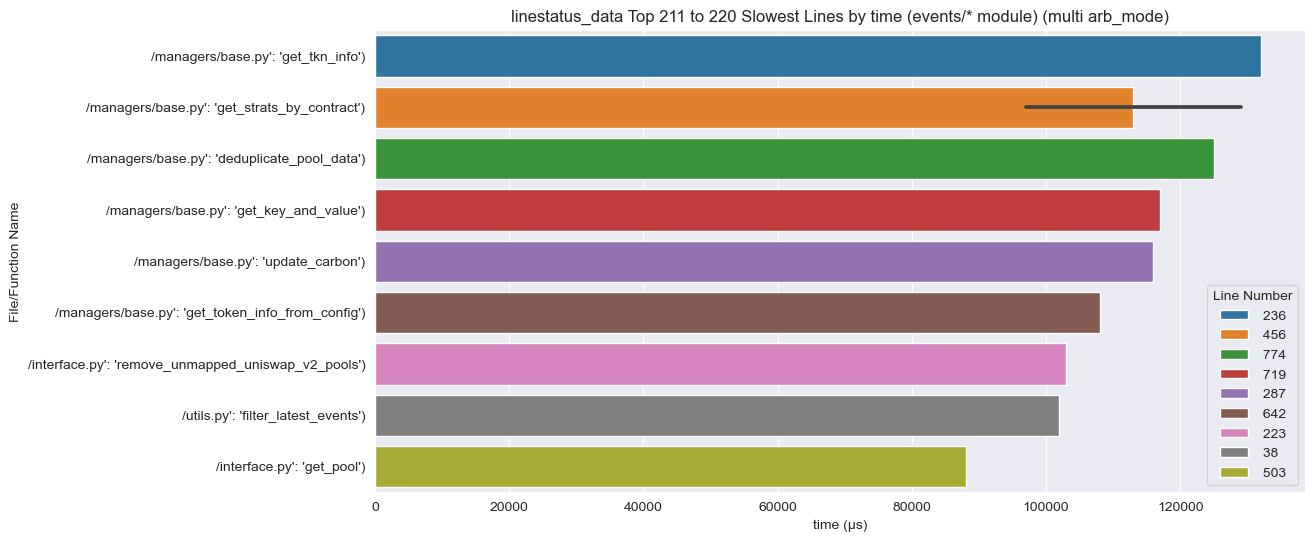

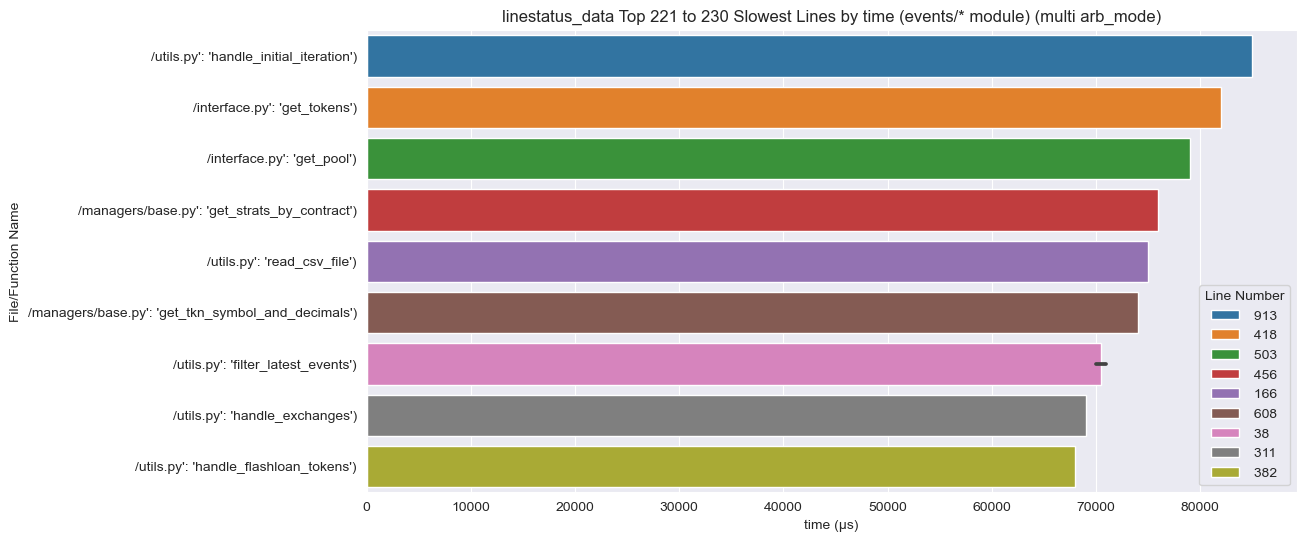

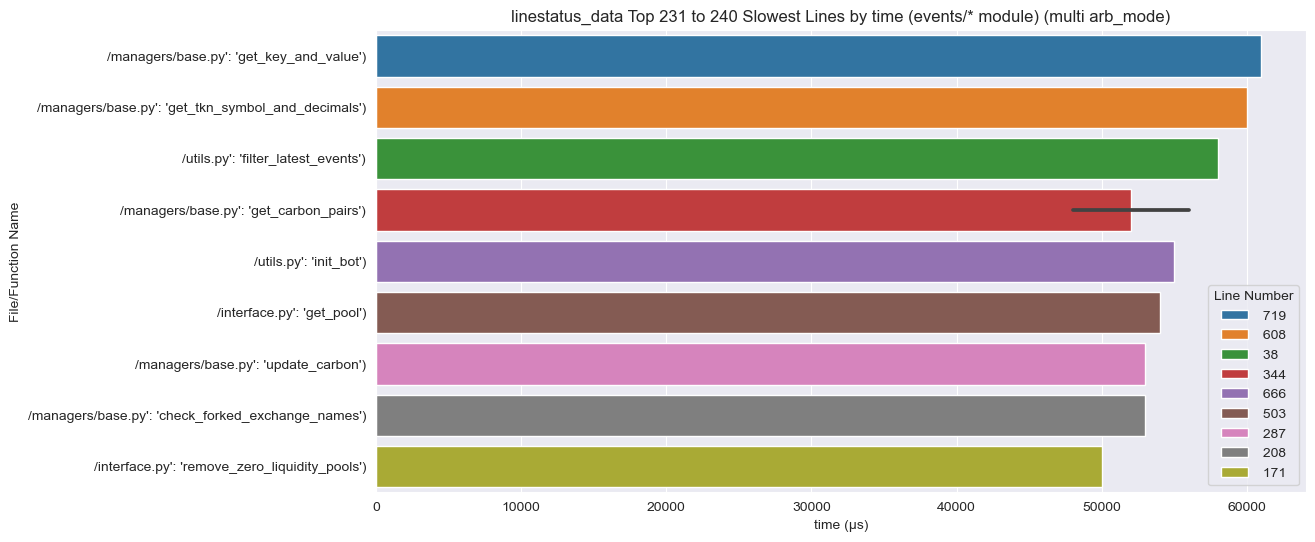

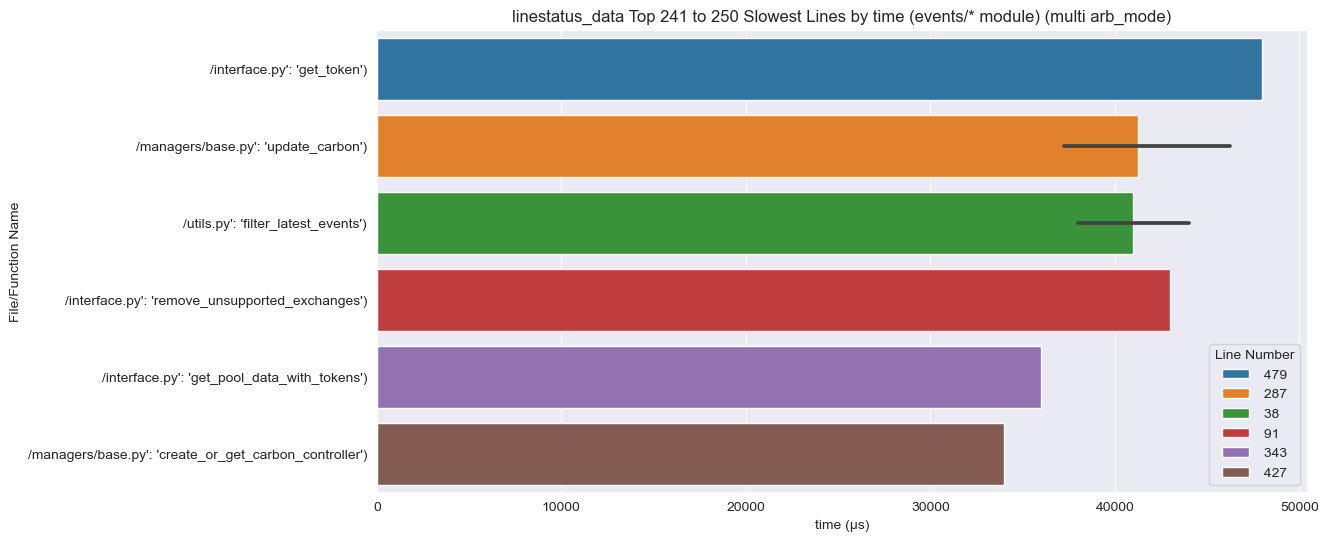

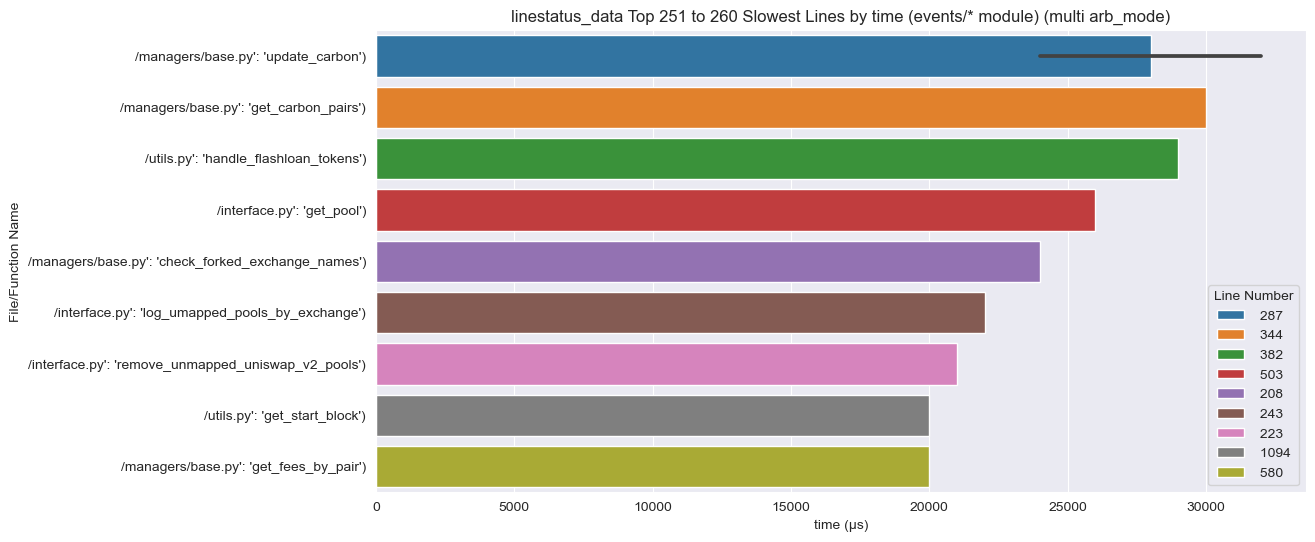

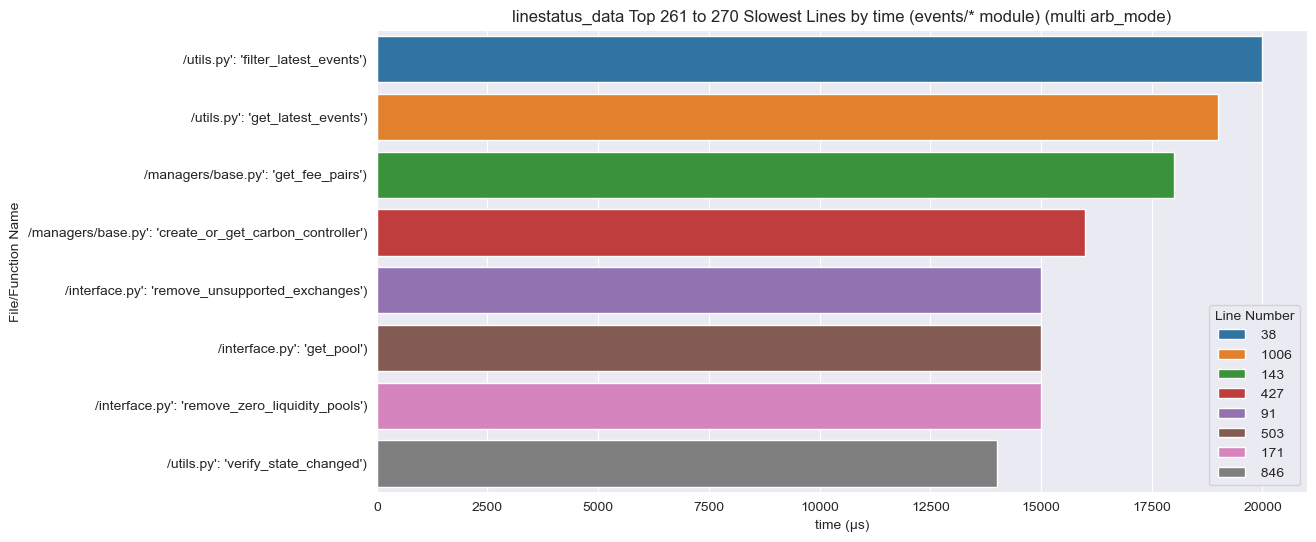

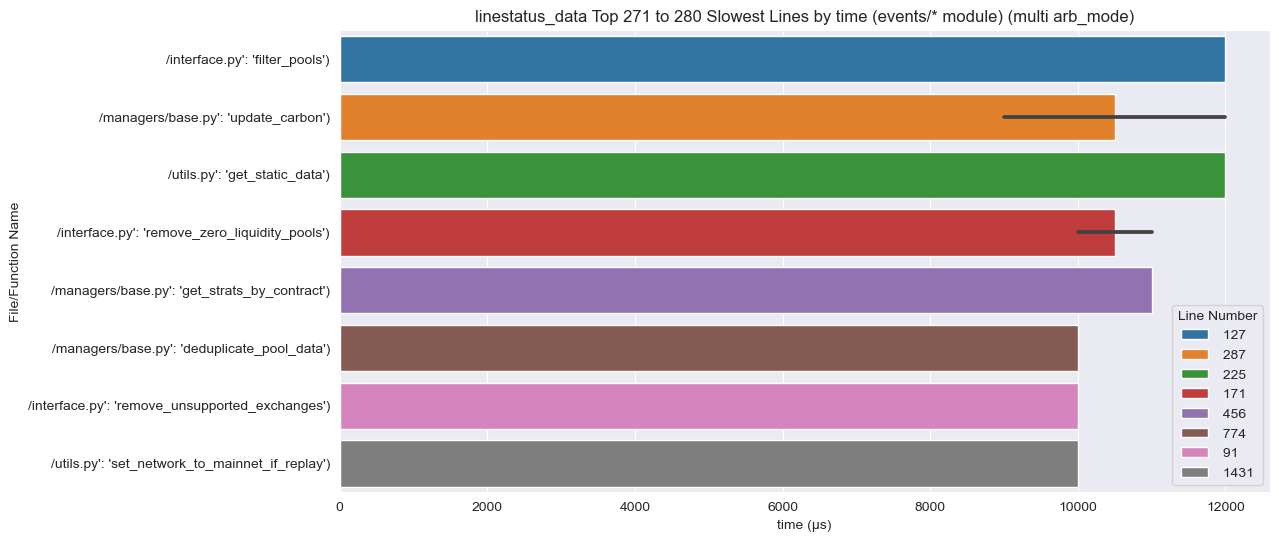

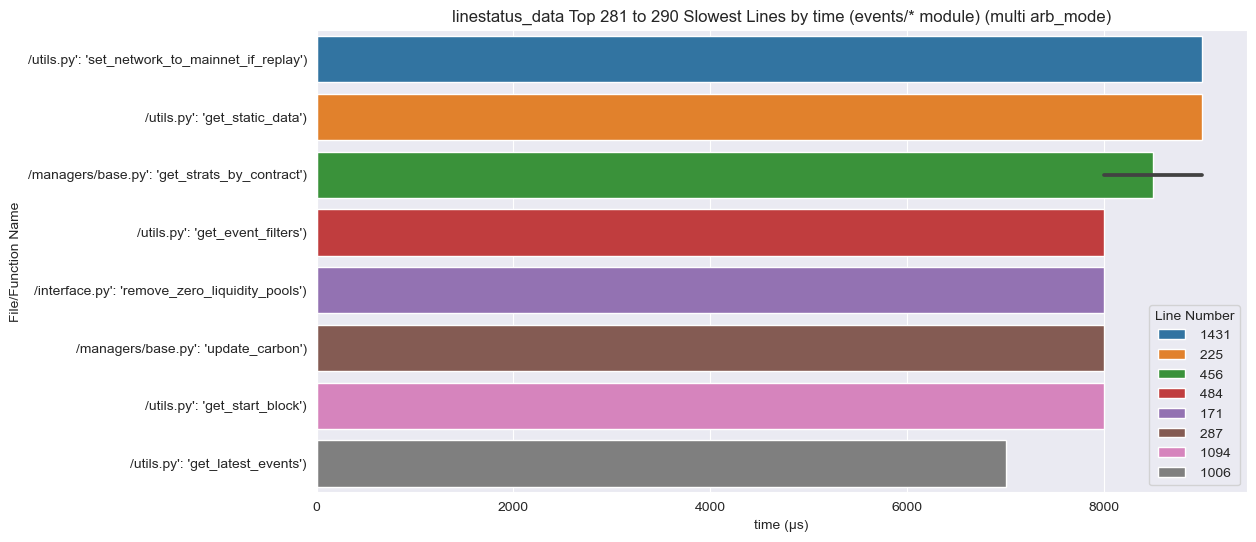

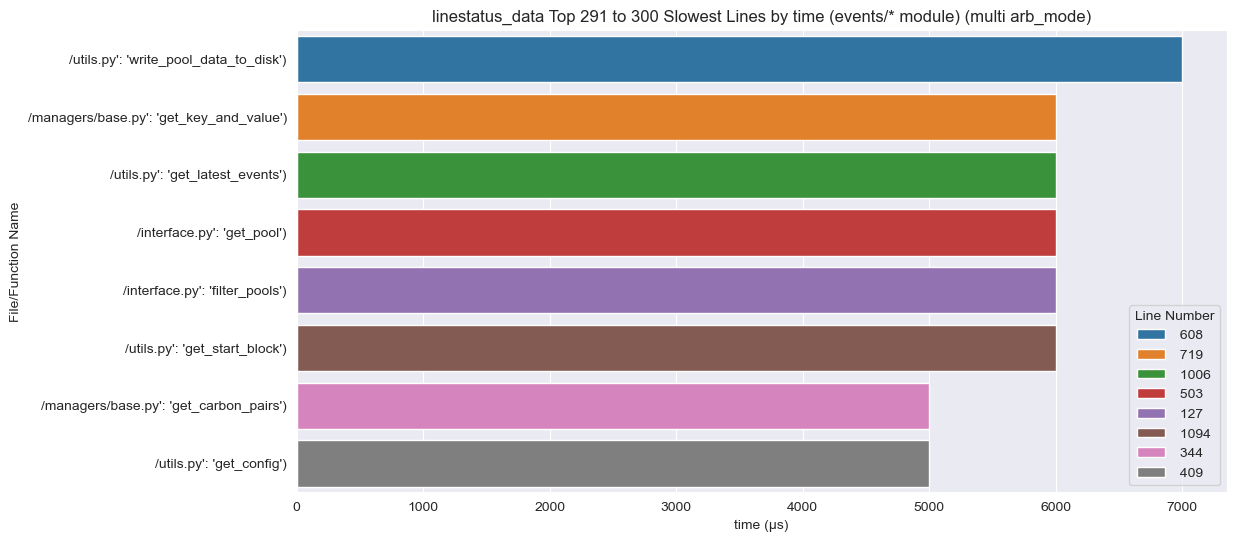

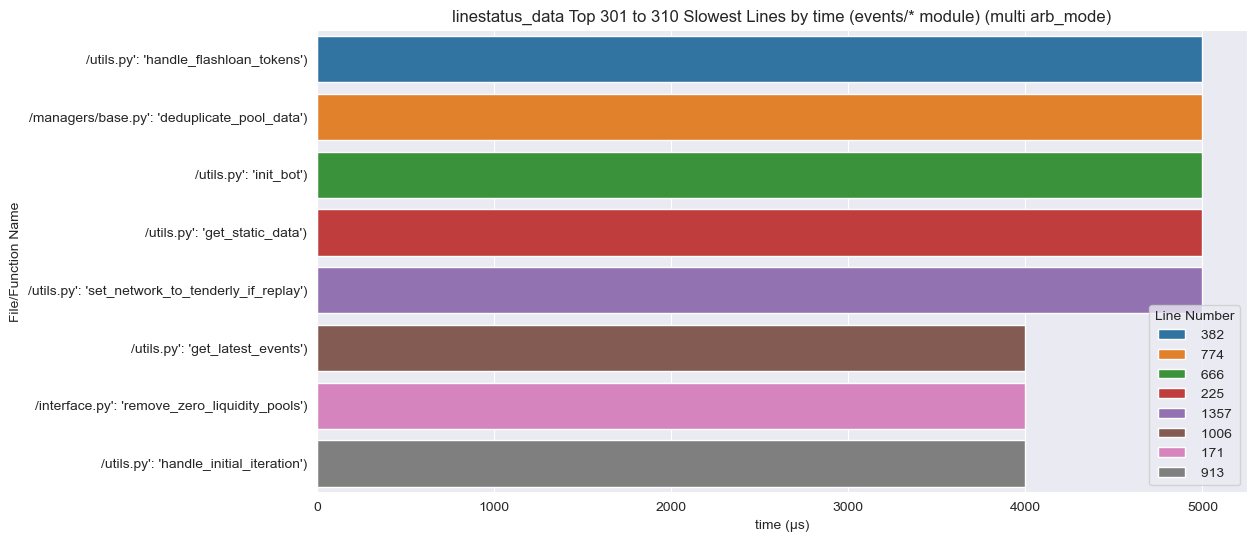

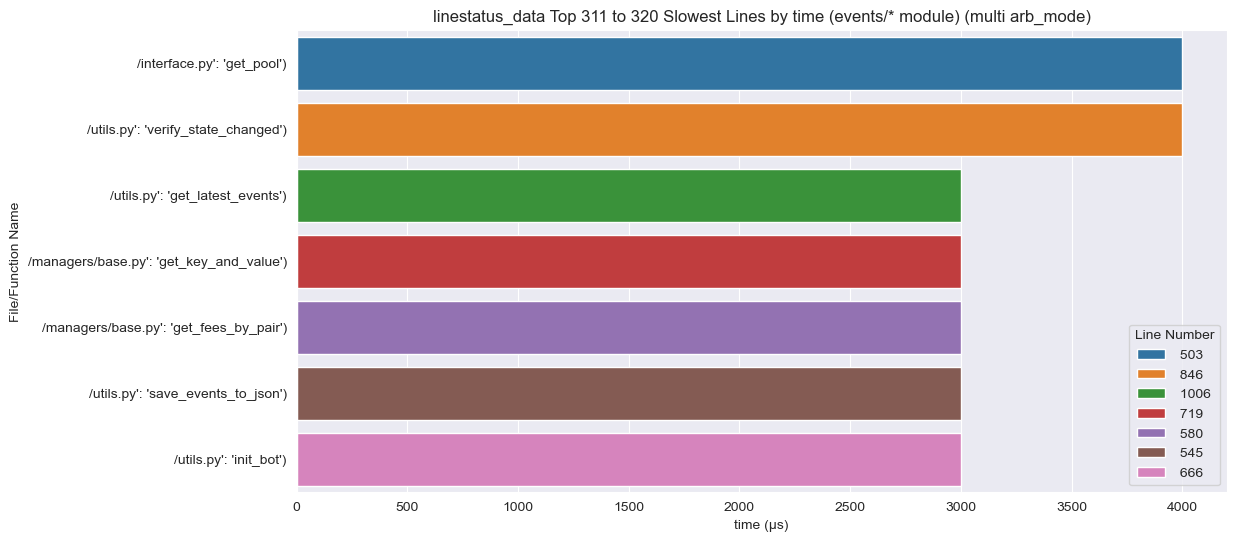

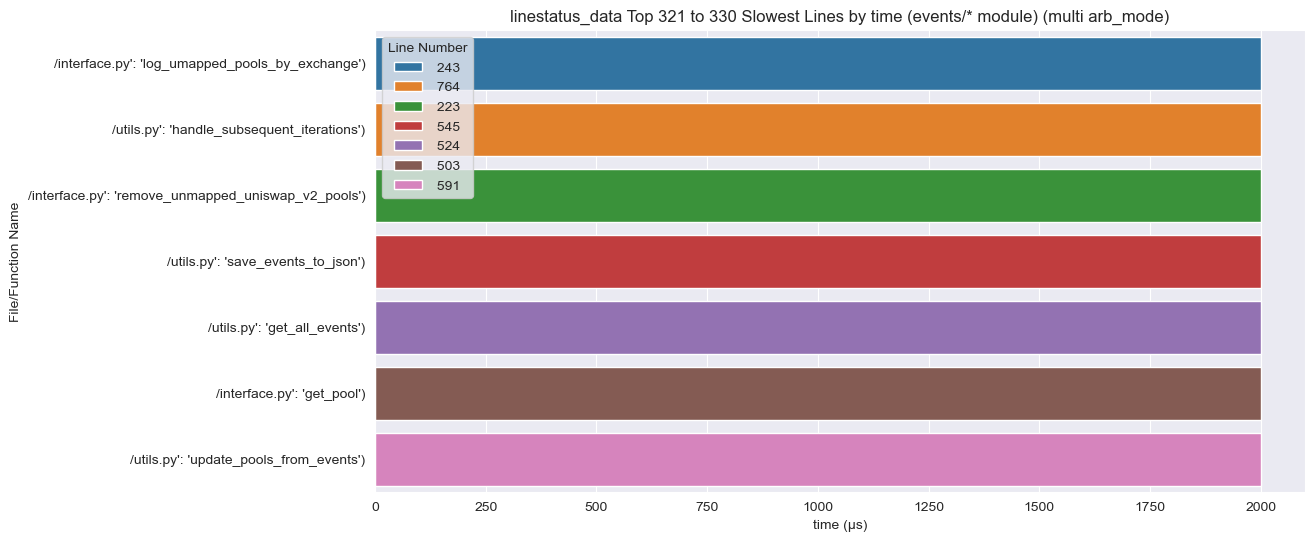

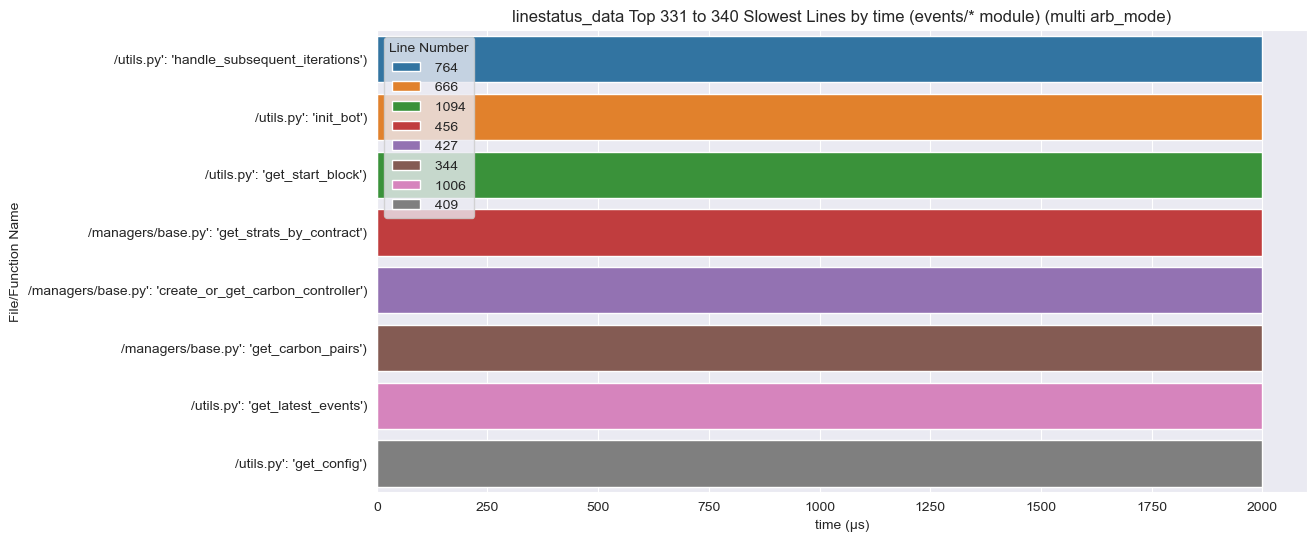

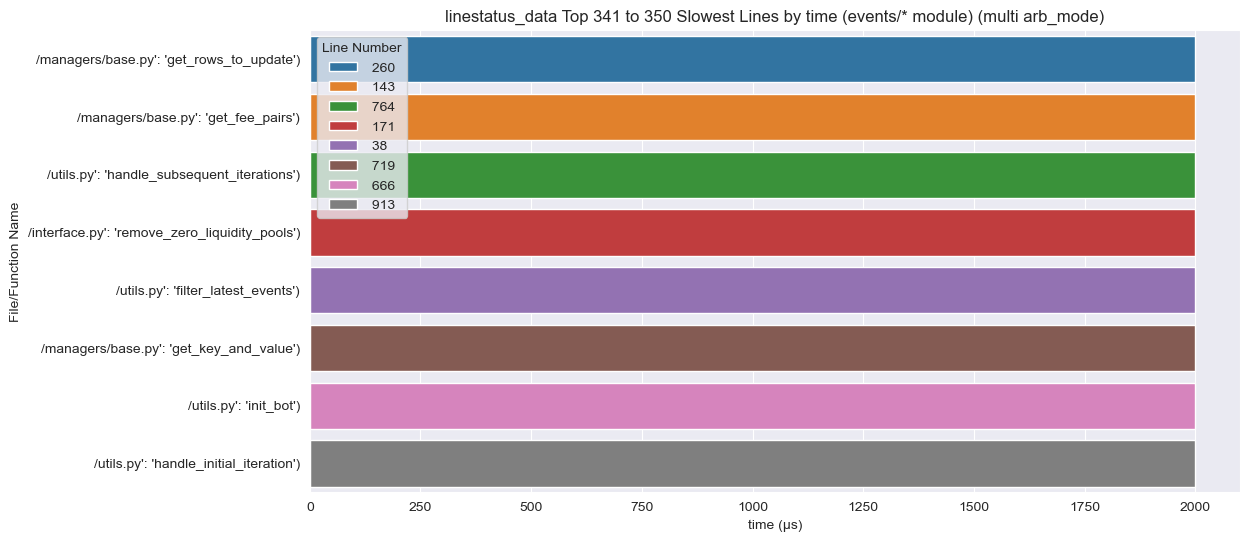

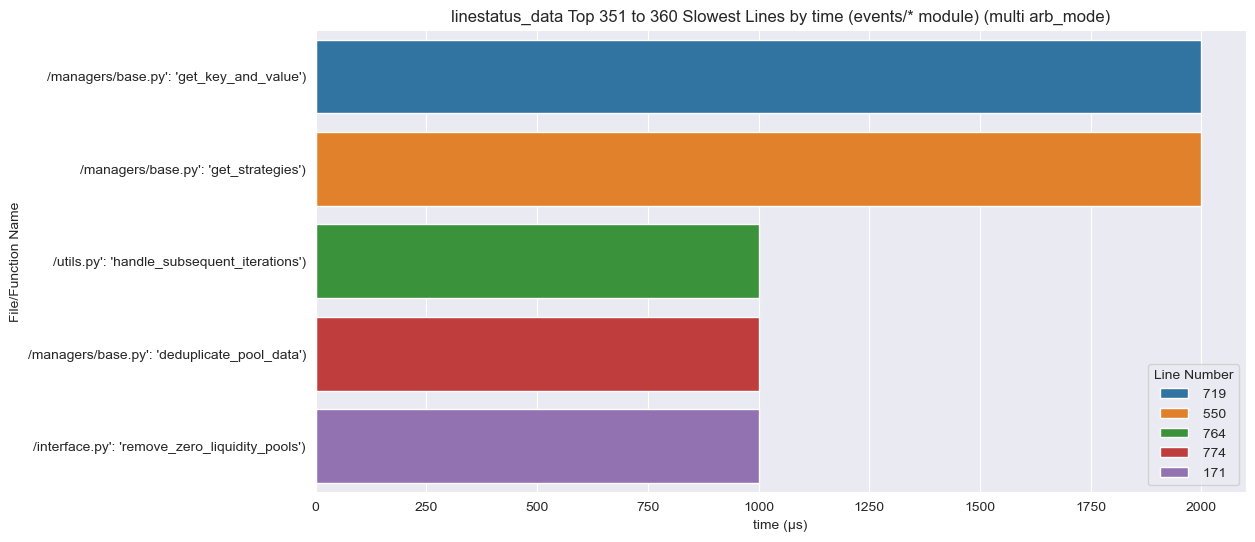

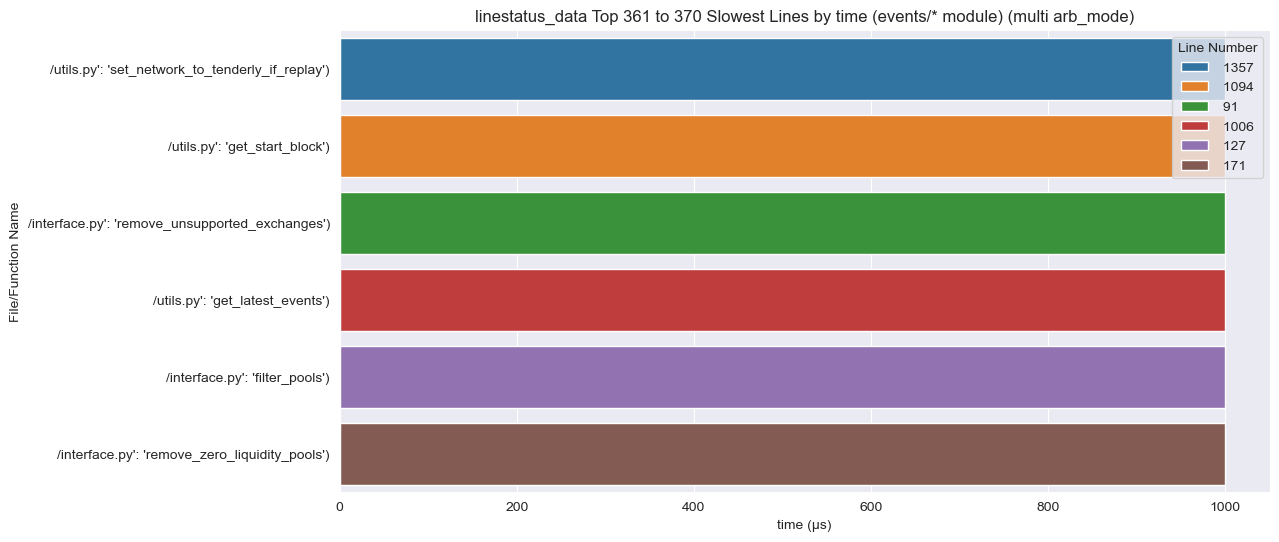

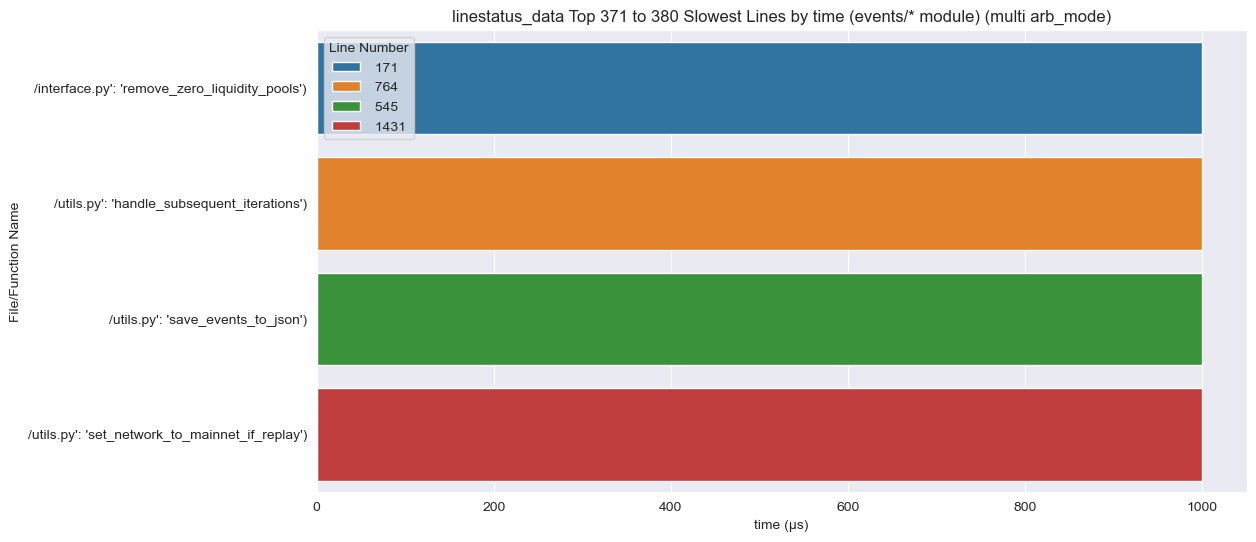

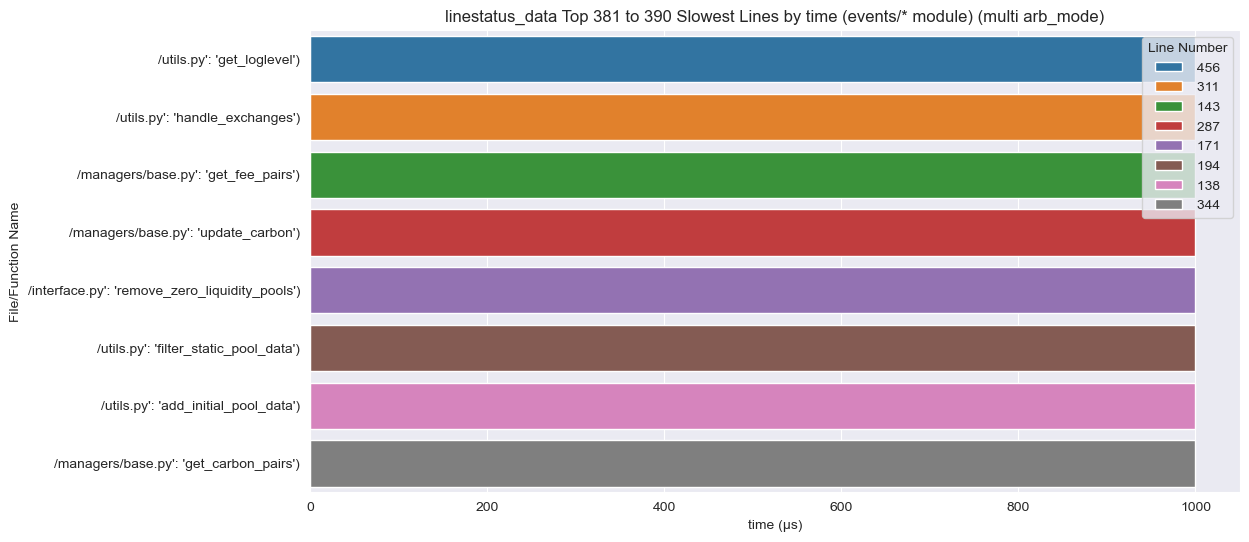

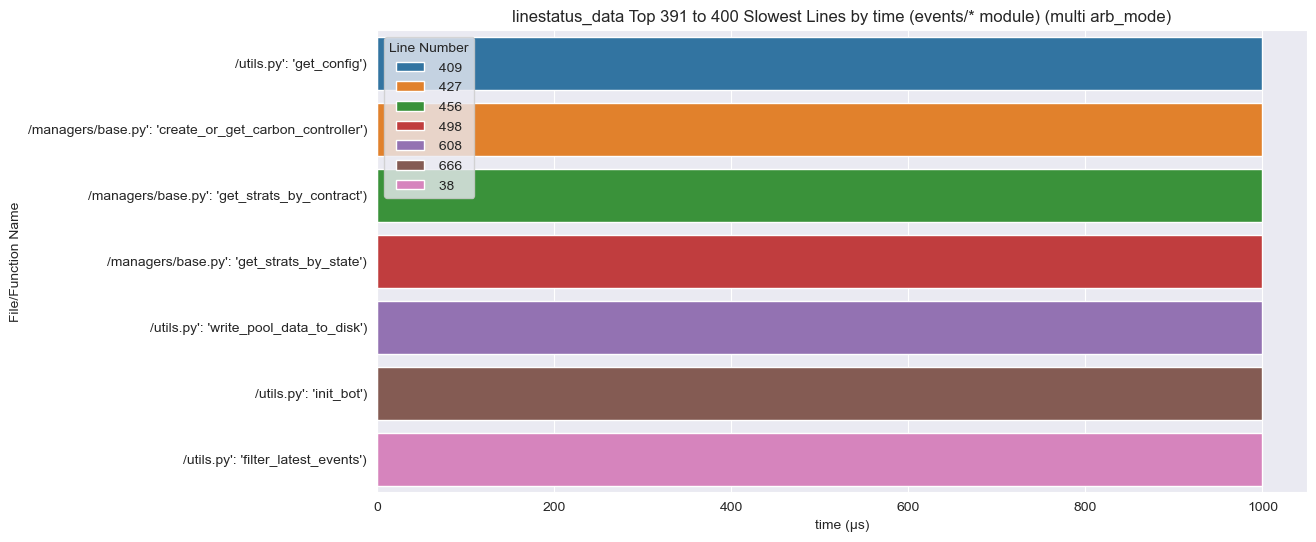

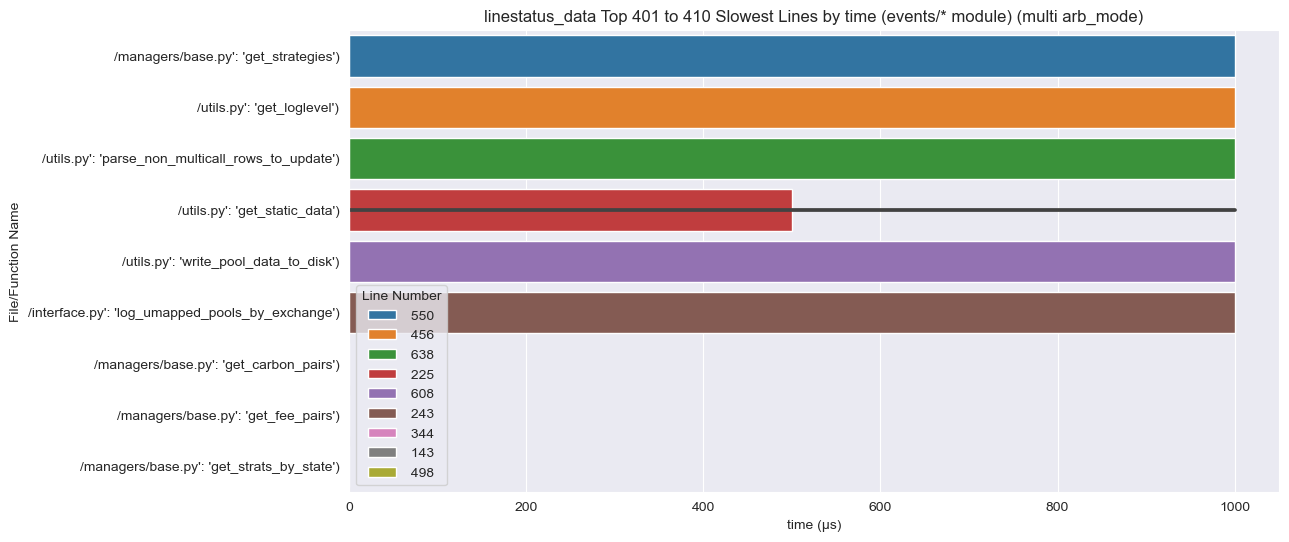

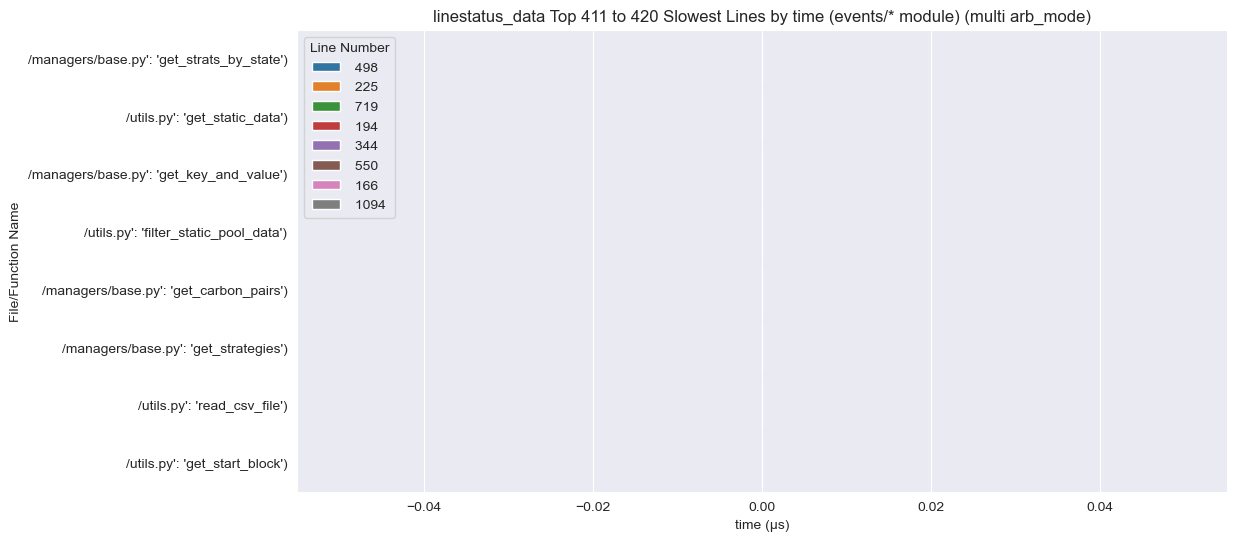

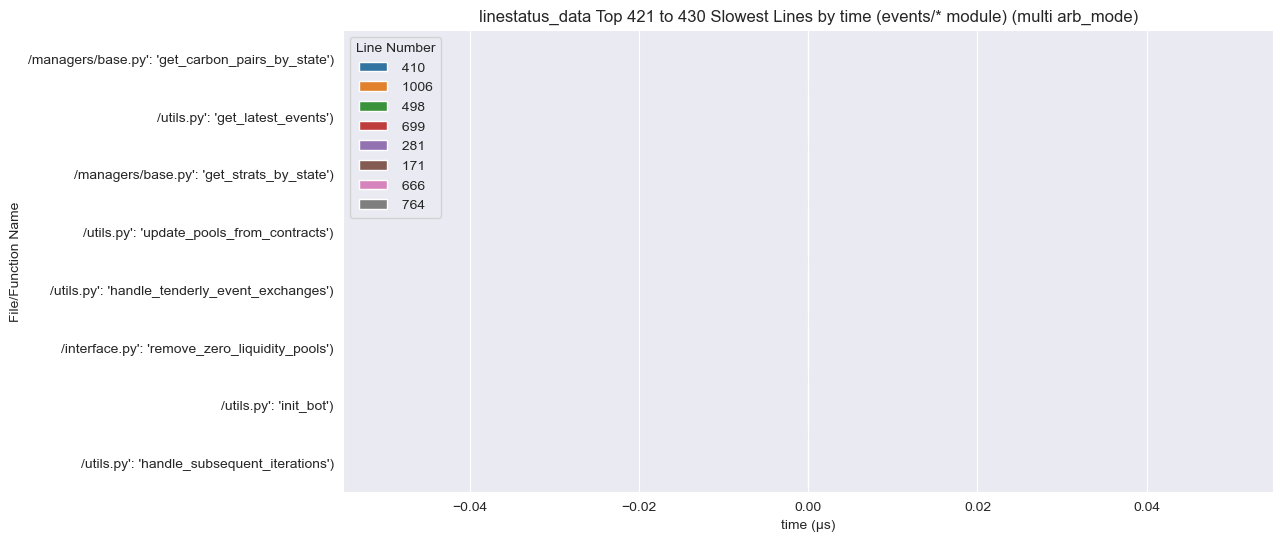

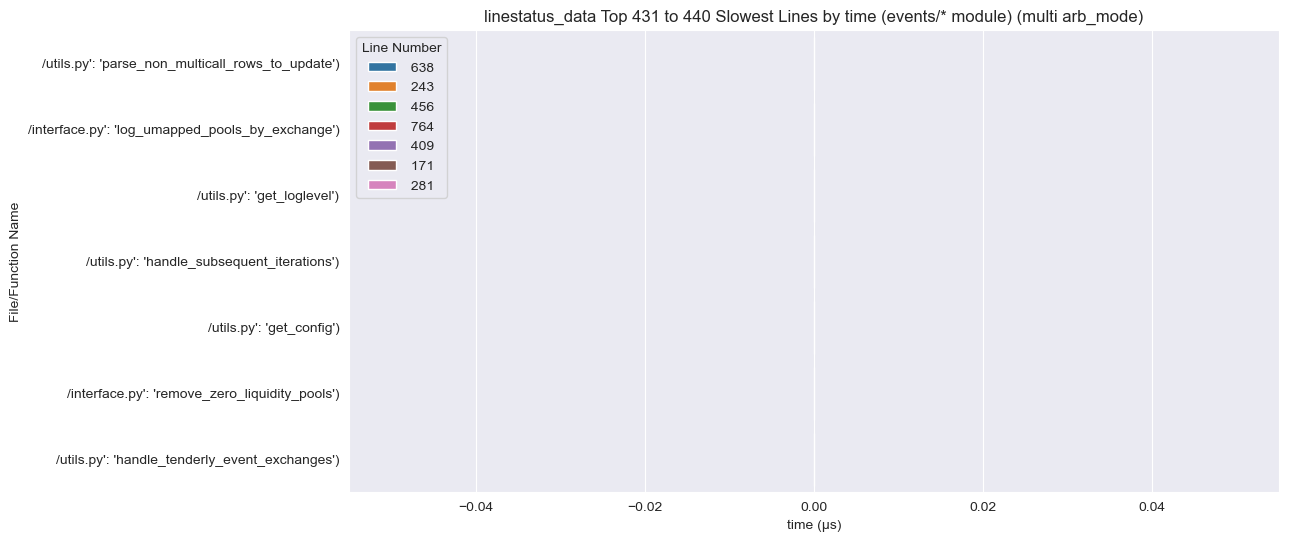

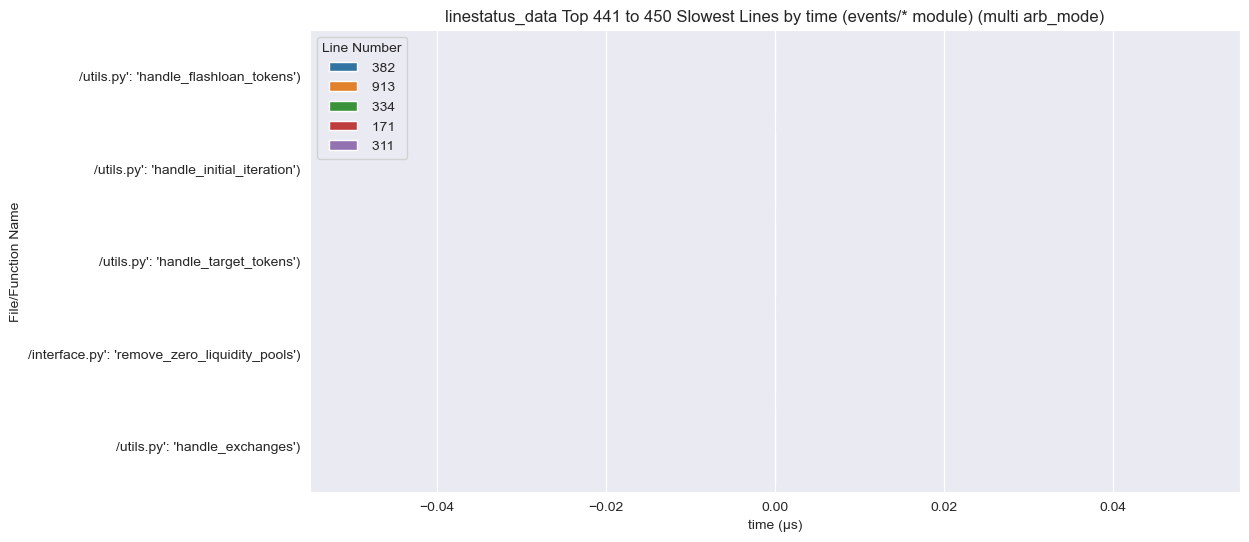

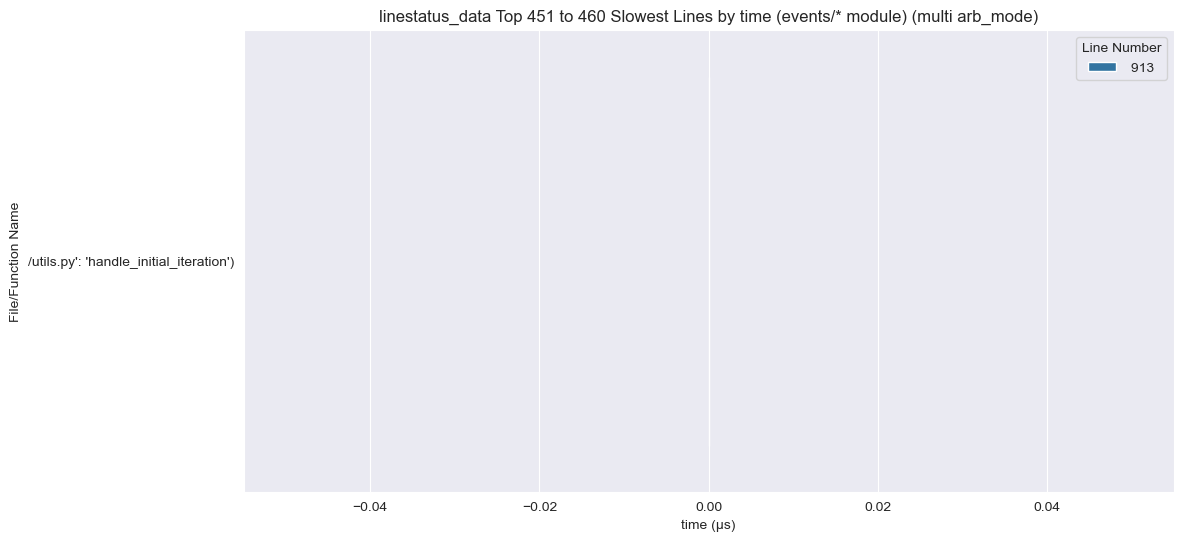

In [5]:
# Analyze events/ module profiling data
module = 'events'
generate_plots(reports, module, 'cprofile_data')
generate_plots(reports, module, 'linestatus_data')


### Analyze tools/ module profiling data

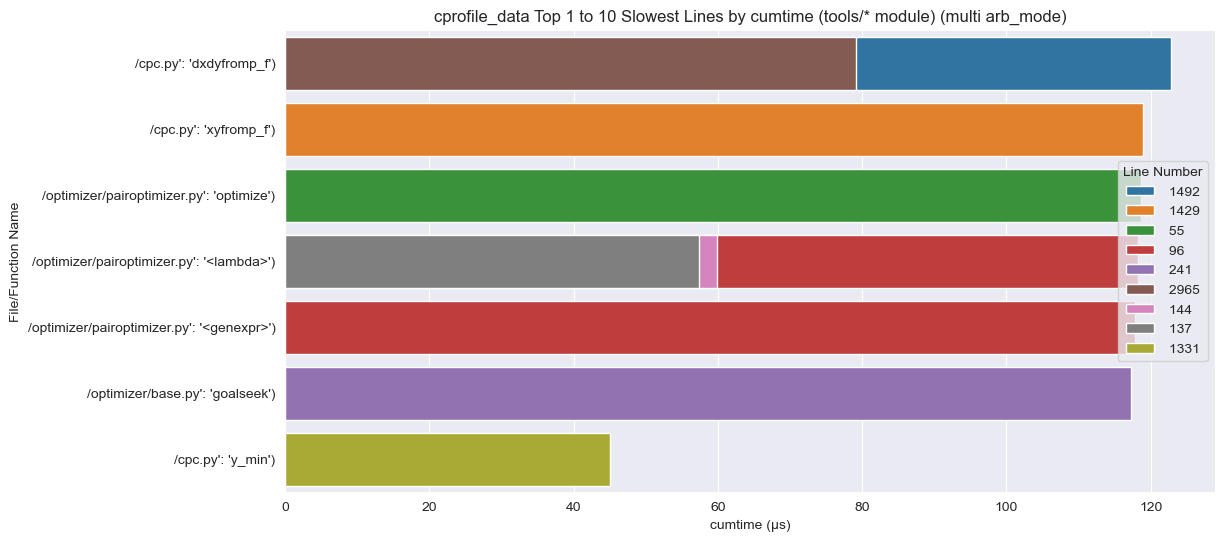

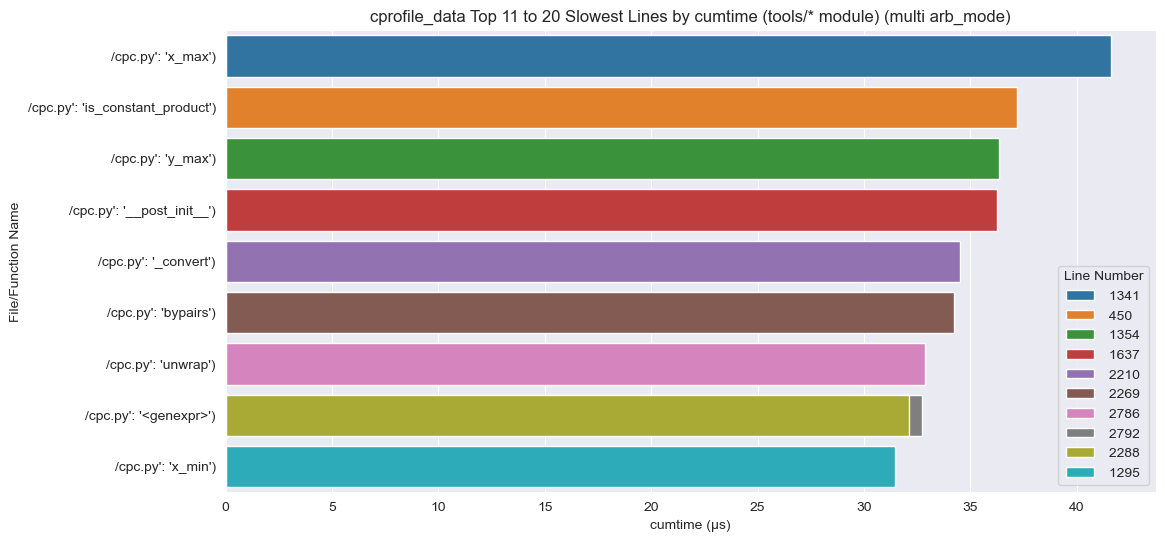

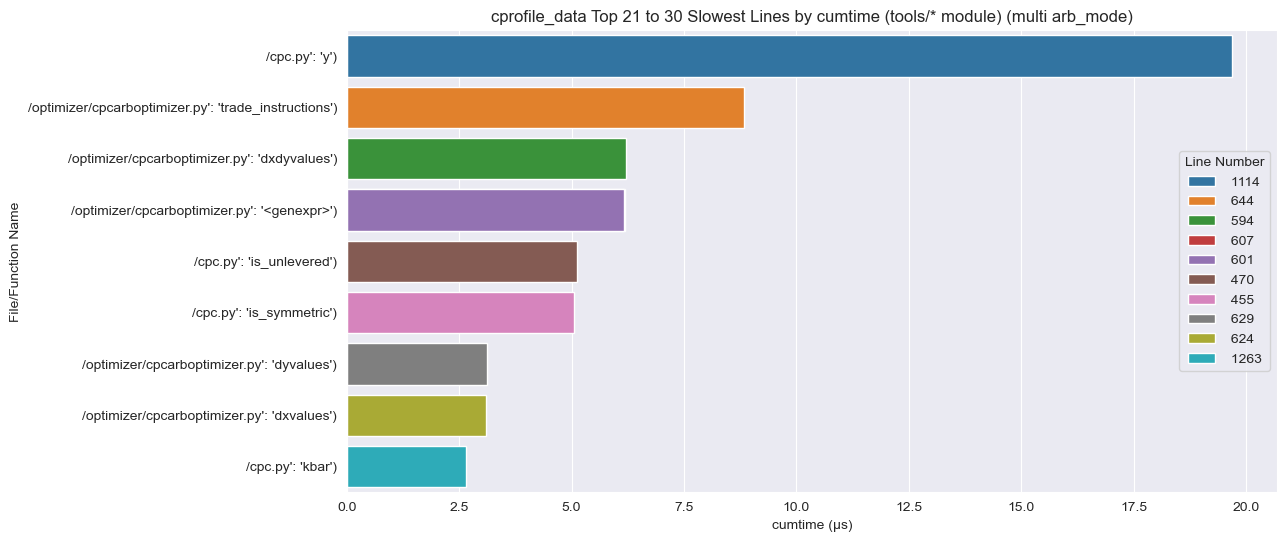

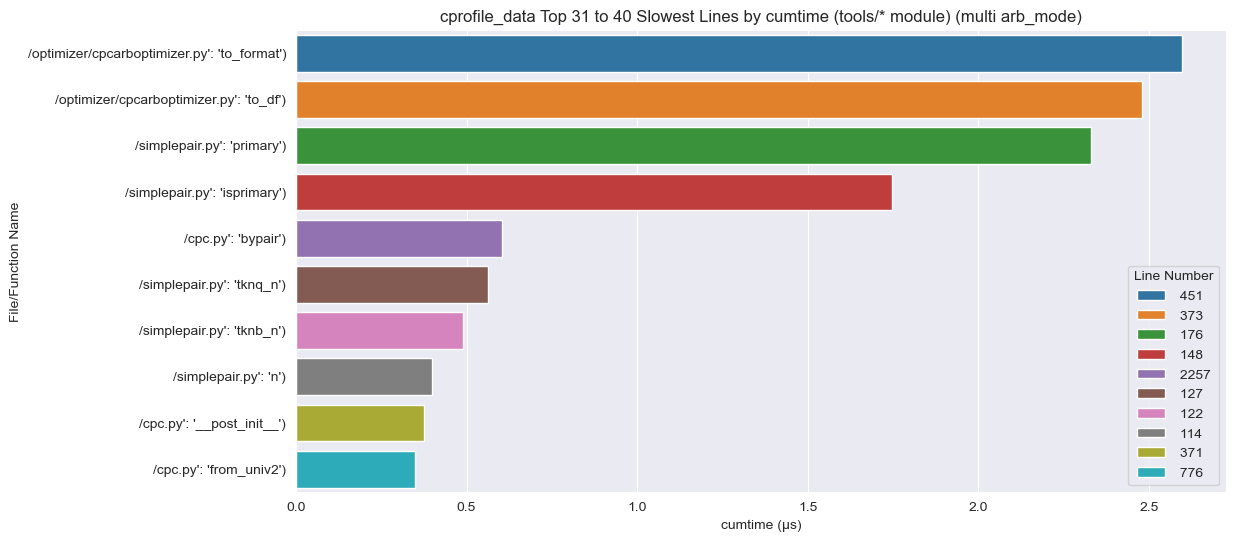

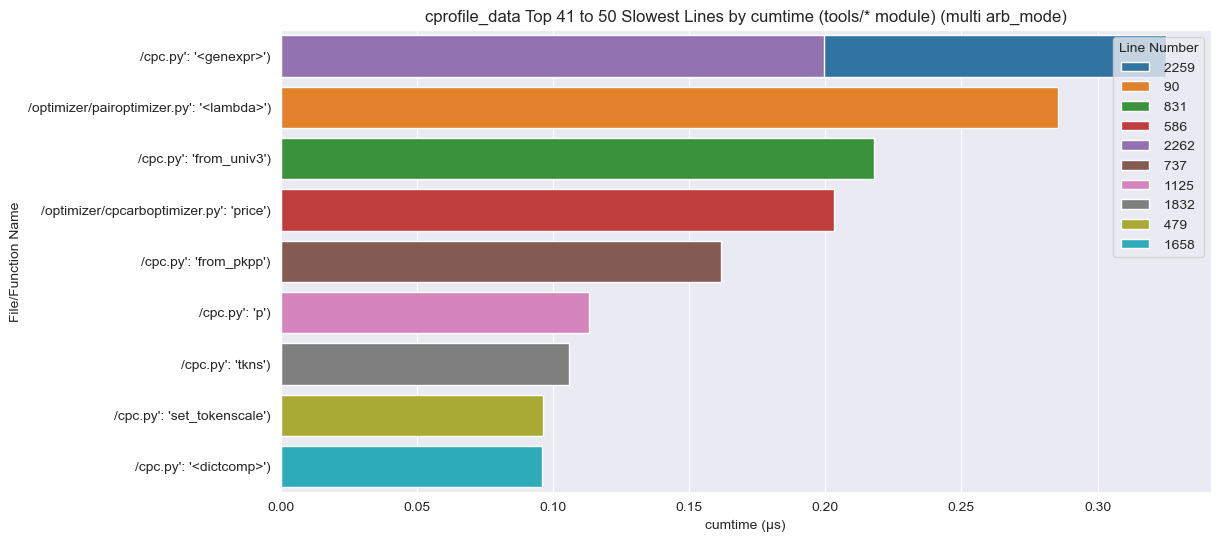

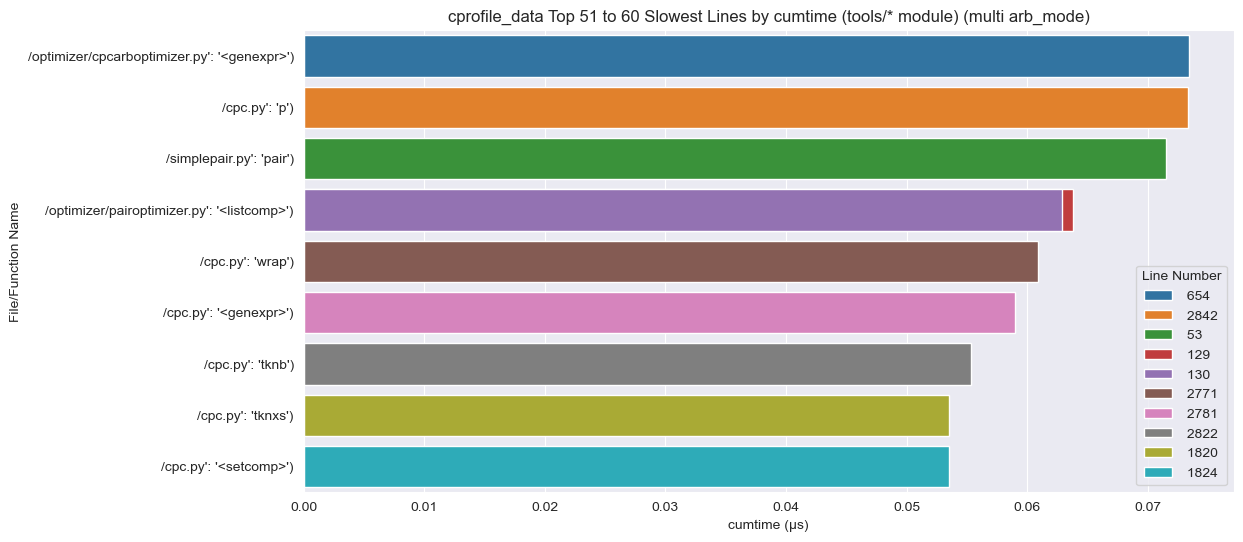

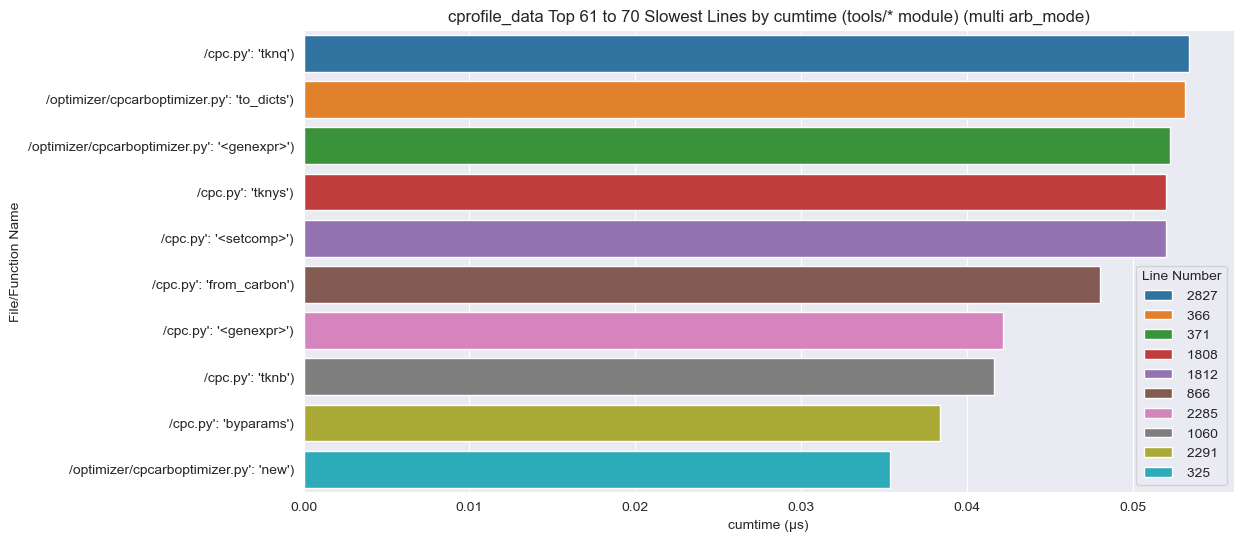

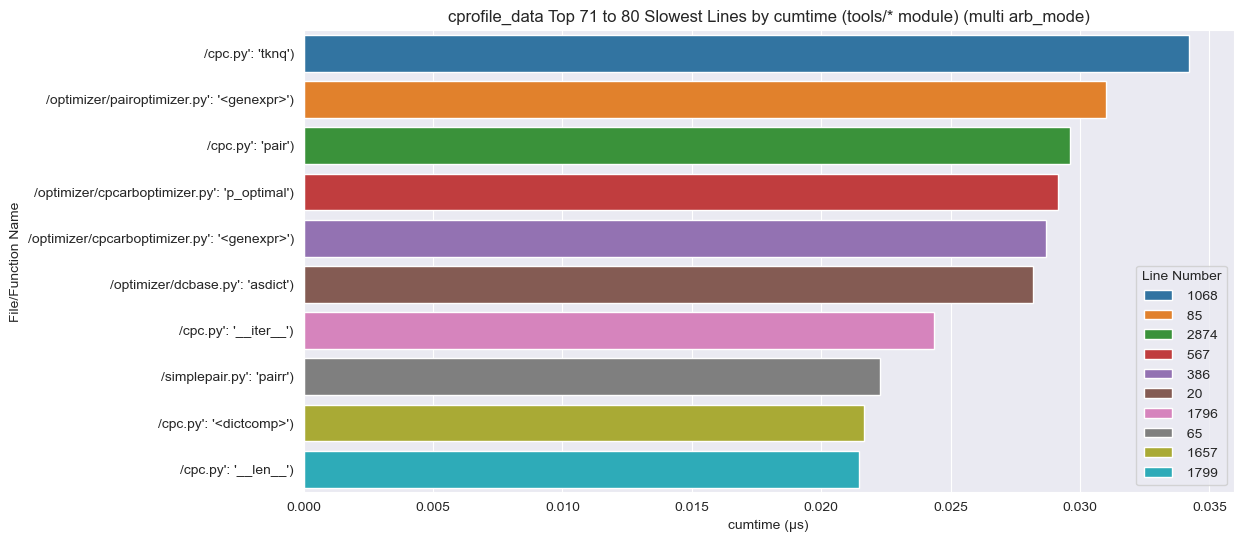

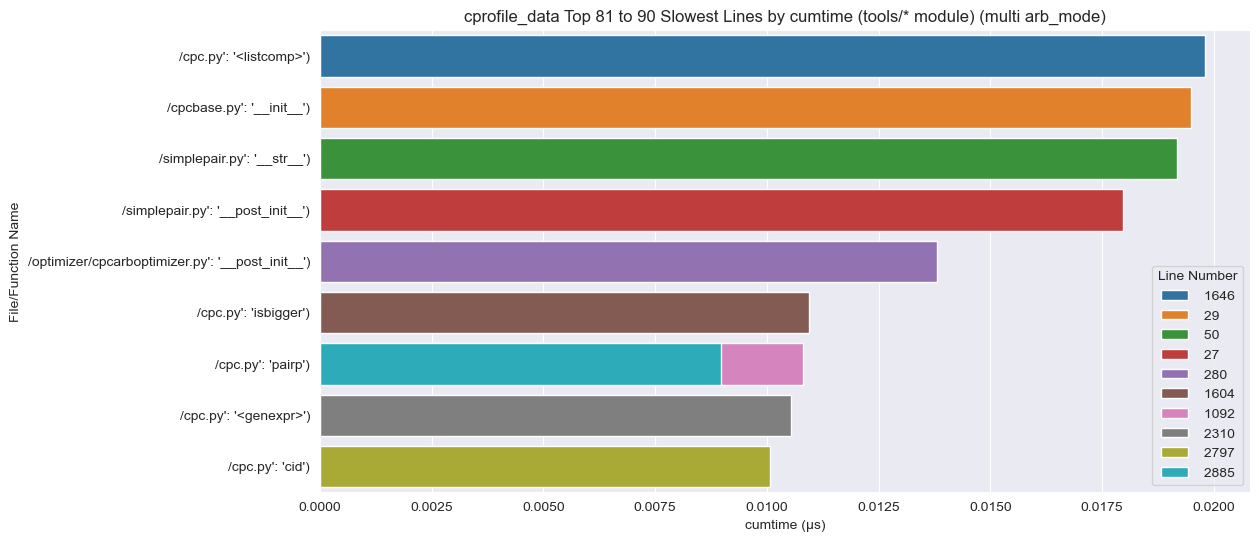

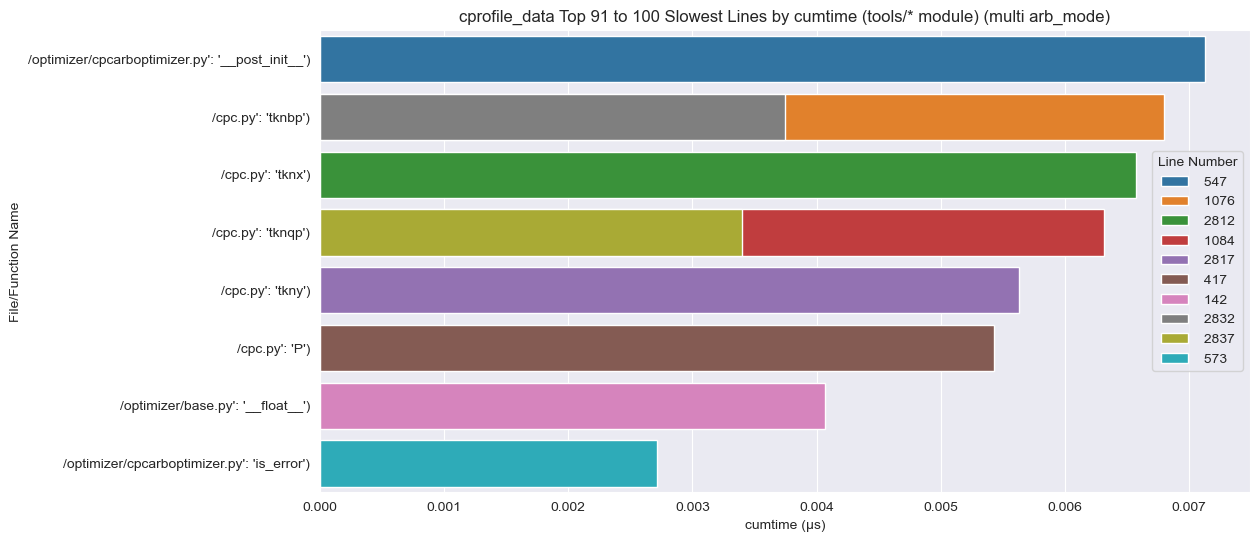

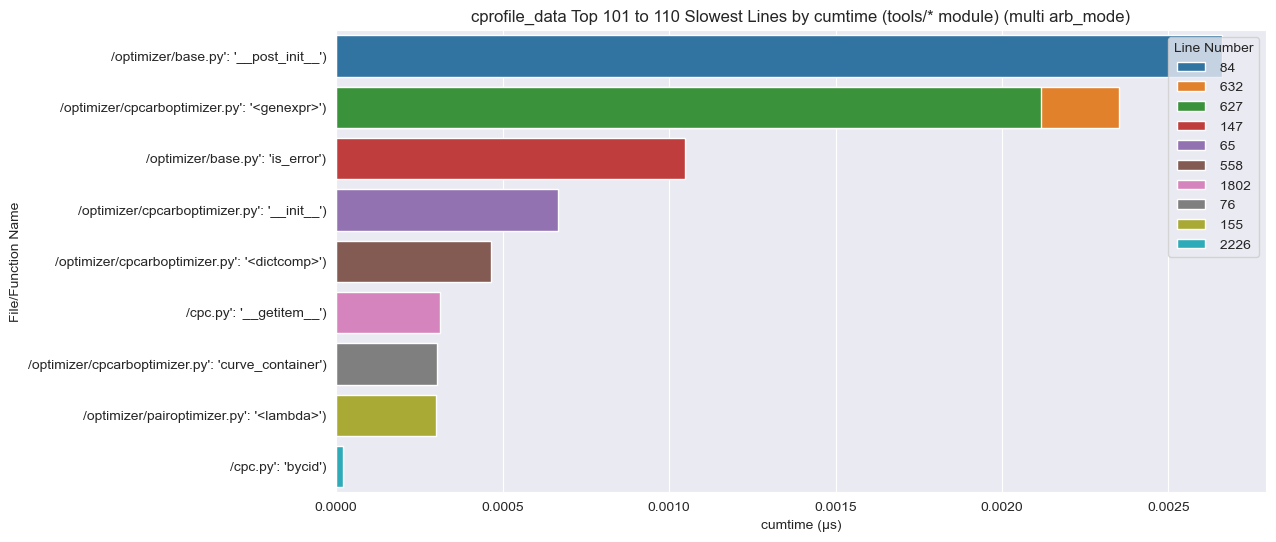

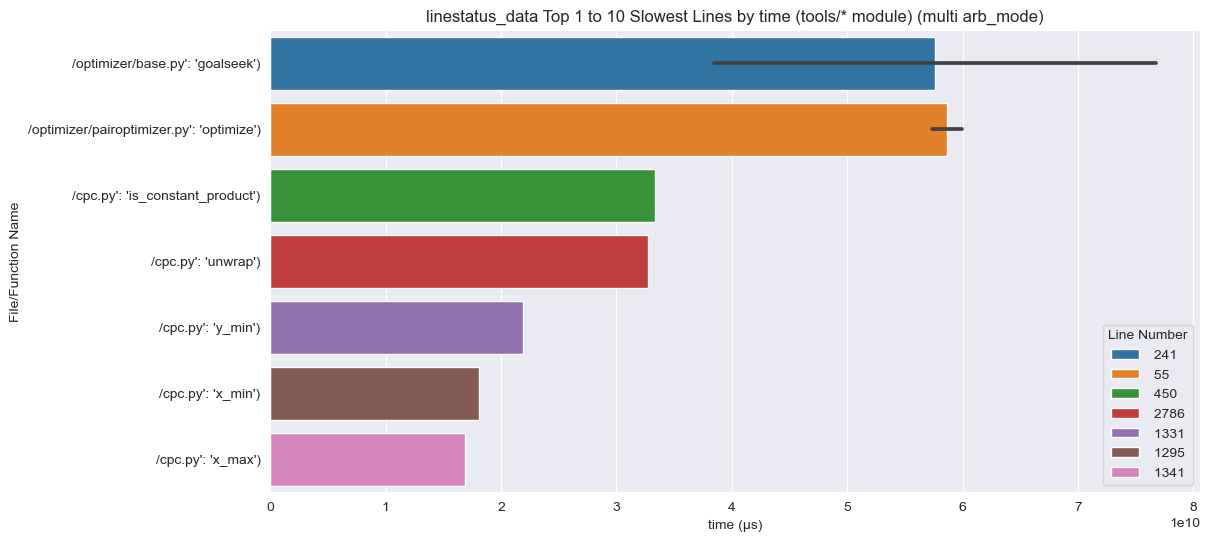

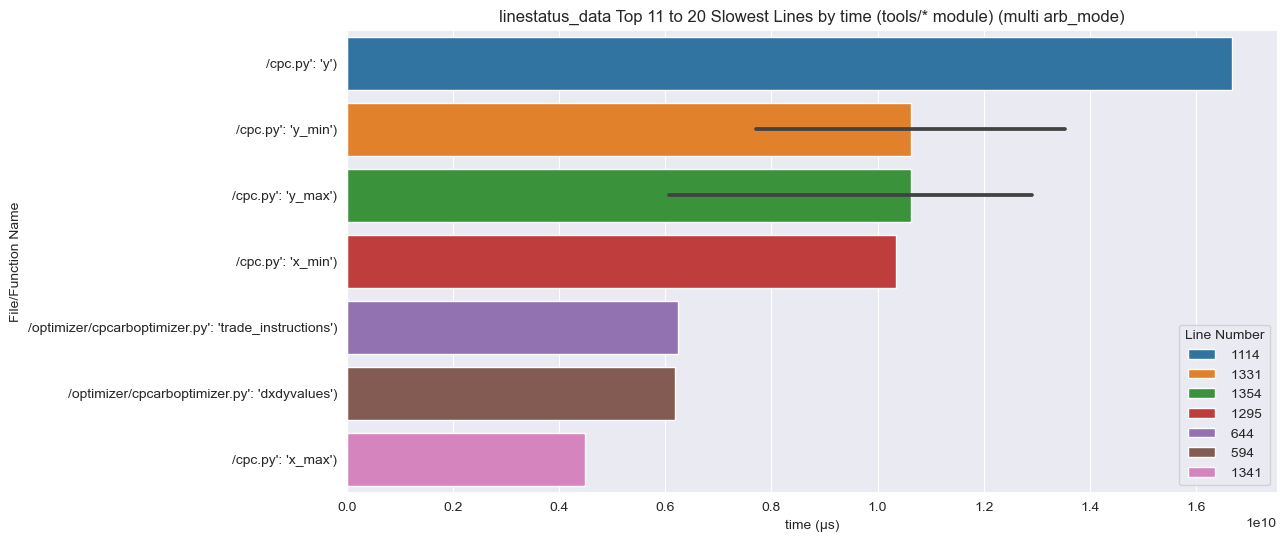

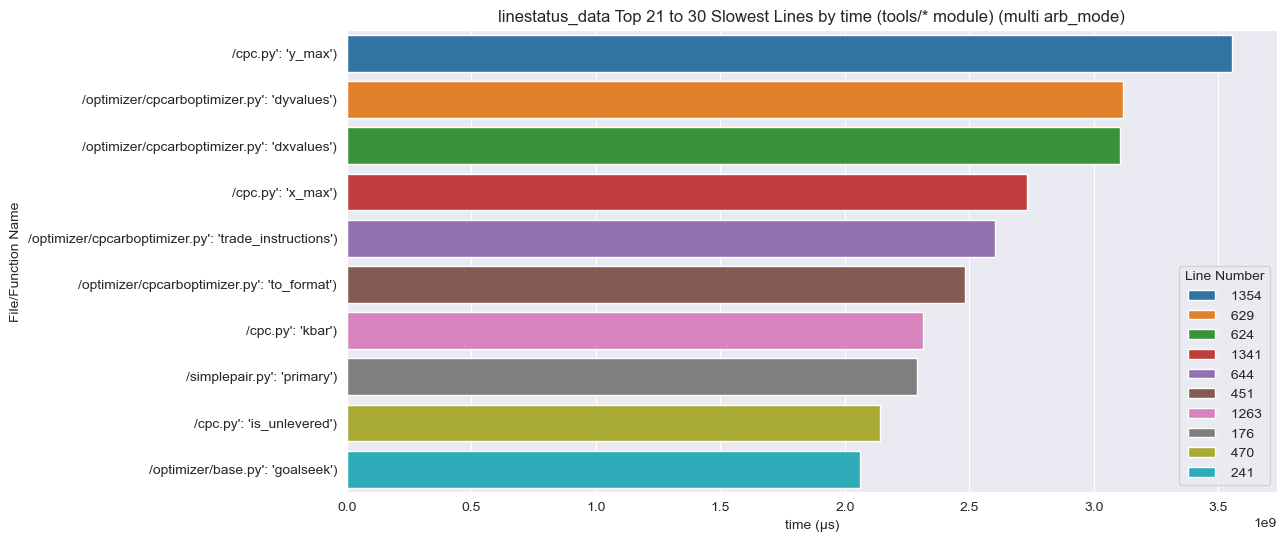

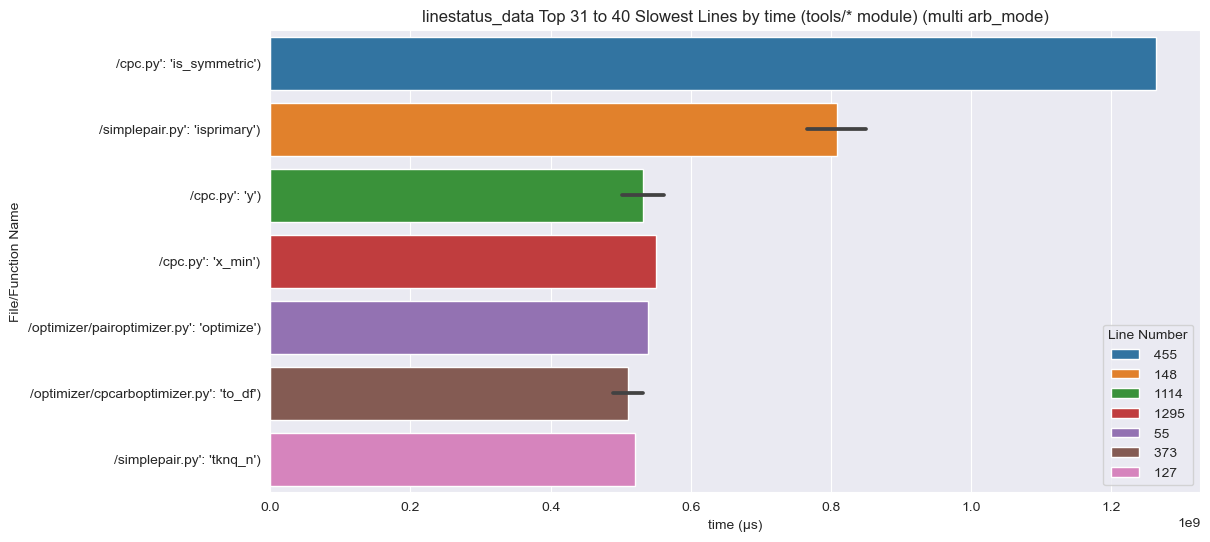

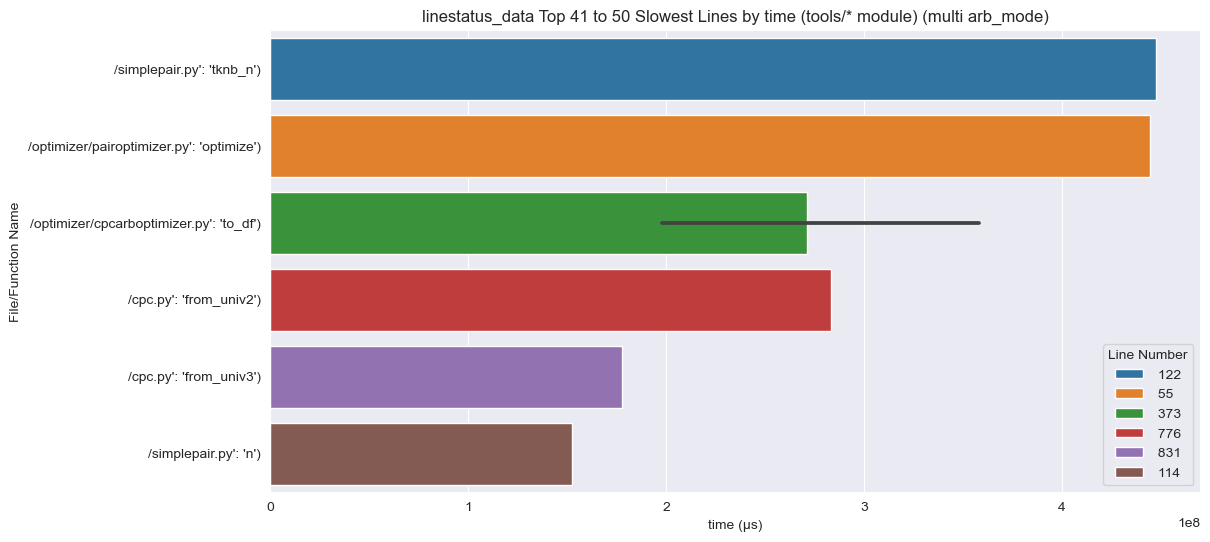

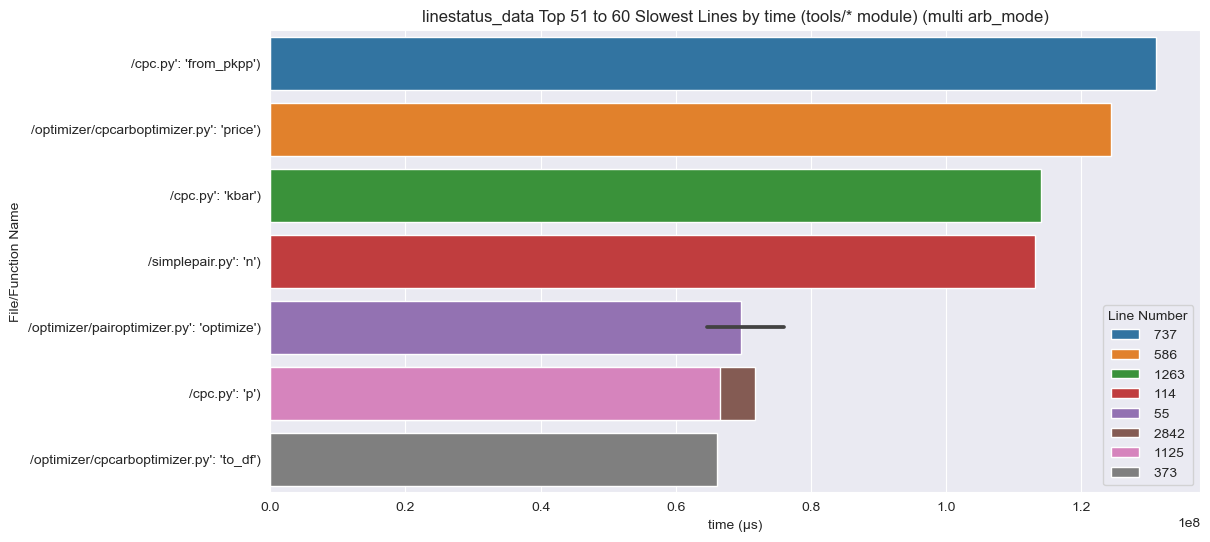

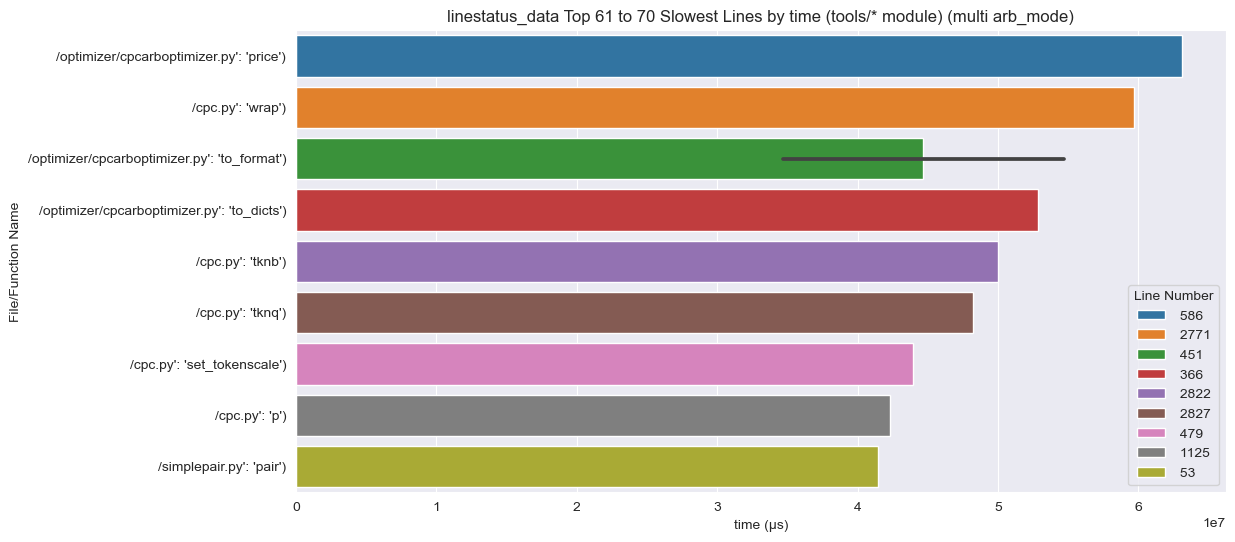

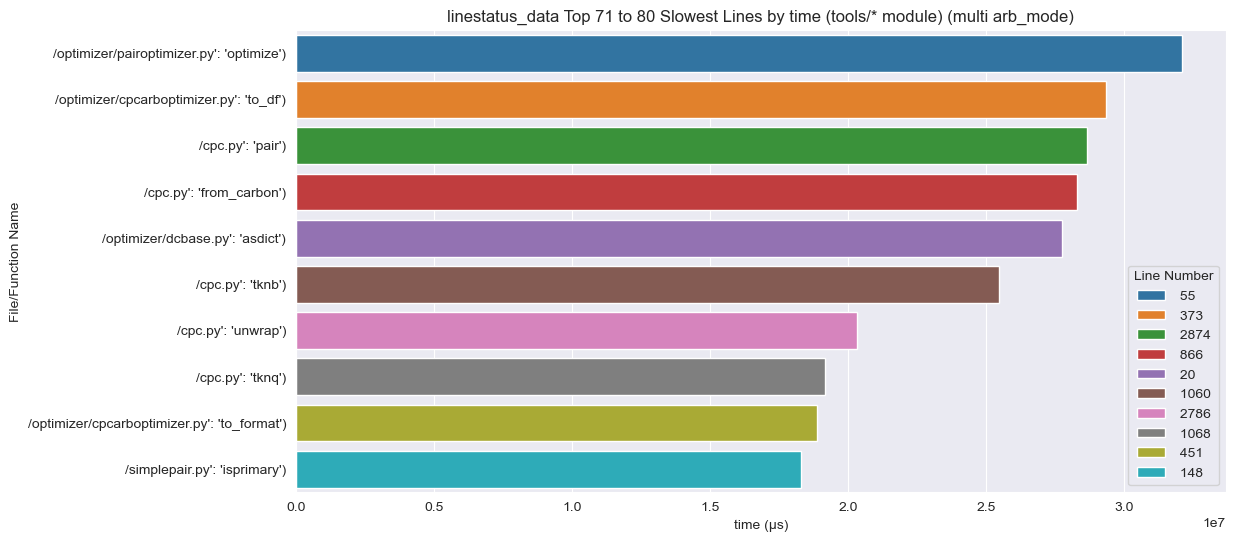

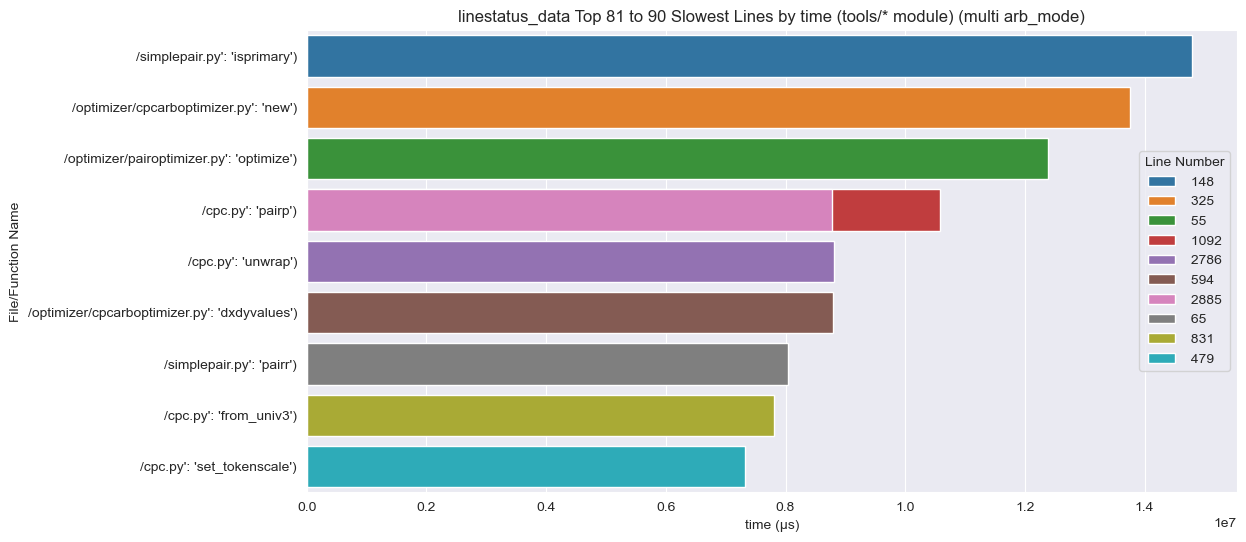

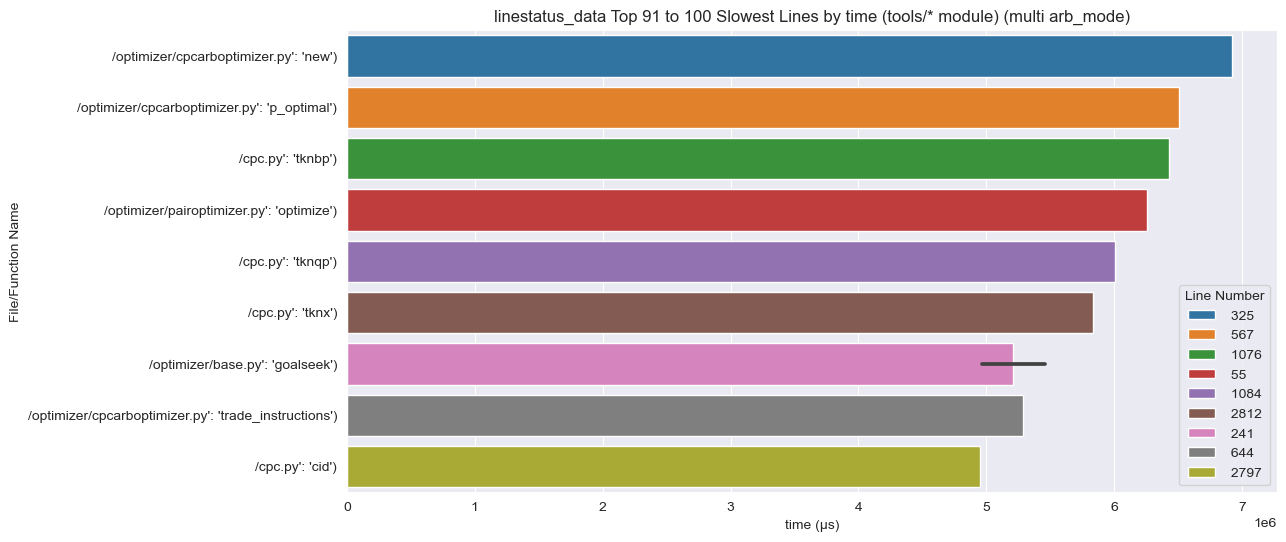

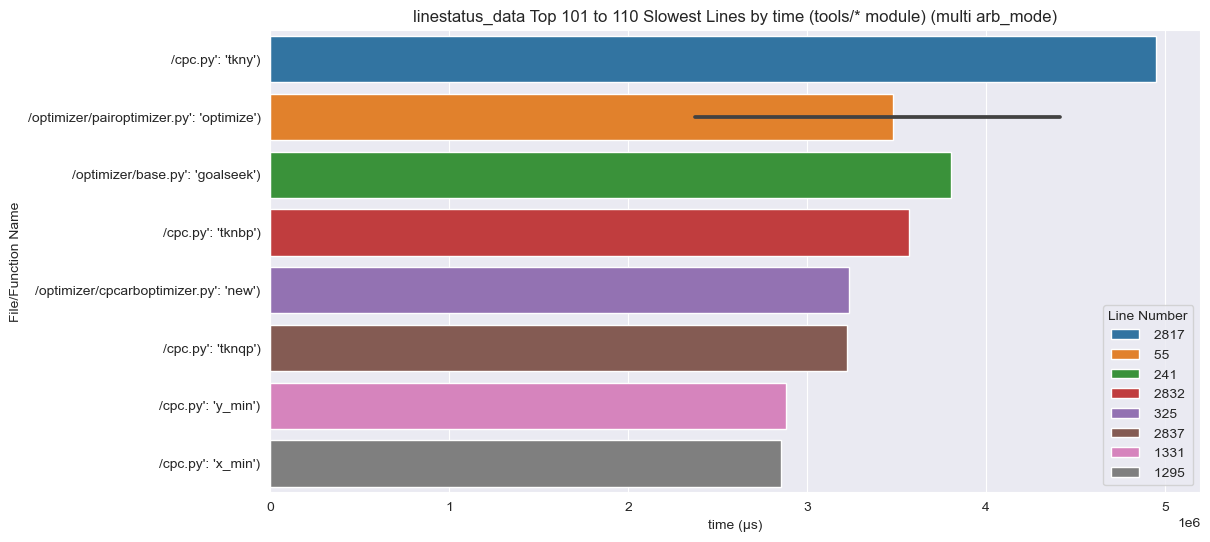

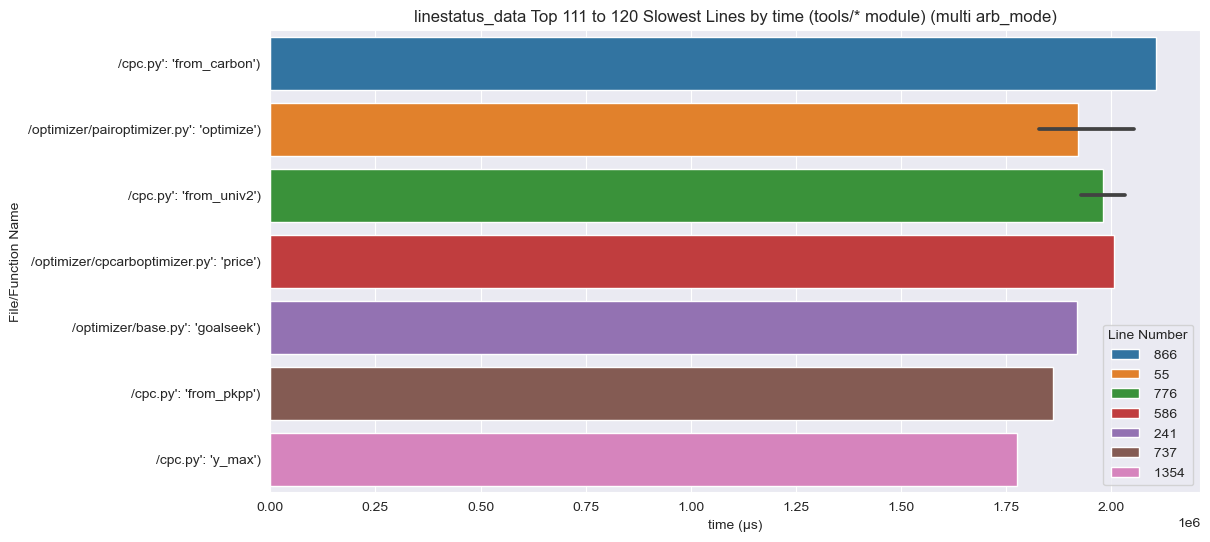

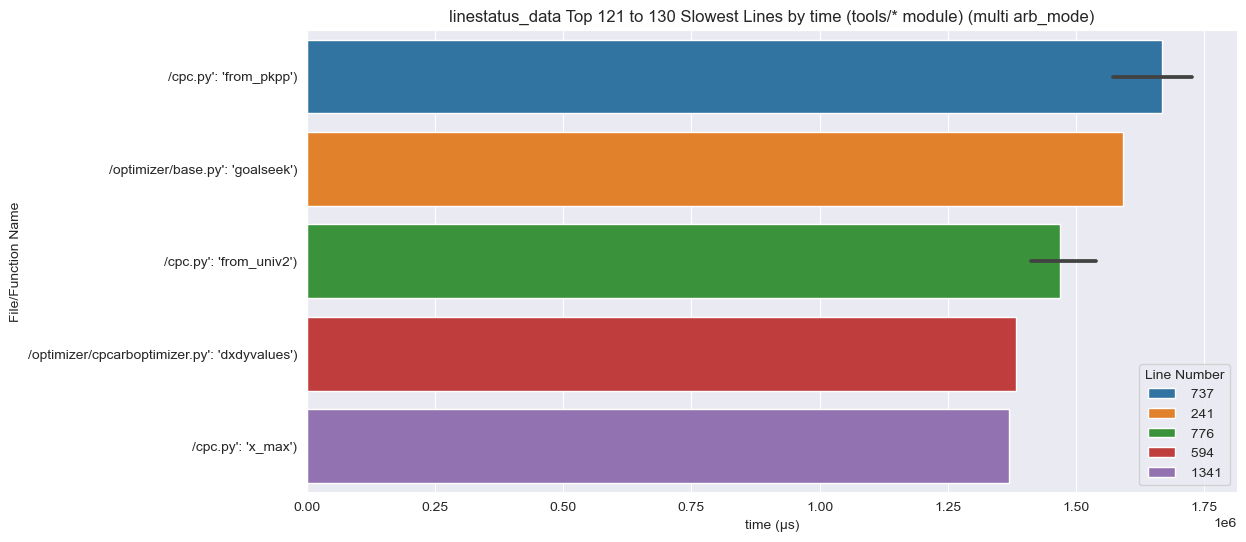

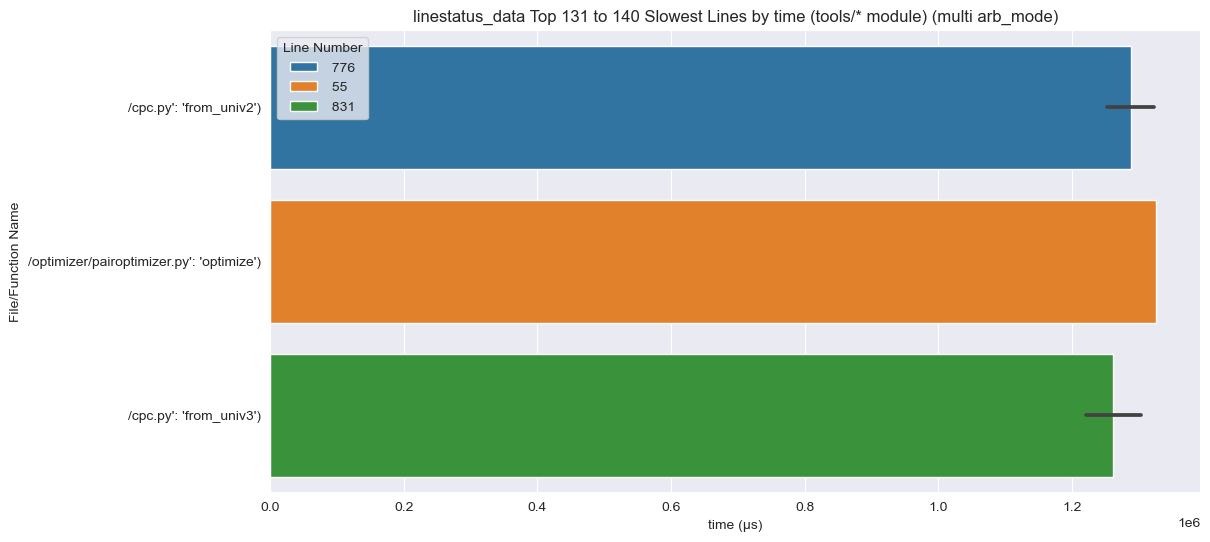

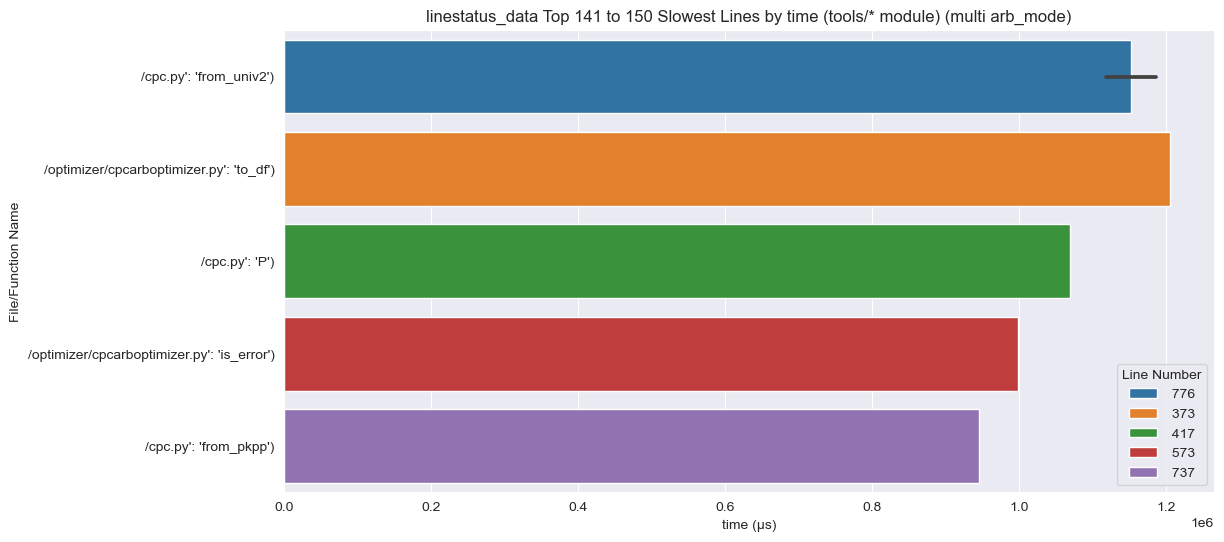

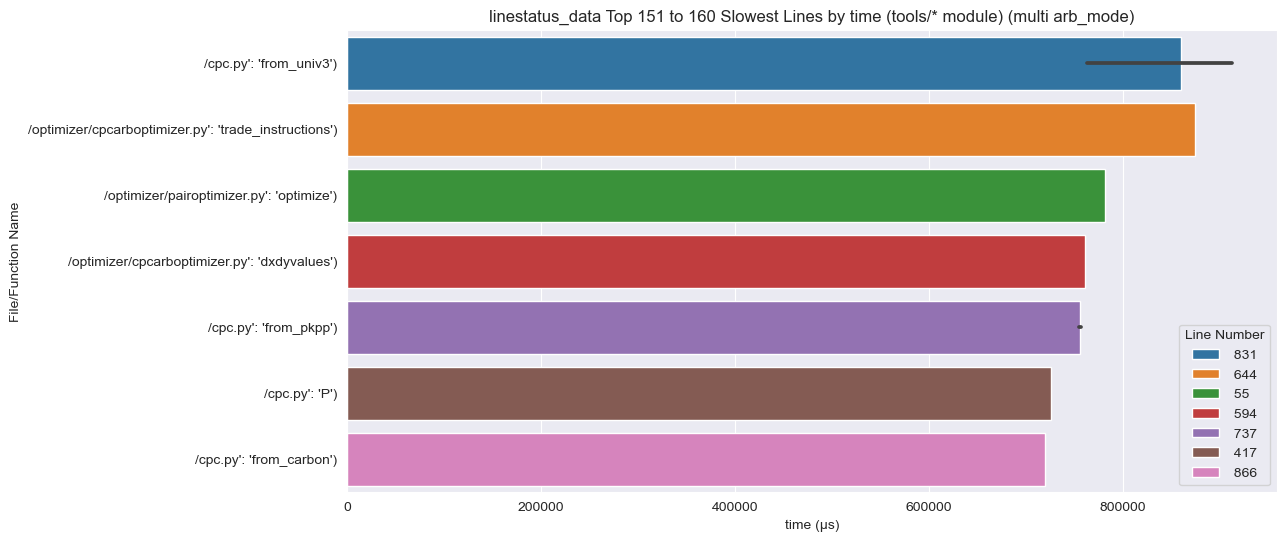

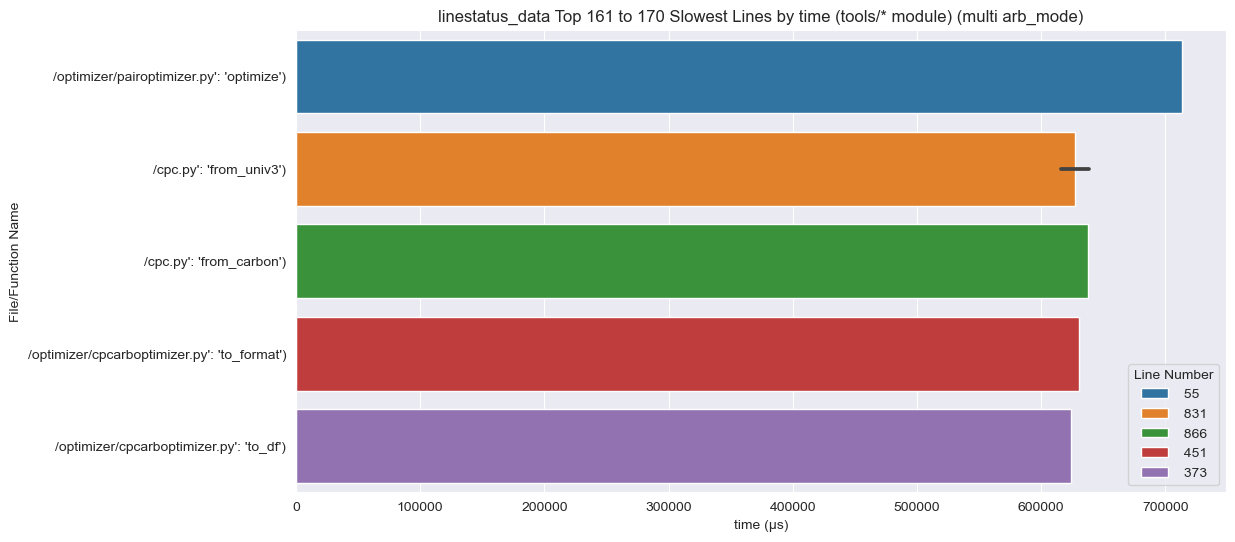

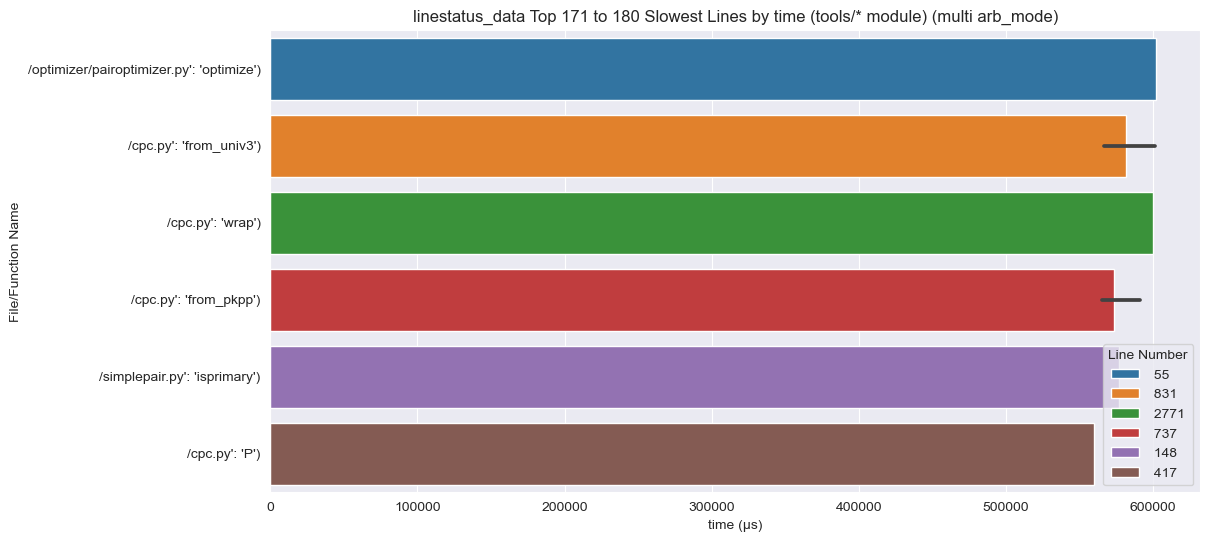

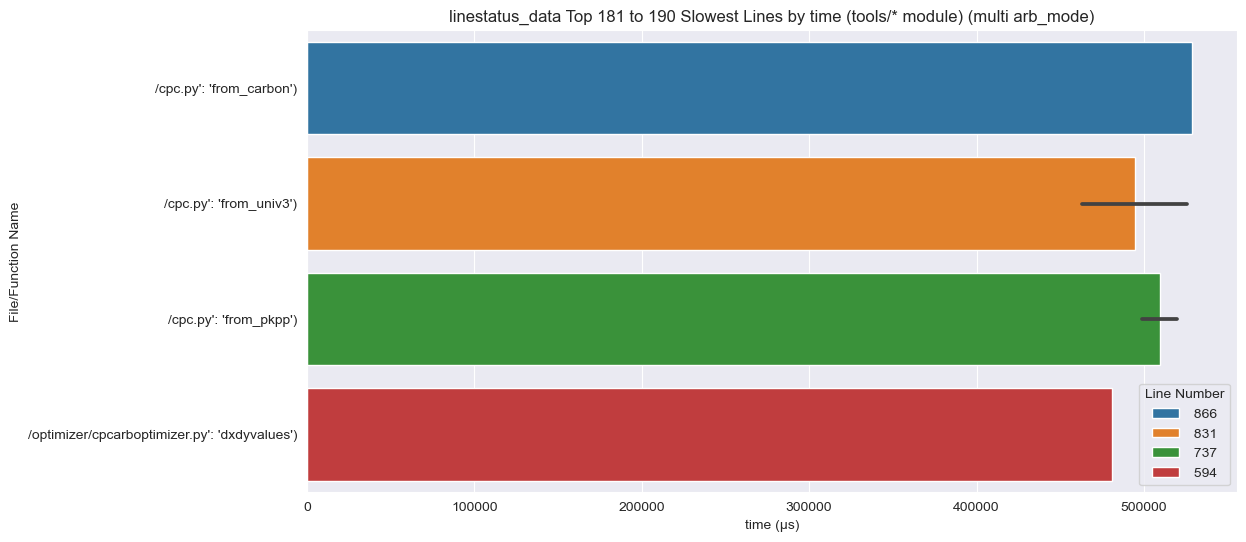

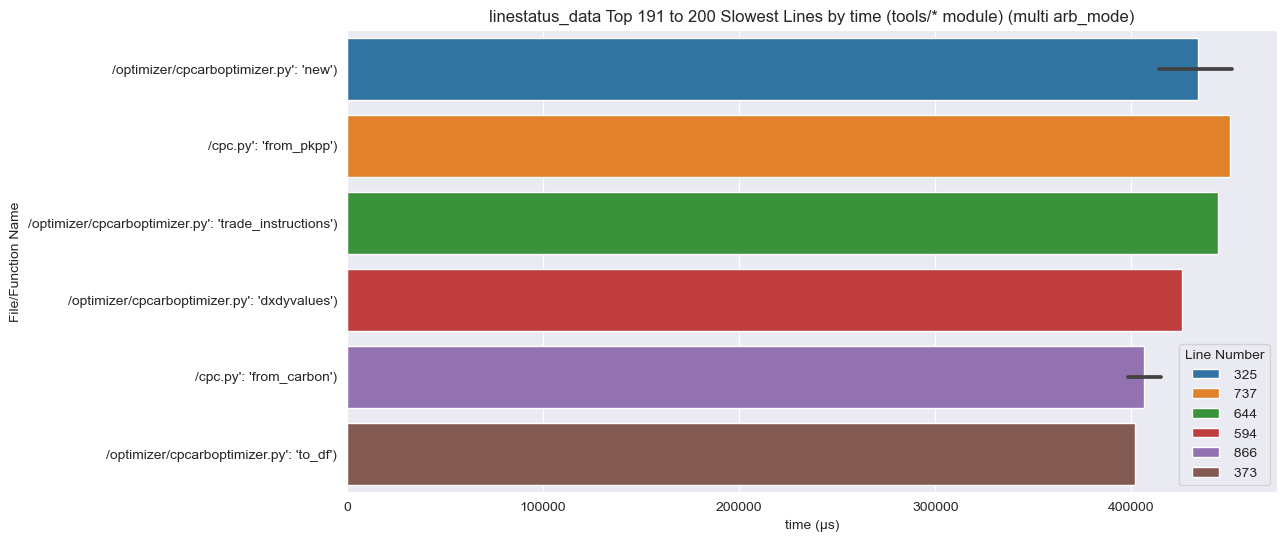

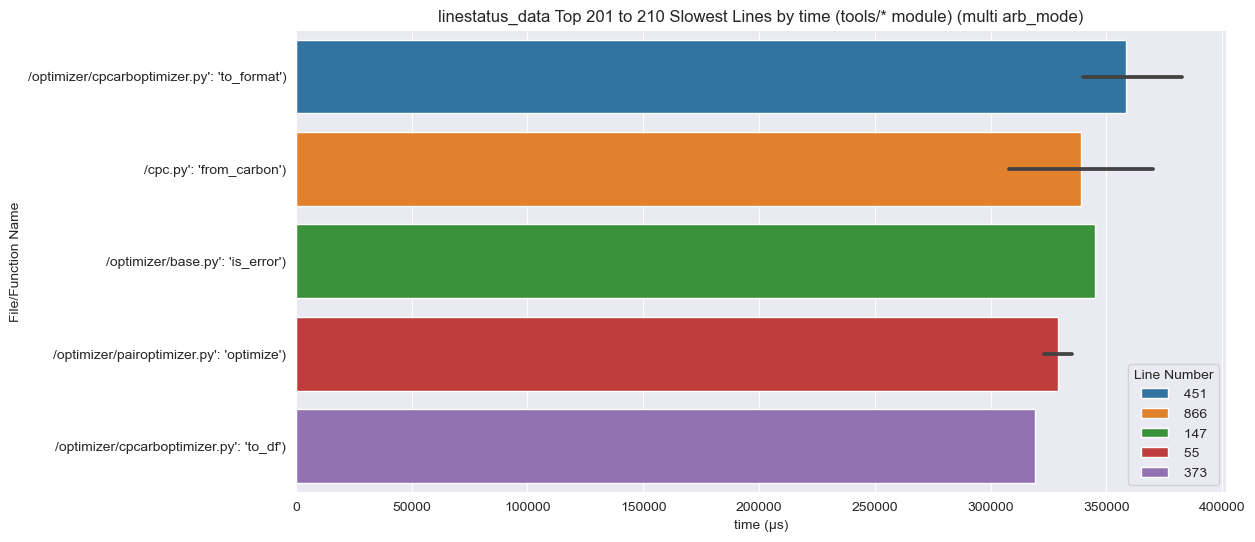

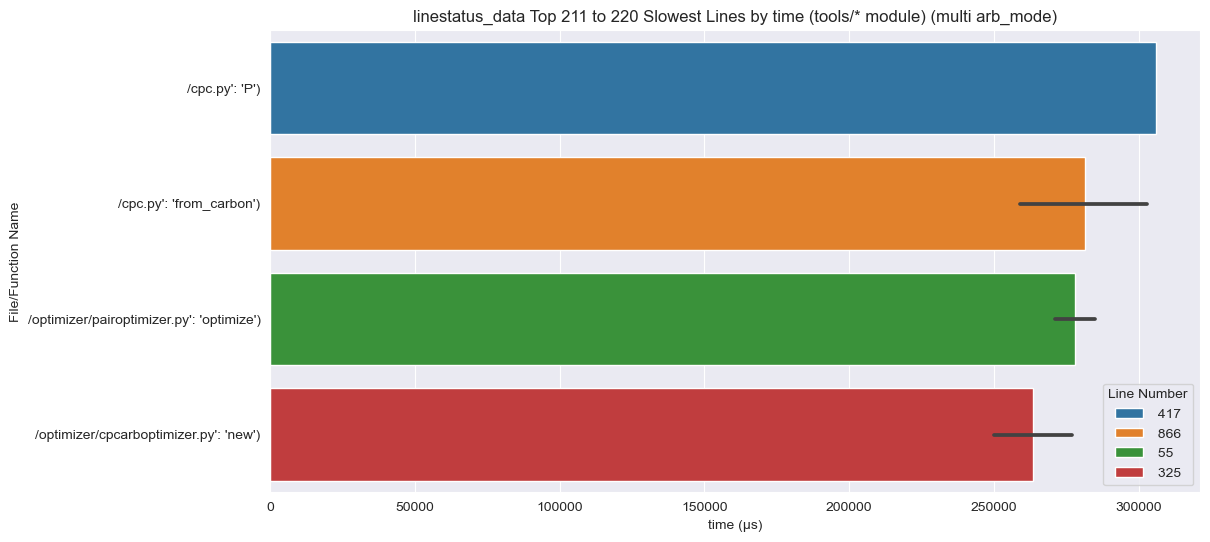

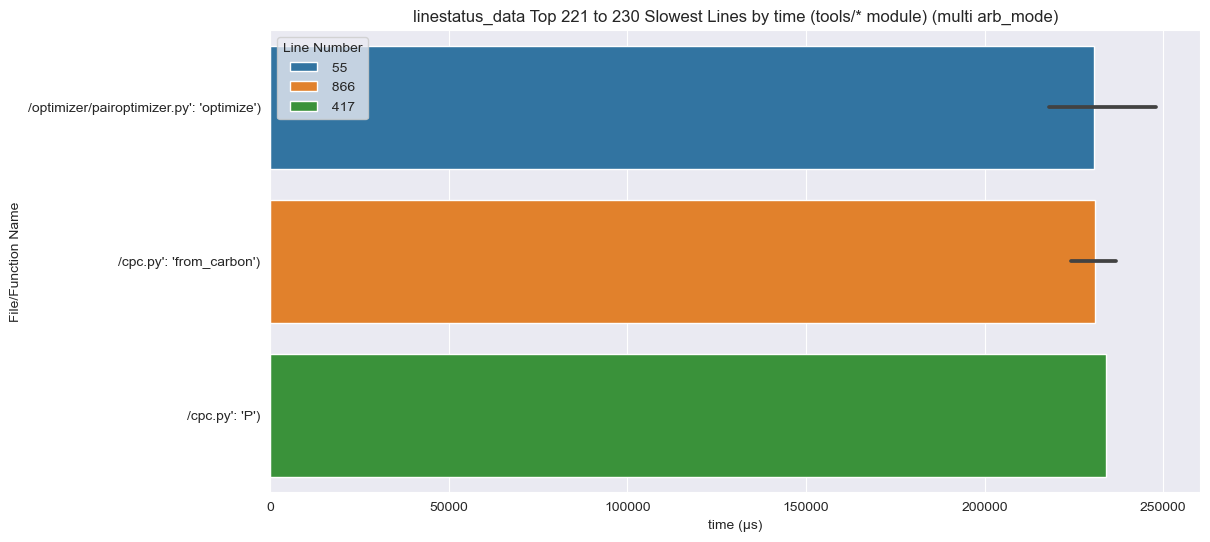

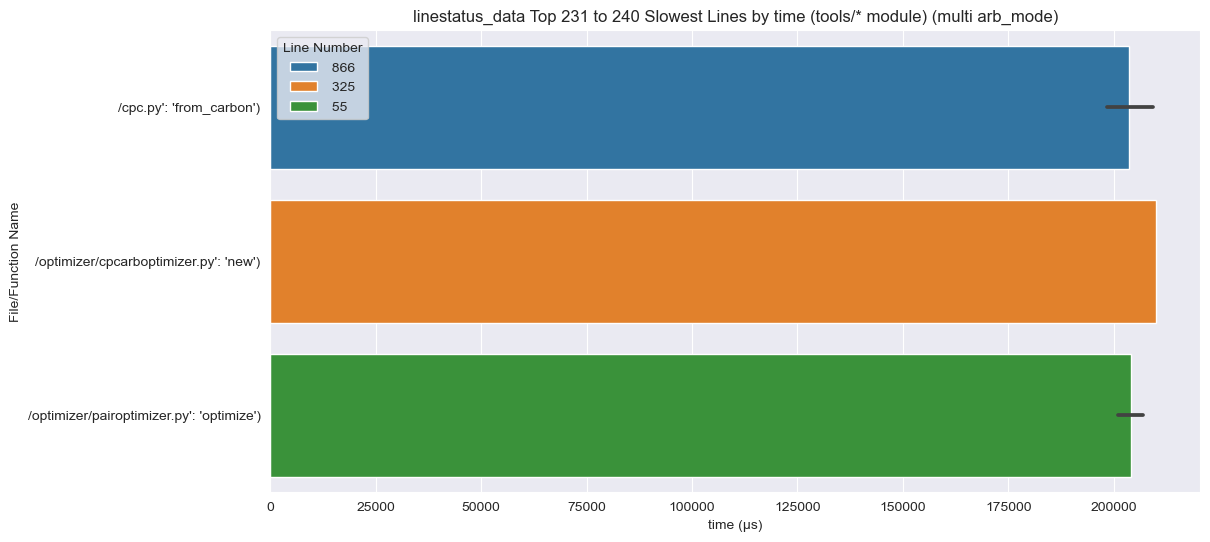

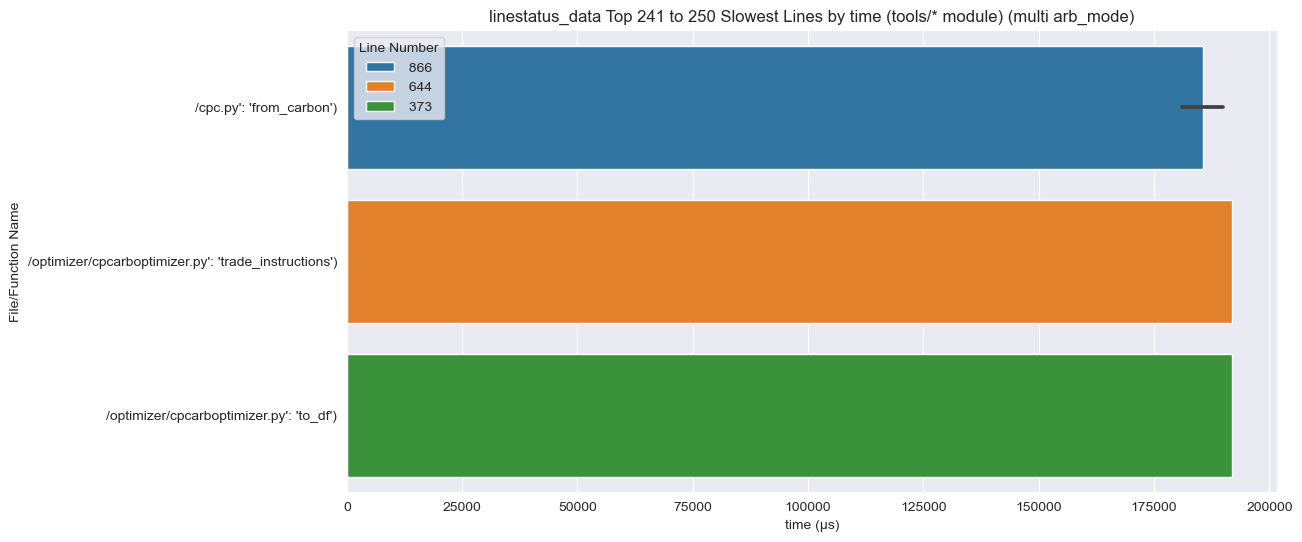

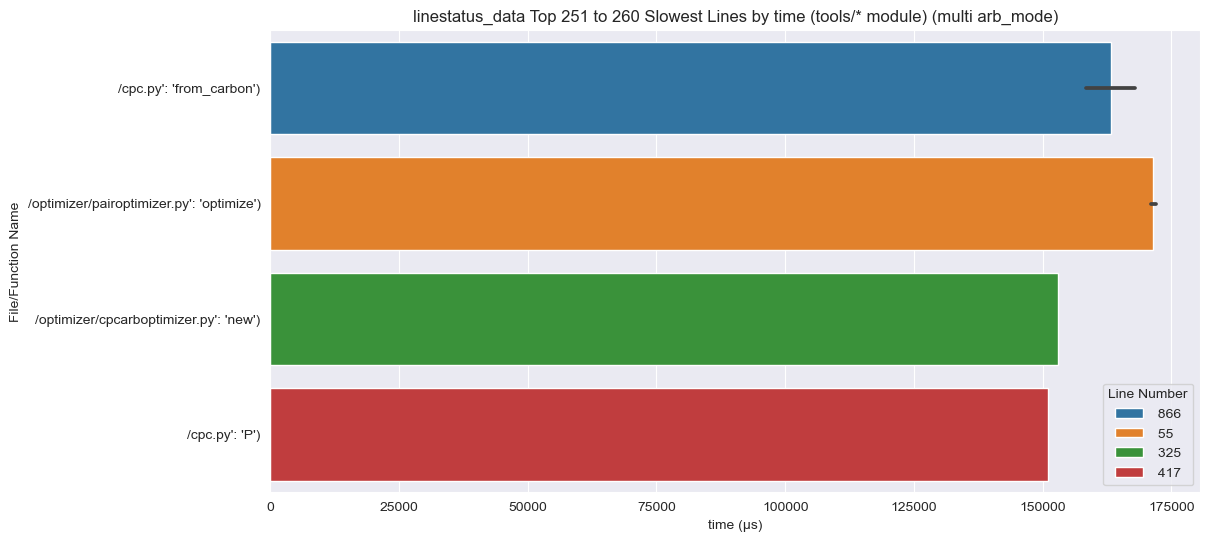

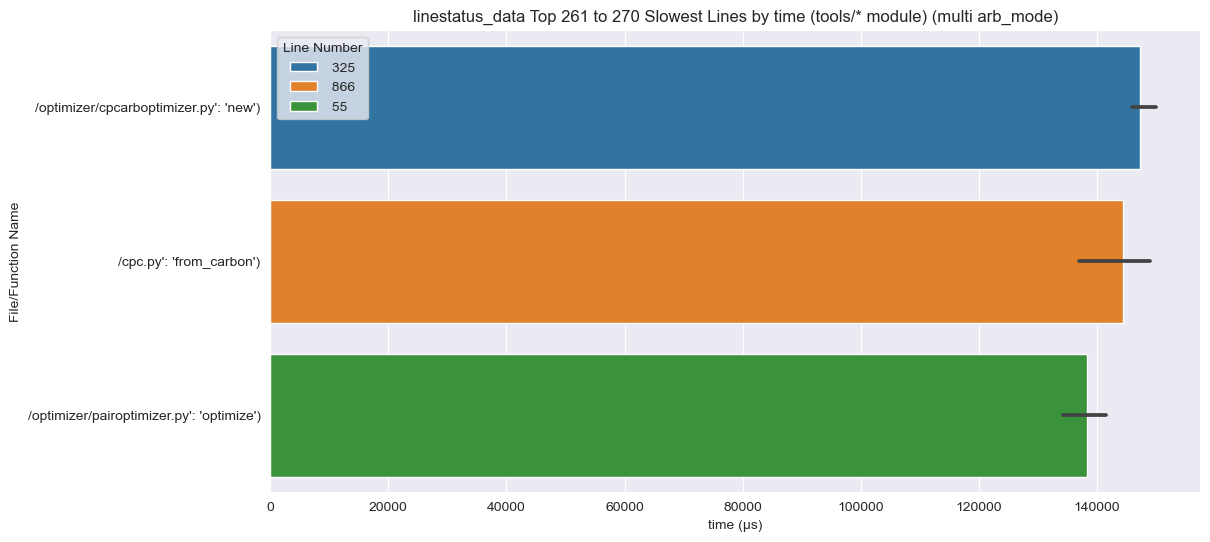

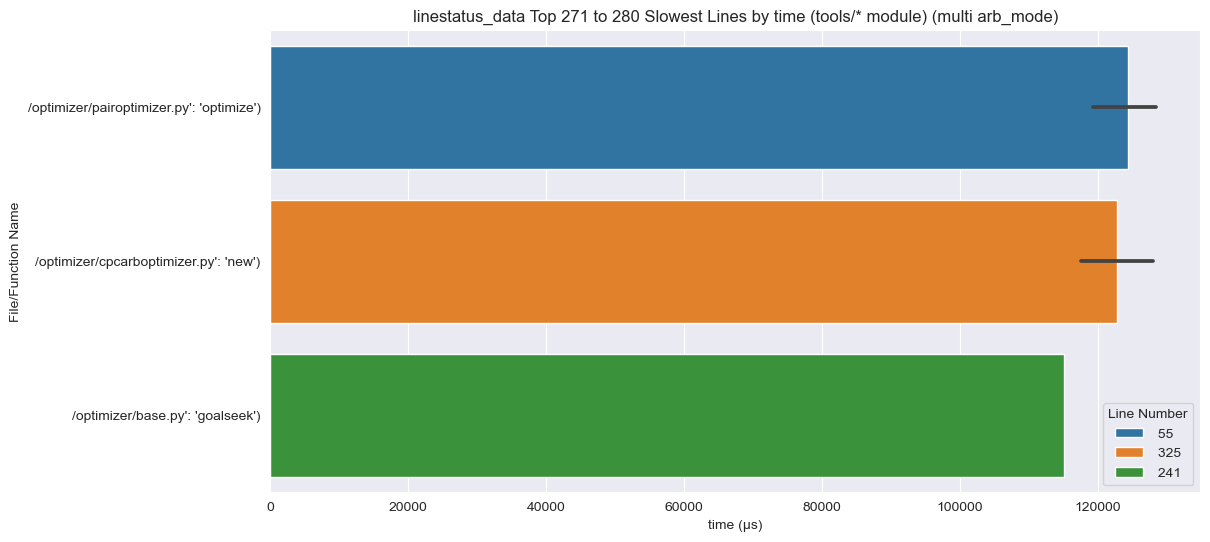

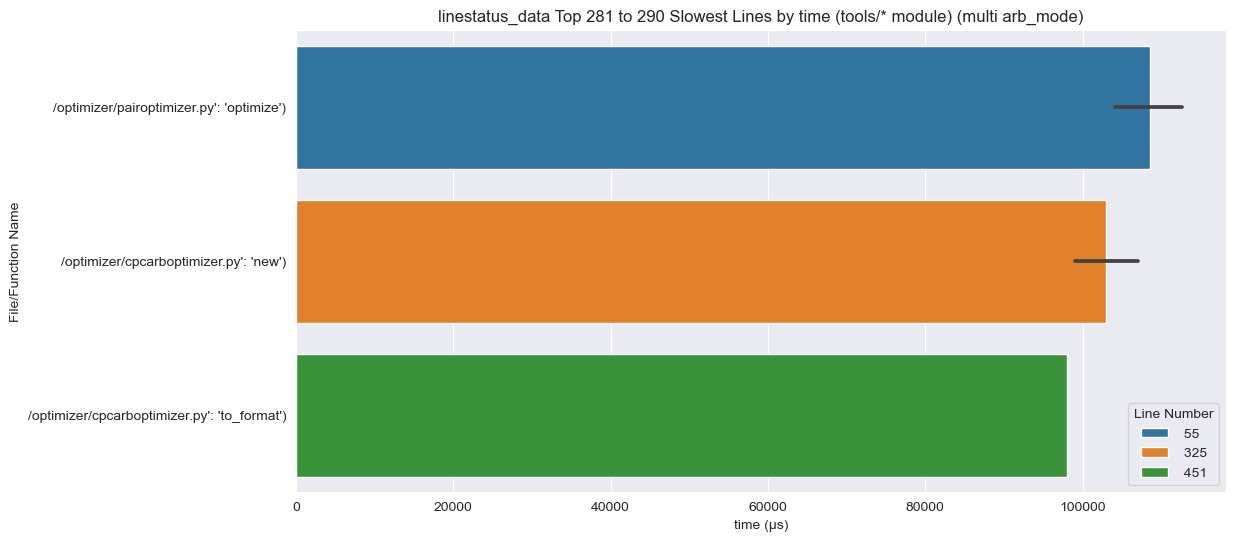

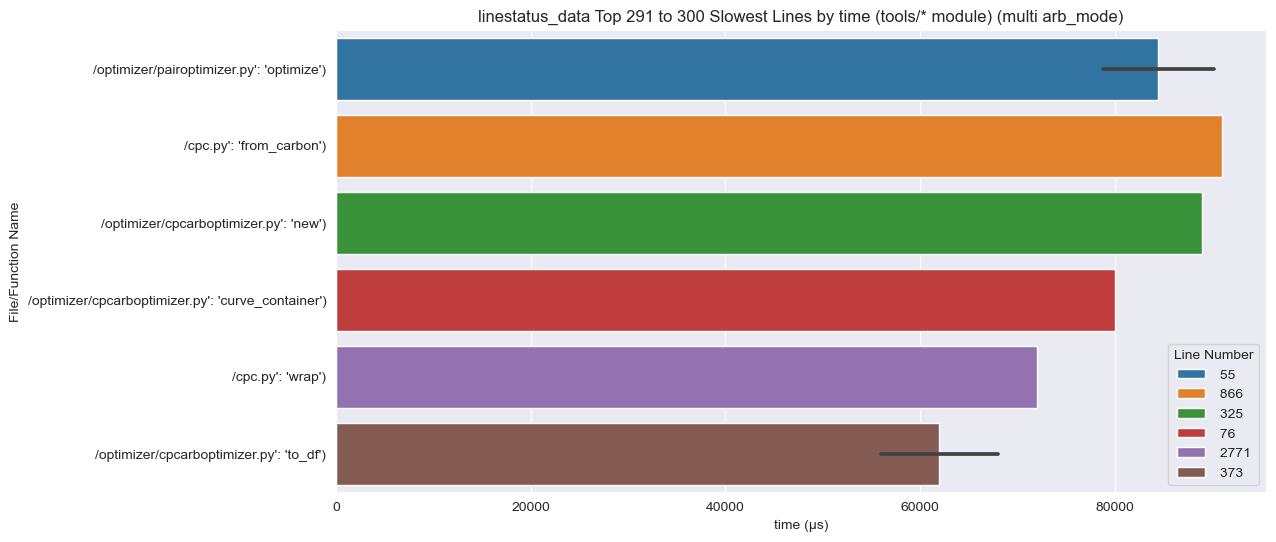

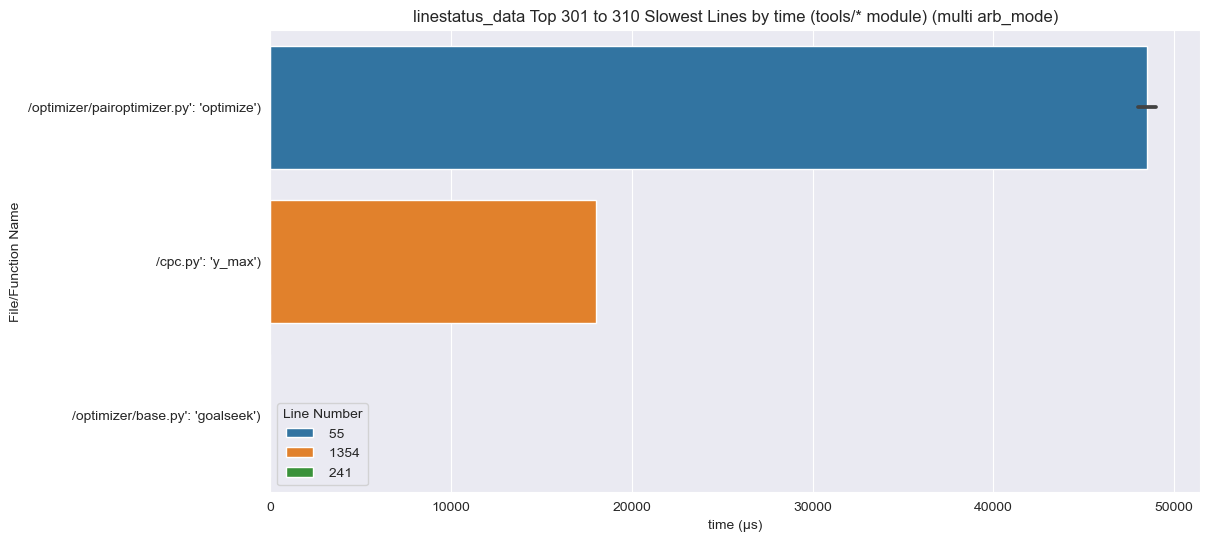

In [6]:
# Analyze events/ module profiling data
module = 'tools'
generate_plots(reports, module, 'cprofile_data')
generate_plots(reports, module, 'linestatus_data')


### Analyze modes/ module profiling data

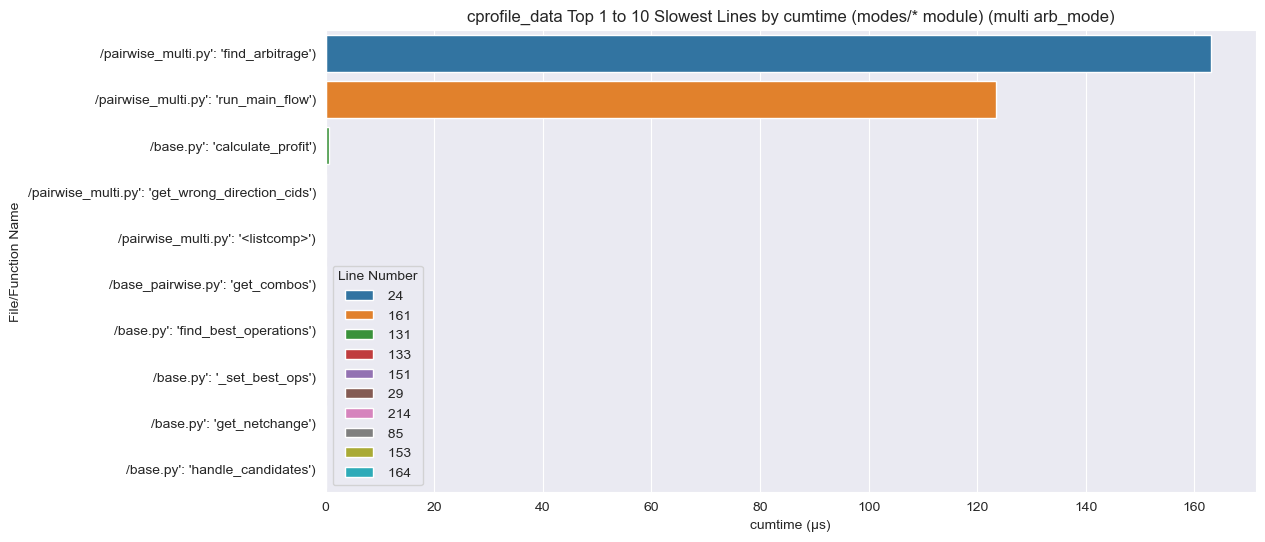

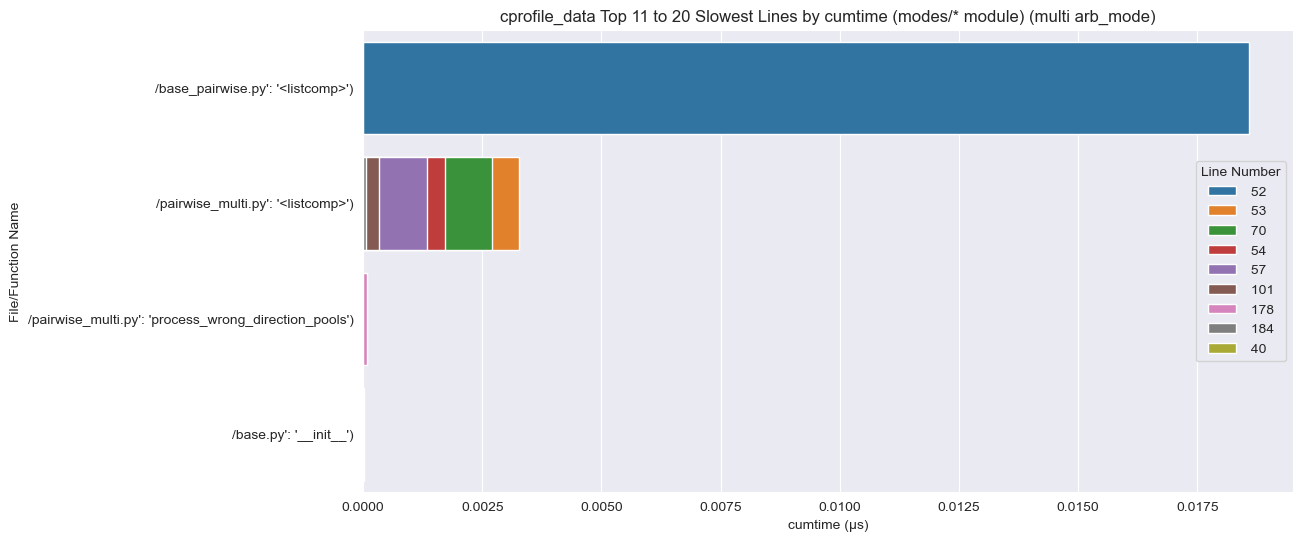

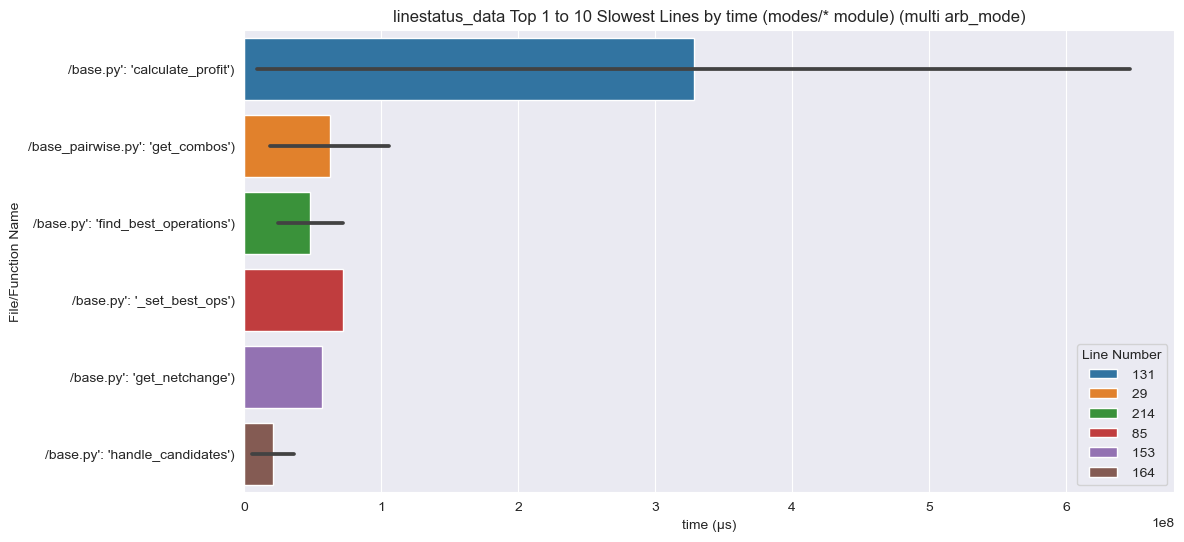

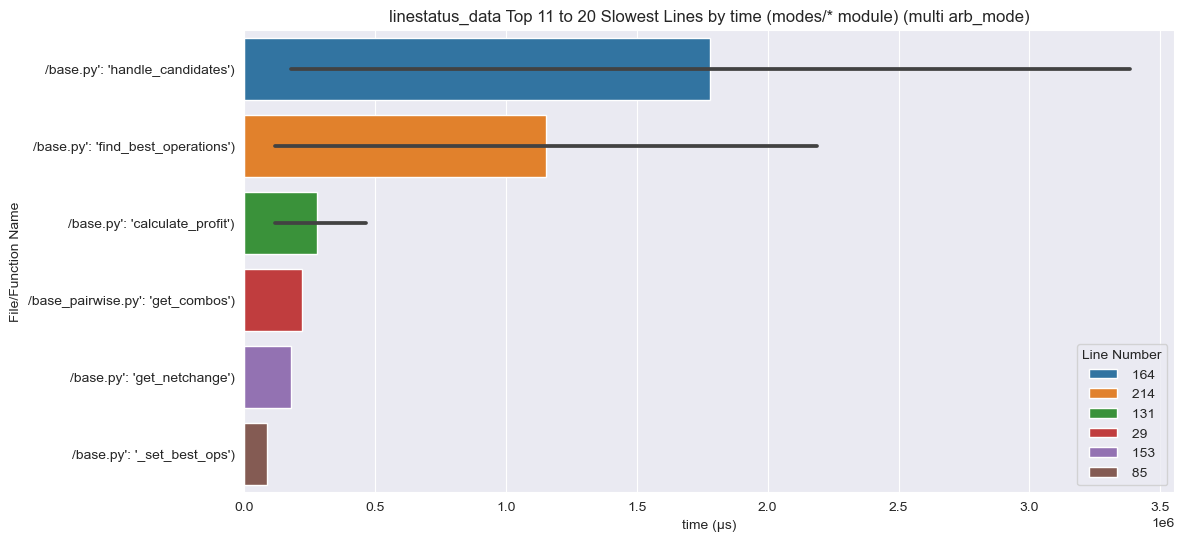

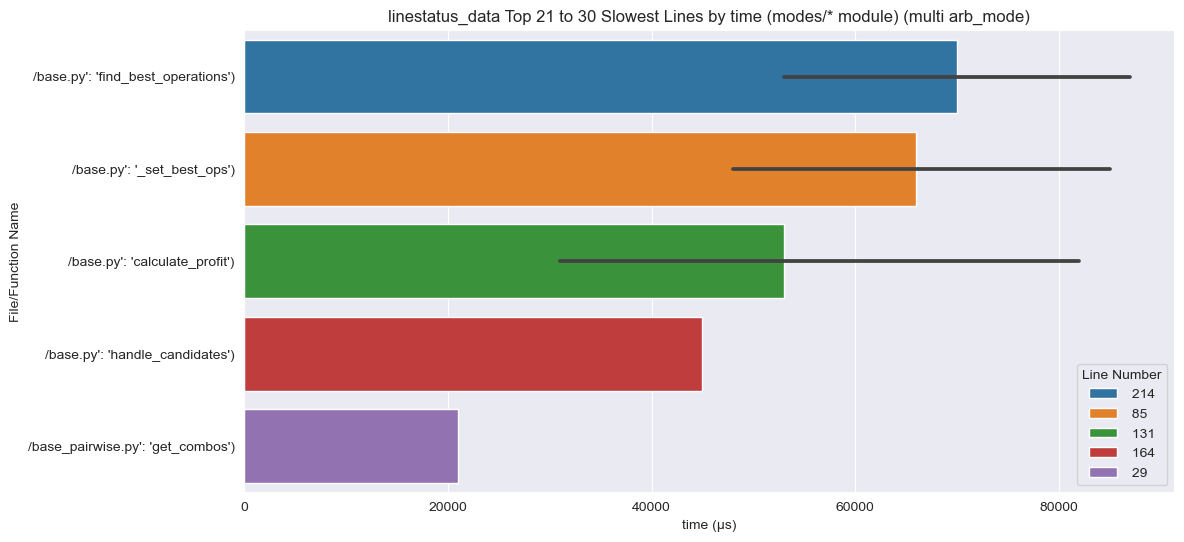

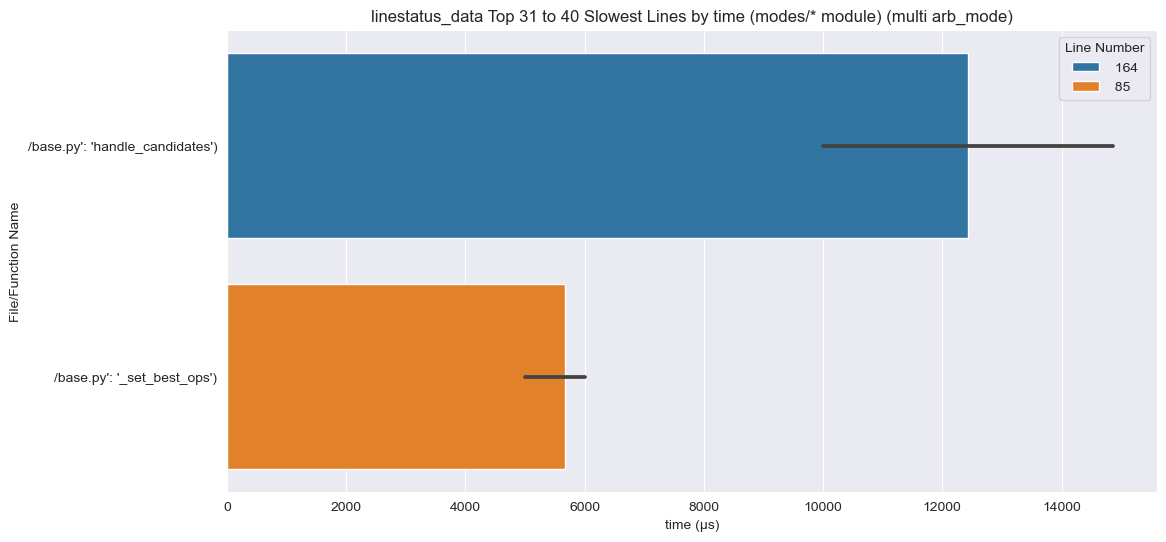

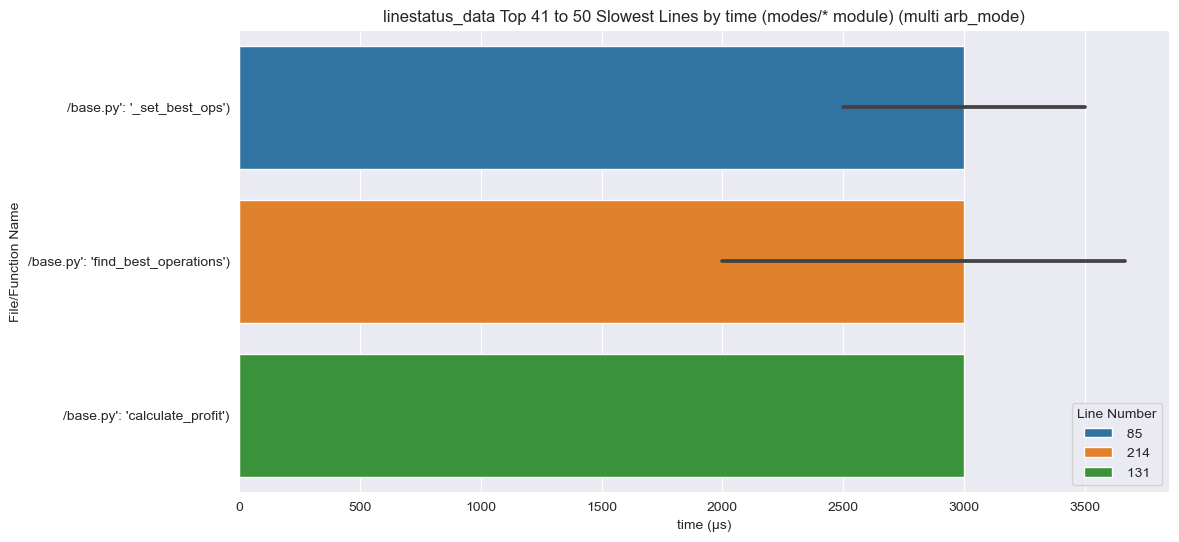

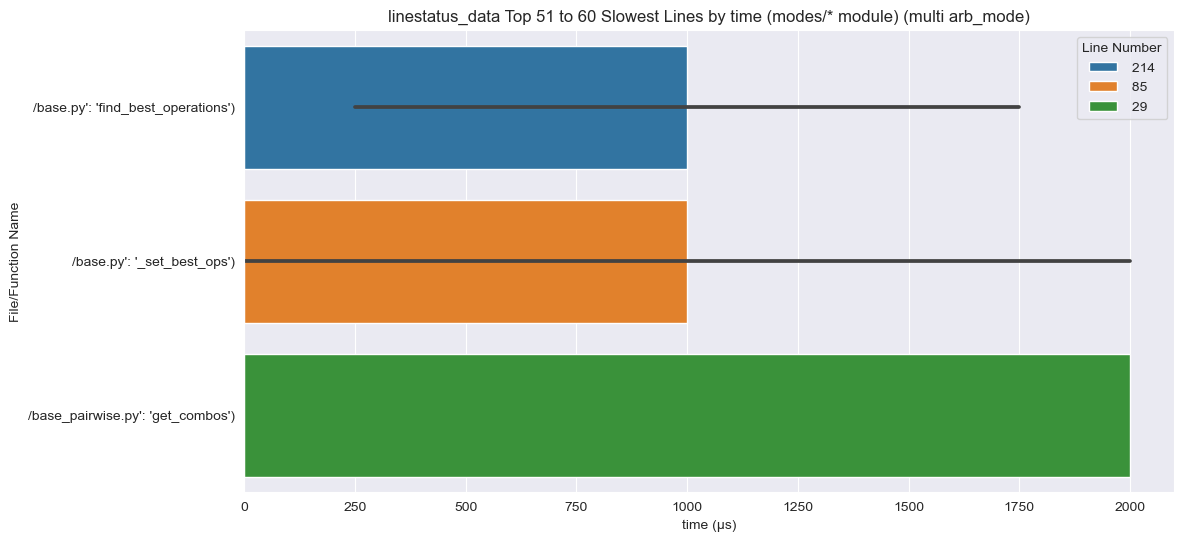

In [7]:
# Analyze modes/ module profiling data
module = 'modes'
generate_plots(reports, module, 'cprofile_data')
generate_plots(reports, module, 'linestatus_data')

### Analyze helpers/ module profiling data

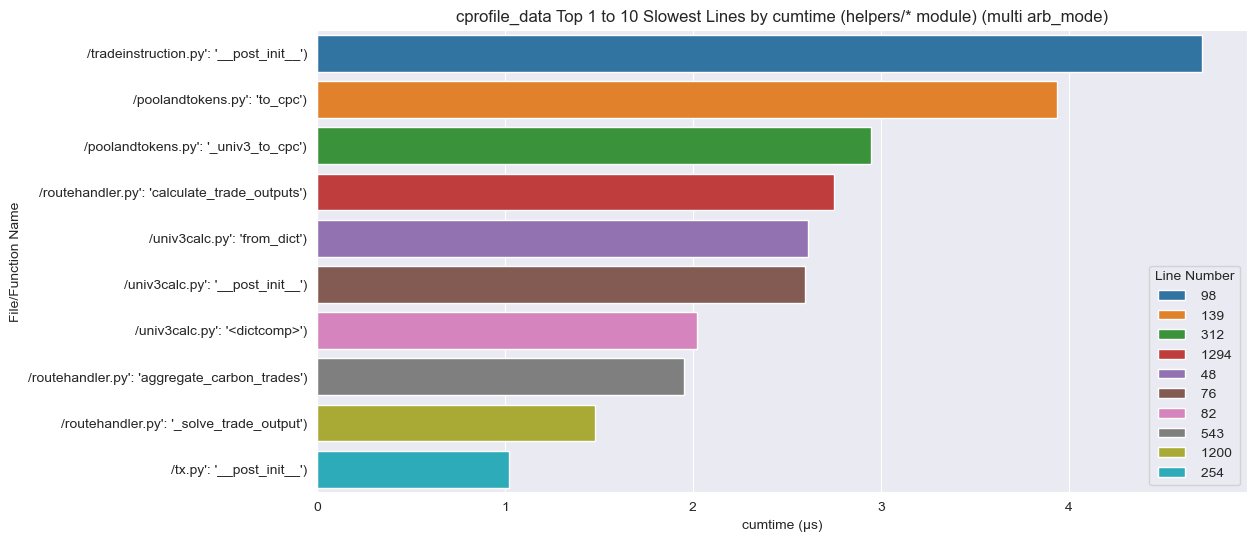

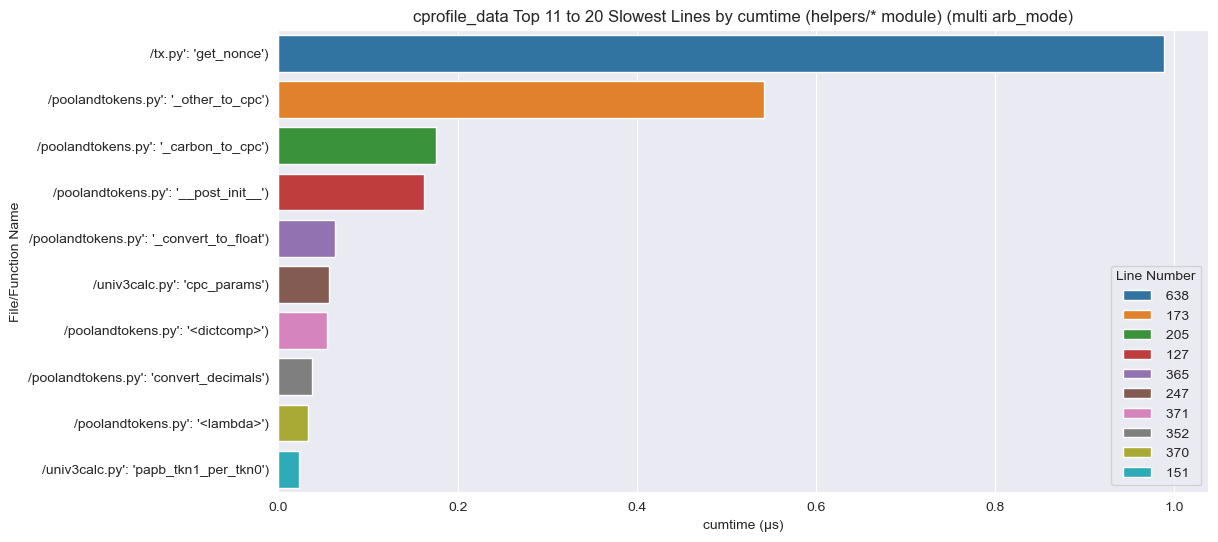

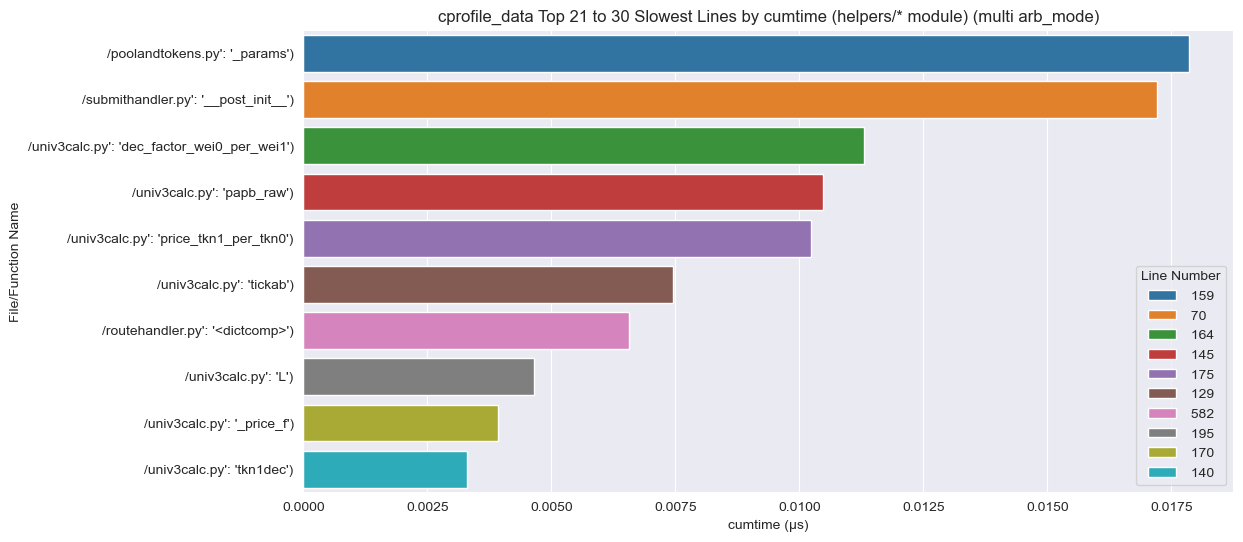

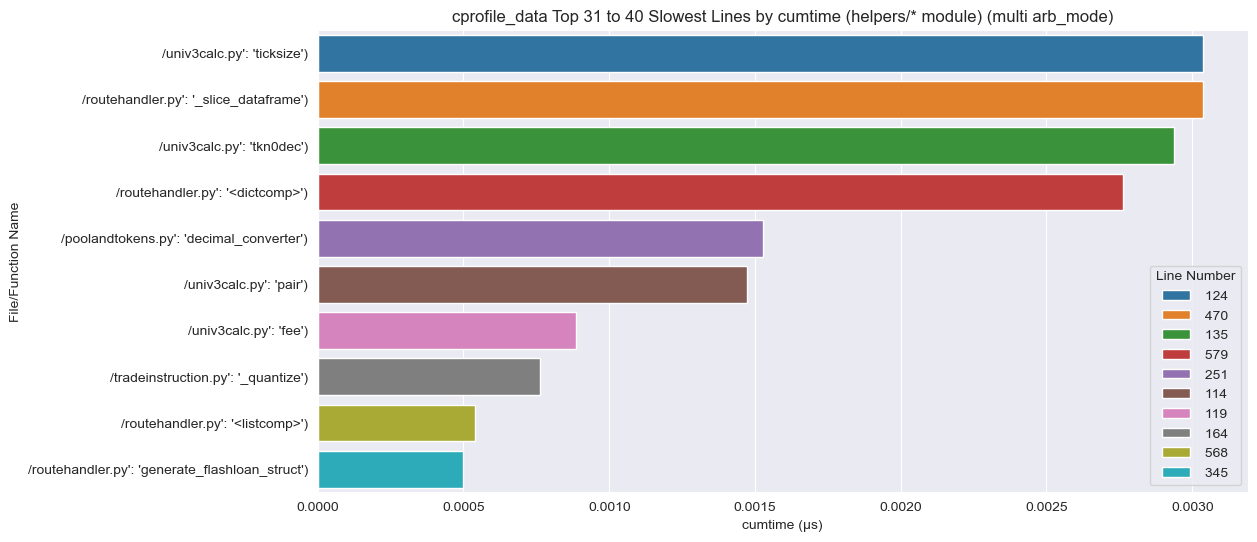

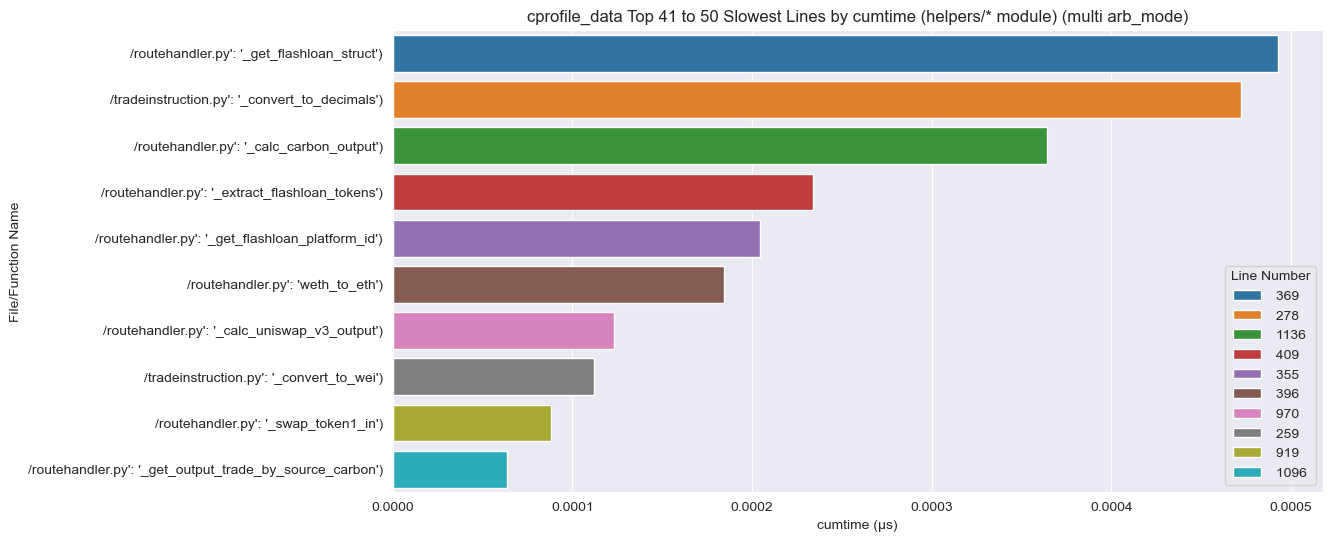

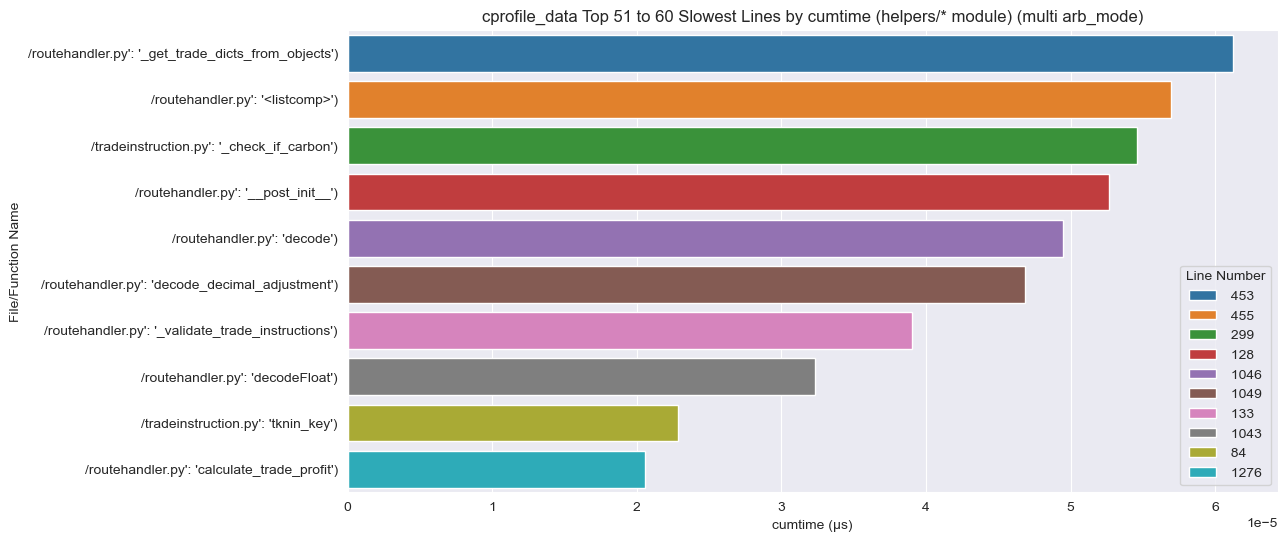

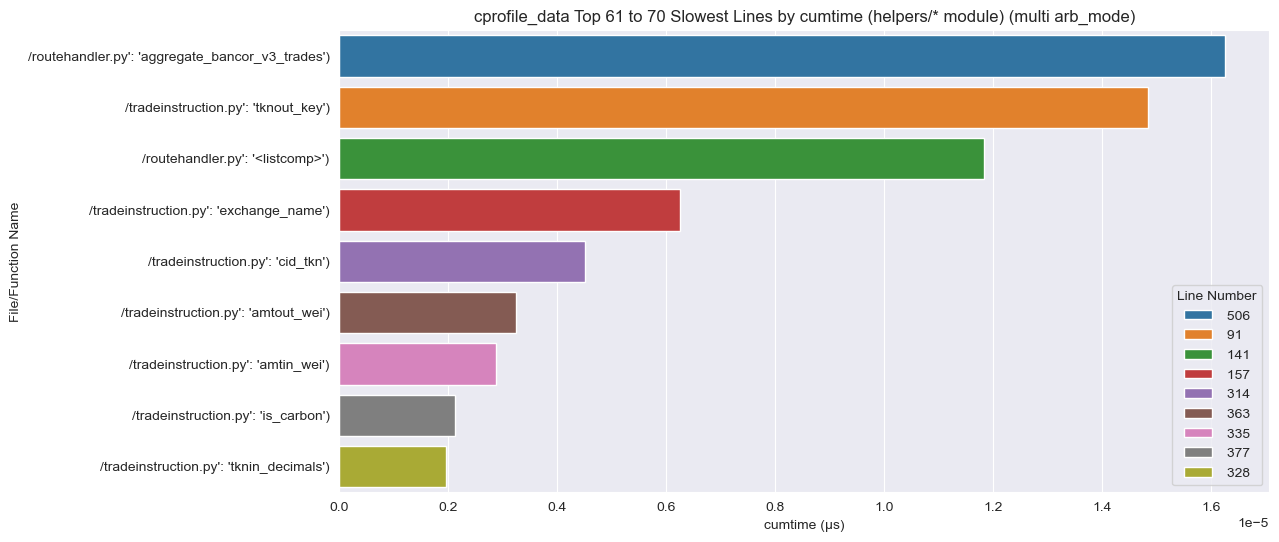

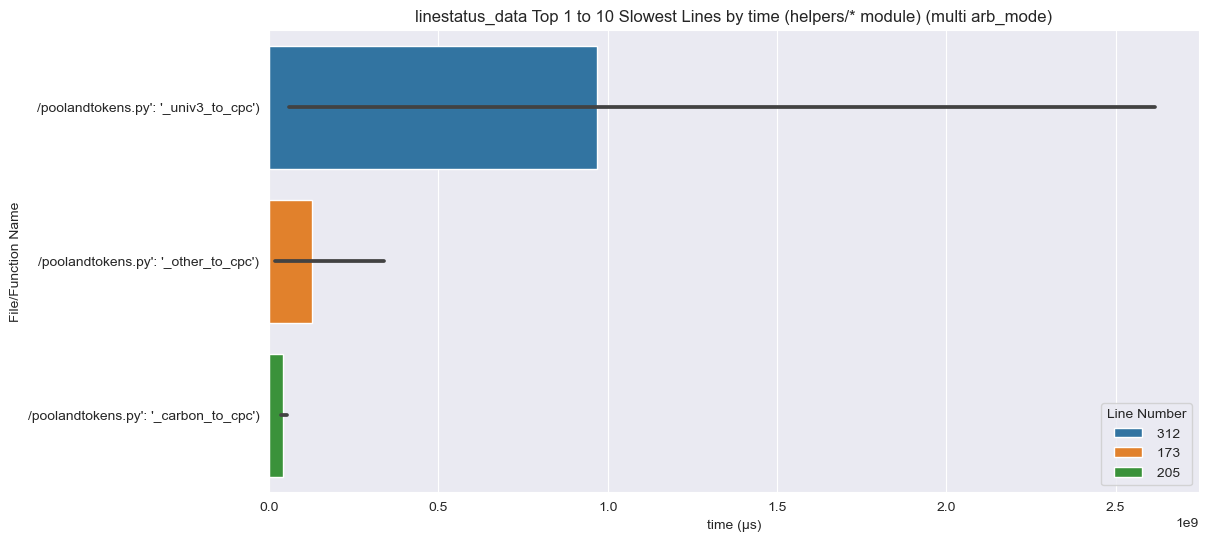

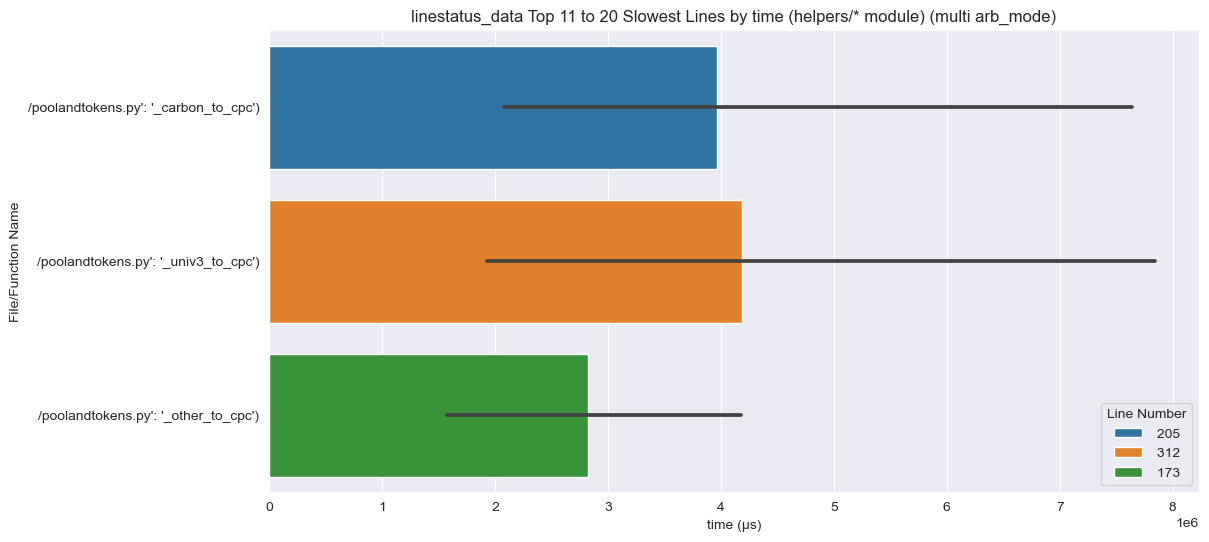

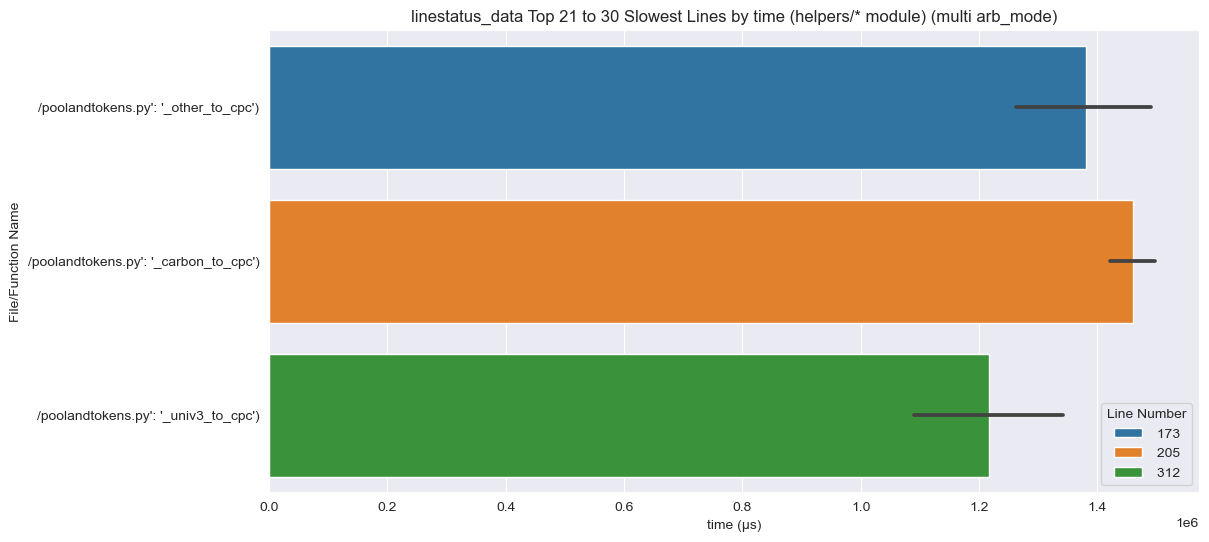

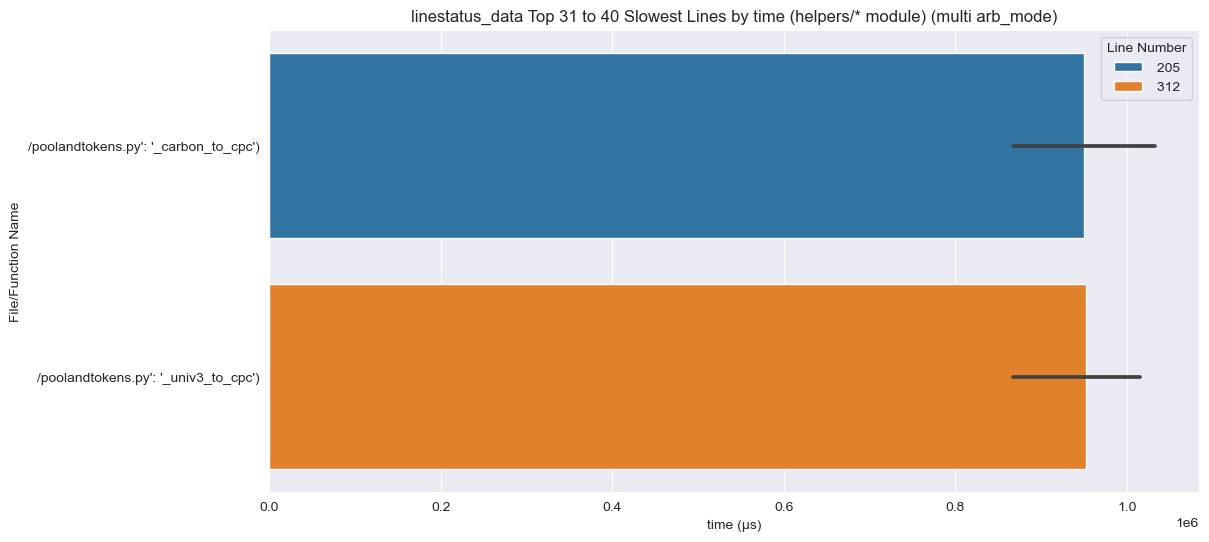

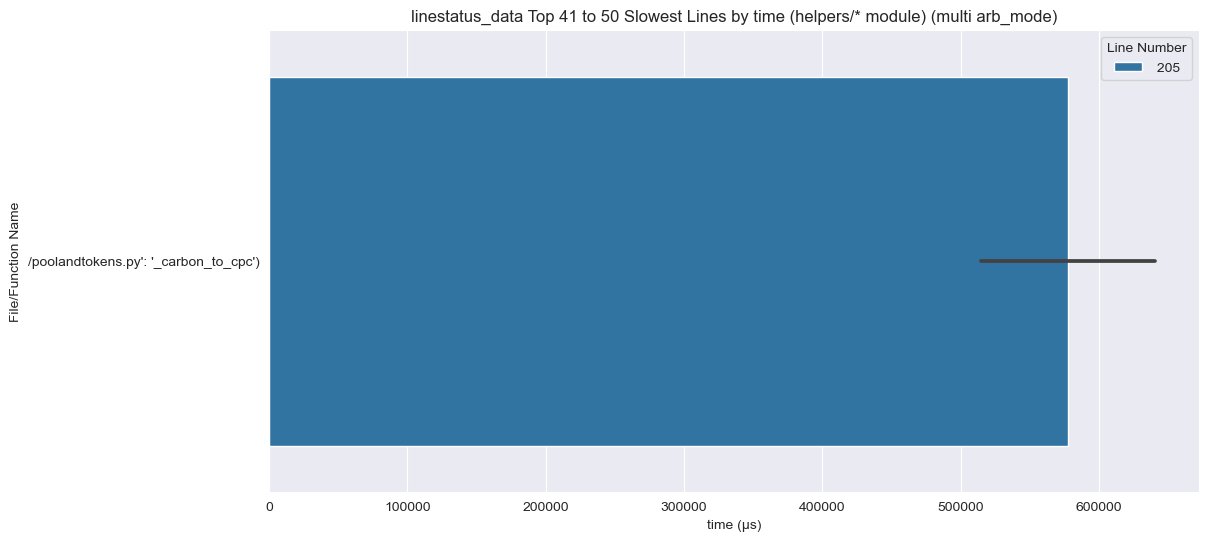

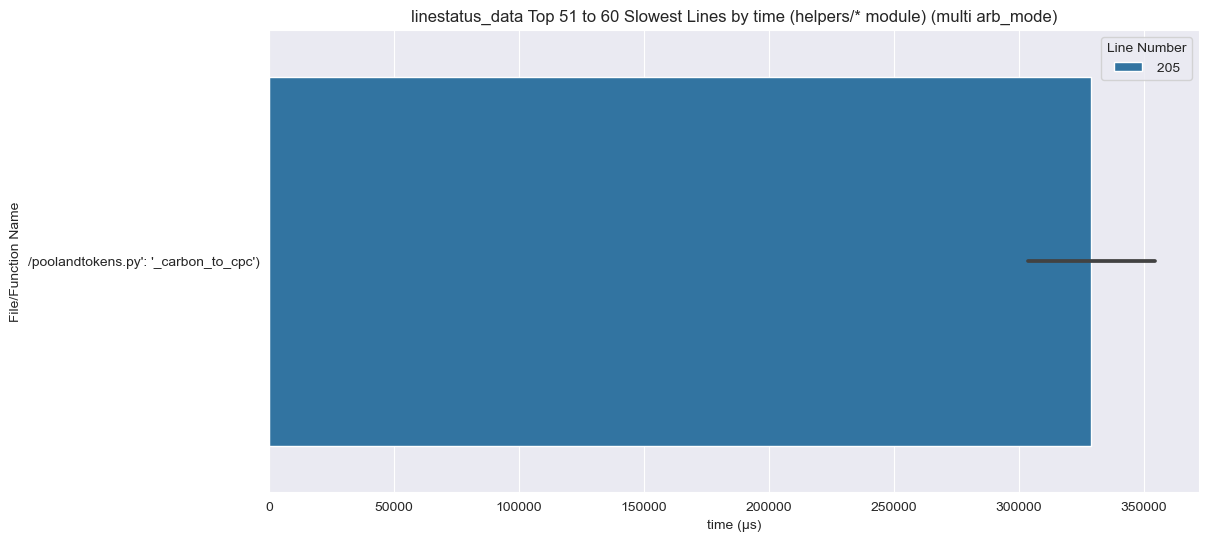

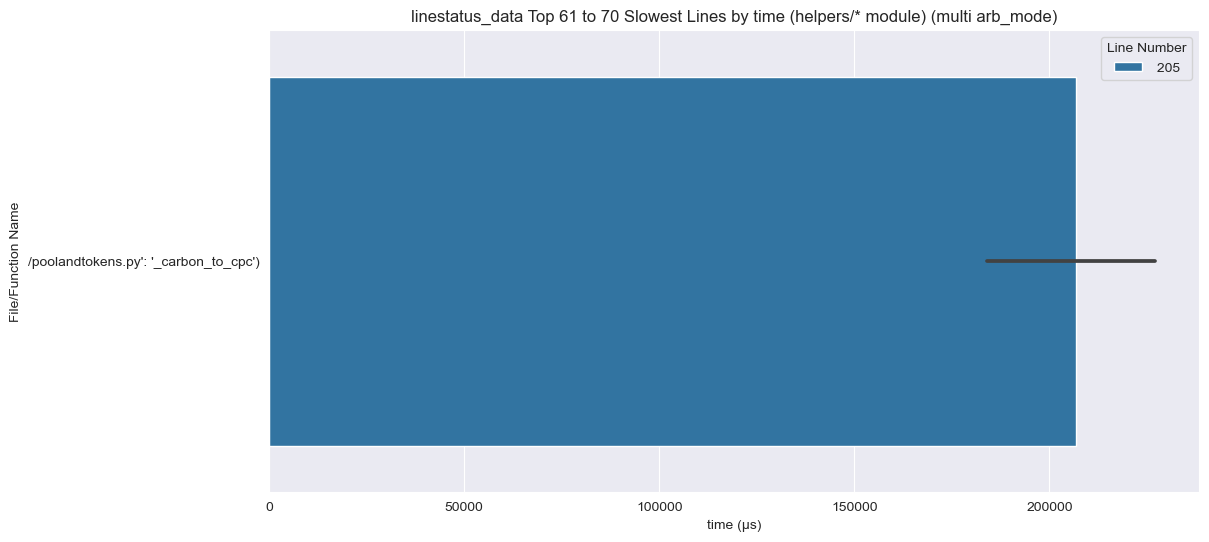

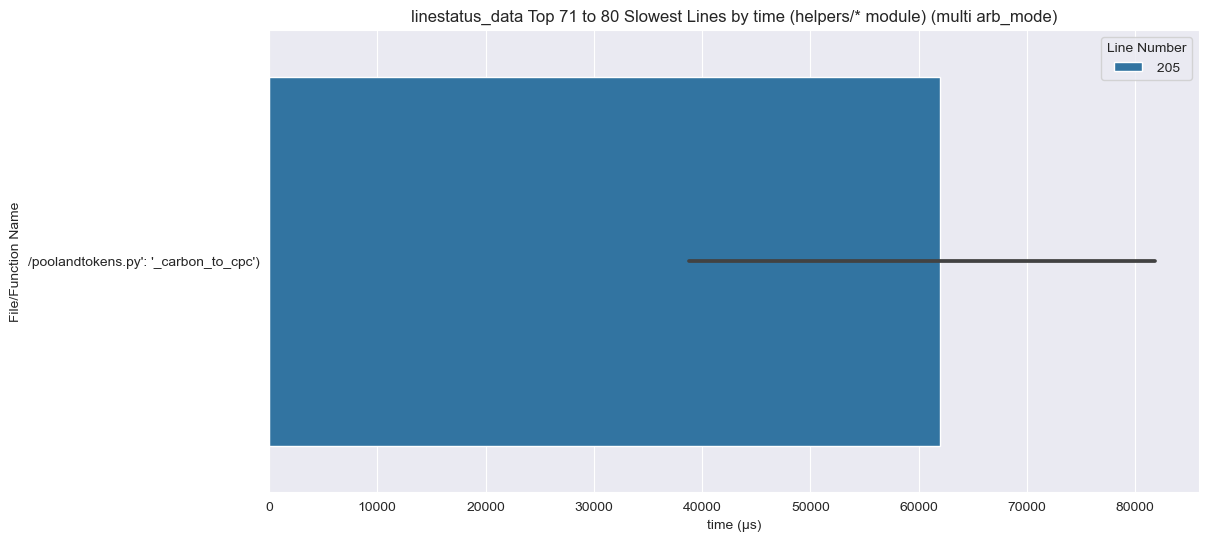

In [8]:
# Analyze helpers/ module profiling data
module = 'helpers'
generate_plots(reports, module, 'cprofile_data')
generate_plots(reports, module, 'linestatus_data')